# Week-25
Dataset Resource : [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)
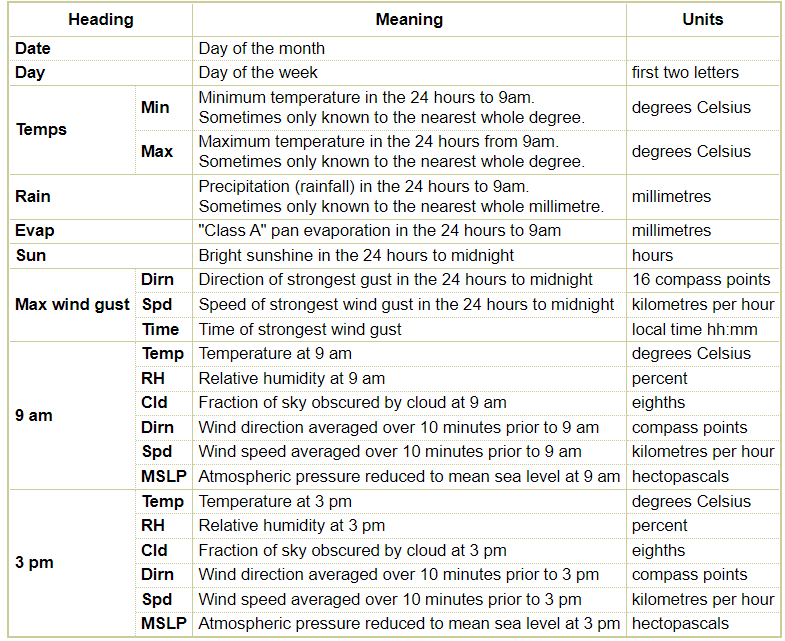

## Modelling

In [1]:
df=pd.read_csv('weather_cleandata_noOutlier.csv',index_col=[0])
df.head()

<IPython.core.display.Javascript object>

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Month,DiffTemp,RainTomorrow
0,13.4,22.9,0.6,9.24,8.92,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,3.8,16.9,21.8,0.0,12.0,9.5,0.0
1,7.4,25.1,0.0,7.68,10.36,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,2.2,3.0,17.2,24.3,0.0,12.0,17.7,0.0
2,12.9,25.7,0.0,10.48,11.02,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,2.8,2.0,21.0,23.2,0.0,12.0,12.8,0.0
3,9.2,28.0,0.0,10.00,12.22,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,2.4,4.0,18.1,26.5,0.0,12.0,18.8,0.0
4,17.5,32.3,1.0,5.64,8.26,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,12.0,14.8,0.0


In [2]:
# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
# rcParams['figure.figsize'] = 4,4
# plt.style.use('fivethirtyeight')

from collections import Counter

# for modeling 
import sklearn
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [3]:
# separating the dependent and independent data
X=df.drop(["RainTomorrow"], axis=1)
y=df["RainTomorrow"]

# the function train_test_split creates random data samples (default: 75-25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

# getting the shapes
print(f"""shape of X_train: {X_train.shape}
shape of X_test\t: {X_test.shape}
shape of y_train: {y_train.shape}
shape of y_test\t: {y_test.shape}""")

shape of X_train: (95031, 19)
shape of X_test	: (31677, 19)
shape of y_train: (95031,)
shape of y_test	: (31677,)


### Smooting

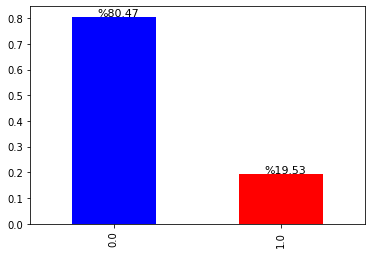

In [4]:
ax = df['RainTomorrow'].value_counts(normalize=True).plot.bar(color=["blue", "red"])
def labels(ax):
    for p in ax.patches:
        ax.annotate(f"%{p.get_height()*100:.2f}", (p.get_x() + 0.15, p.get_height() * 1.005),size=11)
labels(ax)

In [5]:
# # pip install imblearn
# from imblearn import under_sampling, over_sampling
# from imblearn.over_sampling import SMOTE

In [6]:
# oversmote = SMOTE()
# X_train, y_train= oversmote.fit_resample(X_train, y_train)

In [7]:
# ax = y_train.value_counts().plot.bar(color=["blue", "red"])
# def labels(ax):
#     for p in ax.patches:
#         ax.annotate(f"{p.get_height()}", (p.get_x() + 0.15, p.get_height()+200),size=8)
# labels(ax)
# plt.show()

In [8]:
# X_train.shape

### Data Scaling

In [9]:
# creating a minmax scaler
sc = MinMaxScaler()

# fitting independent data to the model
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
cv_acc_train = {}
cv_acc_test = {}
cv_TPR = {}
cv_FPR = {}
cv_AUC = {}
f1 = {}
recall = {}

In [11]:
def plot_result(model, name:str):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores_train = cross_val_score(model, X_train, y_train, cv=10, scoring = 'balanced_accuracy')
    scores_test = cross_val_score(model, X_test, y_test, cv=10, scoring = 'balanced_accuracy')  
    cv_acc_train[name] = round(scores_train.mean(), 4)  # balanced accuracy
    cv_acc_test[name] = round(scores_test.mean(), 4)  # balanced accuracy
    cv_TPR[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())  # recall (Max)
    cv_FPR[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())  # fallout (Min)
    f1[name] = f1_score(y_test, y_pred, average='macro')
    recall[name] = recall_score(y_test, y_pred, average='macro')
    
    # accuracy scores
    print('Average Balanced Accuracy (CV=10), Test Set:', scores_test.mean())  
    print('Average Balanced Accuracy (CV=10), Training Set: ', scores_train.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

In [12]:
def plot_feature_importances(model):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:10]

    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

    print(f"Top 10 Feature Importance for {str(model).split('(')[0]}\n\n",feature_imp[:10],sep='')

### 1-Logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression

Average Balanced Accuracy (CV=10), Test Set: 0.6962112285515918
Average Balanced Accuracy (CV=10), Training Set:  0.6945812843114957
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.91     25492
         1.0       0.70      0.44      0.54      6185

    accuracy                           0.85     31677
   macro avg       0.79      0.70      0.73     31677
weighted avg       0.84      0.85      0.84     31677



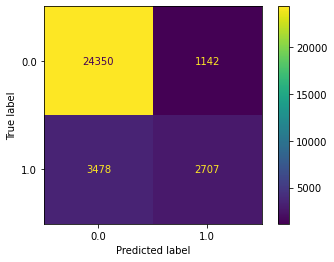

In [14]:
lr = LogisticRegression()
plot_result(lr, "lr")

### 2-Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB

Average Balanced Accuracy (CV=10), Test Set: 0.7402856324038103
Average Balanced Accuracy (CV=10), Training Set:  0.7363628388976298
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85     25492
         1.0       0.45      0.68      0.54      6185

    accuracy                           0.78     31677
   macro avg       0.68      0.74      0.70     31677
weighted avg       0.82      0.78      0.79     31677



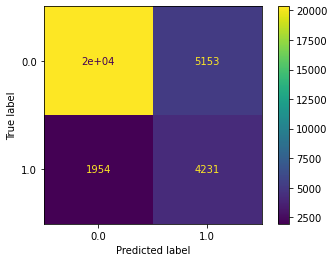

In [16]:
nb = GaussianNB()
plot_result(nb, "nb")

### 3-K-Nearest Neighbor (KNN)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
# knn = KNeighborsClassifier()
# plot_result(knn, "knn")

### 4-Support Vector Mechanism (SVM)

In [19]:
# svc = SVC(probability=True)  # default values
# plot_result(svc, "svc")

### 5-Decision Tree Classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Average Balanced Accuracy (CV=10), Test Set: 0.6673676722612274
Average Balanced Accuracy (CV=10), Training Set:  0.6719930371415075
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87     25492
         1.0       0.46      0.47      0.47      6185

    accuracy                           0.79     31677
   macro avg       0.67      0.67      0.67     31677
weighted avg       0.79      0.79      0.79     31677



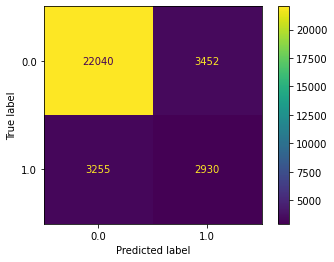

In [21]:
dtc = DecisionTreeClassifier()
plot_result(dtc, "dtc")

### 6-NearestCentroid

In [22]:
from sklearn.neighbors import NearestCentroid

Average Balanced Accuracy (CV=10), Test Set: 0.7326355125710934
Average Balanced Accuracy (CV=10), Training Set:  0.7290980562955206
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81     25492
         1.0       0.40      0.74      0.52      6185

    accuracy                           0.73     31677
   macro avg       0.66      0.73      0.66     31677
weighted avg       0.82      0.73      0.75     31677



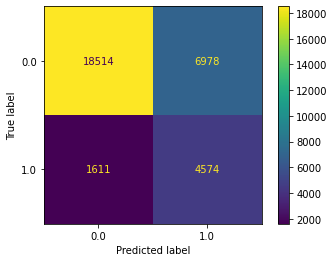

In [23]:
nc = NearestCentroid()
plot_result(nc, "nc")

### 7-Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

Average Balanced Accuracy (CV=10), Test Set: 0.6892120735281161
Average Balanced Accuracy (CV=10), Training Set:  0.6936665930146912
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     25492
         1.0       0.74      0.43      0.55      6185

    accuracy                           0.86     31677
   macro avg       0.81      0.70      0.73     31677
weighted avg       0.85      0.86      0.84     31677



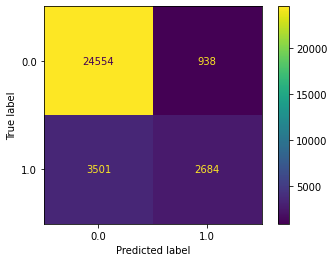

In [25]:
rfc = RandomForestClassifier()
plot_result(rfc, "rfc")

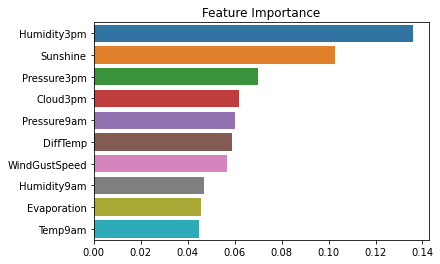

Top 10 Feature Importance for RandomForestClassifier

Humidity3pm      0.135831
Sunshine         0.102733
Pressure3pm      0.069805
Cloud3pm         0.061797
Pressure9am      0.060253
DiffTemp         0.059008
WindGustSpeed    0.056619
Humidity9am      0.046899
Evaporation      0.045584
Temp9am          0.044906
dtype: float64


In [26]:
plot_feature_importances(rfc)

### 8-Gradient Boosting Classifier

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
# gbc = GradientBoostingClassifier(random_state=42)
# plot_result(gbc, "gbc")

In [29]:
# plot_feature_importances(gbc)

### 9-XGBOOST

In [30]:
from xgboost import XGBClassifier

Average Balanced Accuracy (CV=10), Test Set: 0.7034962726098073
Average Balanced Accuracy (CV=10), Training Set:  0.7079922905232544
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     25492
         1.0       0.71      0.47      0.57      6185

    accuracy                           0.86     31677
   macro avg       0.80      0.71      0.74     31677
weighted avg       0.85      0.86      0.85     31677



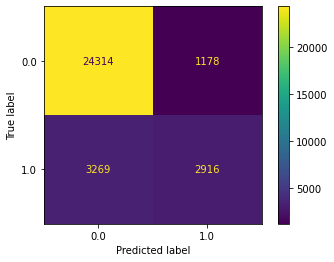

In [31]:
xgb = XGBClassifier(eval_metric = "logloss")
plot_result(xgb, "xgb")

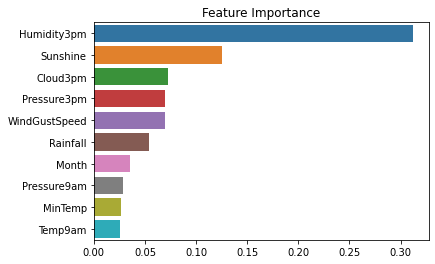

Top 10 Feature Importance for XGBClassifier

Humidity3pm      0.311828
Sunshine         0.125282
Cloud3pm         0.072378
Pressure3pm      0.069459
WindGustSpeed    0.069187
Rainfall         0.054320
Month            0.035667
Pressure9am      0.028597
MinTemp          0.026442
Temp9am          0.025958
dtype: float32


In [32]:
plot_feature_importances(xgb)

### 10-LightGBM

In [33]:
from lightgbm import LGBMClassifier

Average Balanced Accuracy (CV=10), Test Set: 0.7050566974878006
Average Balanced Accuracy (CV=10), Training Set:  0.7042880705872216
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     25492
         1.0       0.72      0.46      0.56      6185

    accuracy                           0.86     31677
   macro avg       0.80      0.71      0.74     31677
weighted avg       0.85      0.86      0.85     31677



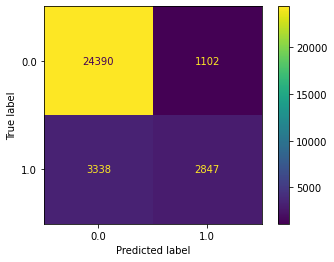

In [34]:
lgb = LGBMClassifier()
plot_result(lgb, "lgb")

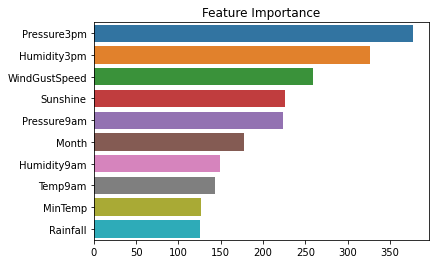

Top 10 Feature Importance for LGBMClassifier

Pressure3pm      377
Humidity3pm      326
WindGustSpeed    259
Sunshine         226
Pressure9am      224
Month            178
Humidity9am      149
Temp9am          143
MinTemp          127
Rainfall         126
dtype: int32


In [35]:
plot_feature_importances(lgb)

### 11-Catboost

In [38]:
from catboost import CatBoostClassifier, Pool

Learning rate set to 0.072025
0:	learn: 0.6403546	total: 175ms	remaining: 2m 55s
1:	learn: 0.5926249	total: 195ms	remaining: 1m 37s
2:	learn: 0.5550257	total: 217ms	remaining: 1m 11s
3:	learn: 0.5235524	total: 233ms	remaining: 58.1s
4:	learn: 0.4956017	total: 250ms	remaining: 49.7s
5:	learn: 0.4732240	total: 265ms	remaining: 43.9s
6:	learn: 0.4552750	total: 281ms	remaining: 39.9s
7:	learn: 0.4394894	total: 298ms	remaining: 37s
8:	learn: 0.4261843	total: 314ms	remaining: 34.6s
9:	learn: 0.4165239	total: 330ms	remaining: 32.7s
10:	learn: 0.4069567	total: 346ms	remaining: 31.1s
11:	learn: 0.3992669	total: 362ms	remaining: 29.8s
12:	learn: 0.3925454	total: 378ms	remaining: 28.7s
13:	learn: 0.3872681	total: 400ms	remaining: 28.1s
14:	learn: 0.3827066	total: 418ms	remaining: 27.4s
15:	learn: 0.3789557	total: 434ms	remaining: 26.7s
16:	learn: 0.3753264	total: 451ms	remaining: 26.1s
17:	learn: 0.3720042	total: 465ms	remaining: 25.4s
18:	learn: 0.3692164	total: 482ms	remaining: 24.9s
19:	learn:

164:	learn: 0.3260032	total: 3.34s	remaining: 16.9s
165:	learn: 0.3259231	total: 3.36s	remaining: 16.9s
166:	learn: 0.3258348	total: 3.39s	remaining: 16.9s
167:	learn: 0.3257413	total: 3.41s	remaining: 16.9s
168:	learn: 0.3256215	total: 3.44s	remaining: 16.9s
169:	learn: 0.3255245	total: 3.46s	remaining: 16.9s
170:	learn: 0.3253619	total: 3.49s	remaining: 16.9s
171:	learn: 0.3252451	total: 3.51s	remaining: 16.9s
172:	learn: 0.3251474	total: 3.54s	remaining: 16.9s
173:	learn: 0.3250278	total: 3.56s	remaining: 16.9s
174:	learn: 0.3249183	total: 3.58s	remaining: 16.9s
175:	learn: 0.3248131	total: 3.6s	remaining: 16.8s
176:	learn: 0.3247233	total: 3.62s	remaining: 16.8s
177:	learn: 0.3246262	total: 3.63s	remaining: 16.8s
178:	learn: 0.3245099	total: 3.65s	remaining: 16.7s
179:	learn: 0.3244125	total: 3.67s	remaining: 16.7s
180:	learn: 0.3243017	total: 3.69s	remaining: 16.7s
181:	learn: 0.3242144	total: 3.7s	remaining: 16.6s
182:	learn: 0.3241090	total: 3.72s	remaining: 16.6s
183:	learn: 0.

323:	learn: 0.3116746	total: 6.43s	remaining: 13.4s
324:	learn: 0.3115932	total: 6.45s	remaining: 13.4s
325:	learn: 0.3114778	total: 6.47s	remaining: 13.4s
326:	learn: 0.3114021	total: 6.49s	remaining: 13.4s
327:	learn: 0.3113475	total: 6.5s	remaining: 13.3s
328:	learn: 0.3113039	total: 6.52s	remaining: 13.3s
329:	learn: 0.3112126	total: 6.54s	remaining: 13.3s
330:	learn: 0.3111298	total: 6.56s	remaining: 13.3s
331:	learn: 0.3110783	total: 6.57s	remaining: 13.2s
332:	learn: 0.3110247	total: 6.59s	remaining: 13.2s
333:	learn: 0.3109500	total: 6.61s	remaining: 13.2s
334:	learn: 0.3108837	total: 6.62s	remaining: 13.1s
335:	learn: 0.3108345	total: 6.64s	remaining: 13.1s
336:	learn: 0.3107633	total: 6.67s	remaining: 13.1s
337:	learn: 0.3106842	total: 6.68s	remaining: 13.1s
338:	learn: 0.3106122	total: 6.7s	remaining: 13.1s
339:	learn: 0.3105188	total: 6.72s	remaining: 13s
340:	learn: 0.3104630	total: 6.74s	remaining: 13s
341:	learn: 0.3104086	total: 6.75s	remaining: 13s
342:	learn: 0.310358

485:	learn: 0.3008624	total: 9.38s	remaining: 9.92s
486:	learn: 0.3007917	total: 9.4s	remaining: 9.9s
487:	learn: 0.3007207	total: 9.42s	remaining: 9.89s
488:	learn: 0.3006448	total: 9.44s	remaining: 9.87s
489:	learn: 0.3006012	total: 9.46s	remaining: 9.84s
490:	learn: 0.3005760	total: 9.47s	remaining: 9.82s
491:	learn: 0.3005158	total: 9.49s	remaining: 9.8s
492:	learn: 0.3004715	total: 9.51s	remaining: 9.78s
493:	learn: 0.3004061	total: 9.52s	remaining: 9.76s
494:	learn: 0.3003359	total: 9.54s	remaining: 9.73s
495:	learn: 0.3002823	total: 9.56s	remaining: 9.71s
496:	learn: 0.3002499	total: 9.57s	remaining: 9.69s
497:	learn: 0.3002471	total: 9.59s	remaining: 9.67s
498:	learn: 0.3001705	total: 9.62s	remaining: 9.65s
499:	learn: 0.3001050	total: 9.63s	remaining: 9.63s
500:	learn: 0.3000446	total: 9.65s	remaining: 9.61s
501:	learn: 0.3000315	total: 9.67s	remaining: 9.59s
502:	learn: 0.2999707	total: 9.69s	remaining: 9.57s
503:	learn: 0.2999293	total: 9.7s	remaining: 9.55s
504:	learn: 0.29

645:	learn: 0.2921970	total: 12.5s	remaining: 6.87s
646:	learn: 0.2921601	total: 12.6s	remaining: 6.85s
647:	learn: 0.2921022	total: 12.6s	remaining: 6.83s
648:	learn: 0.2920745	total: 12.6s	remaining: 6.81s
649:	learn: 0.2920203	total: 12.6s	remaining: 6.79s
650:	learn: 0.2919606	total: 12.6s	remaining: 6.77s
651:	learn: 0.2919141	total: 12.6s	remaining: 6.75s
652:	learn: 0.2918638	total: 12.7s	remaining: 6.73s
653:	learn: 0.2918289	total: 12.7s	remaining: 6.71s
654:	learn: 0.2917920	total: 12.7s	remaining: 6.68s
655:	learn: 0.2917425	total: 12.7s	remaining: 6.66s
656:	learn: 0.2917018	total: 12.7s	remaining: 6.64s
657:	learn: 0.2916674	total: 12.7s	remaining: 6.63s
658:	learn: 0.2916198	total: 12.8s	remaining: 6.6s
659:	learn: 0.2915668	total: 12.8s	remaining: 6.58s
660:	learn: 0.2915175	total: 12.8s	remaining: 6.56s
661:	learn: 0.2914793	total: 12.8s	remaining: 6.54s
662:	learn: 0.2914329	total: 12.8s	remaining: 6.52s
663:	learn: 0.2913943	total: 12.8s	remaining: 6.5s
664:	learn: 0.

809:	learn: 0.2841322	total: 15.3s	remaining: 3.59s
810:	learn: 0.2840722	total: 15.3s	remaining: 3.57s
811:	learn: 0.2840221	total: 15.3s	remaining: 3.55s
812:	learn: 0.2839843	total: 15.3s	remaining: 3.53s
813:	learn: 0.2839390	total: 15.4s	remaining: 3.51s
814:	learn: 0.2838778	total: 15.4s	remaining: 3.49s
815:	learn: 0.2838489	total: 15.4s	remaining: 3.47s
816:	learn: 0.2837803	total: 15.4s	remaining: 3.45s
817:	learn: 0.2837527	total: 15.4s	remaining: 3.43s
818:	learn: 0.2836902	total: 15.5s	remaining: 3.41s
819:	learn: 0.2836480	total: 15.5s	remaining: 3.4s
820:	learn: 0.2836006	total: 15.5s	remaining: 3.38s
821:	learn: 0.2835534	total: 15.5s	remaining: 3.36s
822:	learn: 0.2834819	total: 15.5s	remaining: 3.34s
823:	learn: 0.2834328	total: 15.5s	remaining: 3.32s
824:	learn: 0.2833723	total: 15.6s	remaining: 3.3s
825:	learn: 0.2833433	total: 15.6s	remaining: 3.28s
826:	learn: 0.2832897	total: 15.6s	remaining: 3.26s
827:	learn: 0.2832492	total: 15.6s	remaining: 3.24s
828:	learn: 0.

977:	learn: 0.2763190	total: 18.4s	remaining: 414ms
978:	learn: 0.2762542	total: 18.4s	remaining: 396ms
979:	learn: 0.2762187	total: 18.5s	remaining: 377ms
980:	learn: 0.2761965	total: 18.5s	remaining: 358ms
981:	learn: 0.2761454	total: 18.5s	remaining: 339ms
982:	learn: 0.2761149	total: 18.5s	remaining: 320ms
983:	learn: 0.2760794	total: 18.5s	remaining: 301ms
984:	learn: 0.2760389	total: 18.5s	remaining: 282ms
985:	learn: 0.2759743	total: 18.6s	remaining: 264ms
986:	learn: 0.2759197	total: 18.6s	remaining: 245ms
987:	learn: 0.2758772	total: 18.6s	remaining: 226ms
988:	learn: 0.2758452	total: 18.6s	remaining: 207ms
989:	learn: 0.2758120	total: 18.6s	remaining: 188ms
990:	learn: 0.2757448	total: 18.6s	remaining: 169ms
991:	learn: 0.2757006	total: 18.7s	remaining: 151ms
992:	learn: 0.2756527	total: 18.7s	remaining: 132ms
993:	learn: 0.2755953	total: 18.7s	remaining: 113ms
994:	learn: 0.2755644	total: 18.7s	remaining: 94.1ms
995:	learn: 0.2755151	total: 18.7s	remaining: 75.2ms
996:	learn

141:	learn: 0.3293894	total: 2.48s	remaining: 15s
142:	learn: 0.3292823	total: 2.5s	remaining: 15s
143:	learn: 0.3291828	total: 2.52s	remaining: 15s
144:	learn: 0.3291007	total: 2.53s	remaining: 14.9s
145:	learn: 0.3290085	total: 2.55s	remaining: 14.9s
146:	learn: 0.3289287	total: 2.57s	remaining: 14.9s
147:	learn: 0.3287904	total: 2.58s	remaining: 14.9s
148:	learn: 0.3286783	total: 2.6s	remaining: 14.8s
149:	learn: 0.3285207	total: 2.62s	remaining: 14.8s
150:	learn: 0.3284168	total: 2.63s	remaining: 14.8s
151:	learn: 0.3282604	total: 2.65s	remaining: 14.8s
152:	learn: 0.3281796	total: 2.66s	remaining: 14.7s
153:	learn: 0.3280755	total: 2.68s	remaining: 14.7s
154:	learn: 0.3279905	total: 2.7s	remaining: 14.7s
155:	learn: 0.3278678	total: 2.71s	remaining: 14.7s
156:	learn: 0.3277724	total: 2.73s	remaining: 14.7s
157:	learn: 0.3276442	total: 2.75s	remaining: 14.6s
158:	learn: 0.3275257	total: 2.77s	remaining: 14.6s
159:	learn: 0.3274049	total: 2.78s	remaining: 14.6s
160:	learn: 0.3273124

304:	learn: 0.3130097	total: 5.45s	remaining: 12.4s
305:	learn: 0.3129220	total: 5.46s	remaining: 12.4s
306:	learn: 0.3128137	total: 5.48s	remaining: 12.4s
307:	learn: 0.3127430	total: 5.5s	remaining: 12.4s
308:	learn: 0.3126669	total: 5.53s	remaining: 12.4s
309:	learn: 0.3125996	total: 5.55s	remaining: 12.3s
310:	learn: 0.3124886	total: 5.57s	remaining: 12.3s
311:	learn: 0.3124280	total: 5.6s	remaining: 12.3s
312:	learn: 0.3123515	total: 5.62s	remaining: 12.3s
313:	learn: 0.3122810	total: 5.65s	remaining: 12.3s
314:	learn: 0.3122017	total: 5.67s	remaining: 12.3s
315:	learn: 0.3120981	total: 5.7s	remaining: 12.3s
316:	learn: 0.3120154	total: 5.72s	remaining: 12.3s
317:	learn: 0.3119194	total: 5.74s	remaining: 12.3s
318:	learn: 0.3118225	total: 5.77s	remaining: 12.3s
319:	learn: 0.3117384	total: 5.79s	remaining: 12.3s
320:	learn: 0.3116715	total: 5.82s	remaining: 12.3s
321:	learn: 0.3115929	total: 5.84s	remaining: 12.3s
322:	learn: 0.3115293	total: 5.86s	remaining: 12.3s
323:	learn: 0.3

470:	learn: 0.3013092	total: 8.57s	remaining: 9.62s
471:	learn: 0.3012527	total: 8.59s	remaining: 9.61s
472:	learn: 0.3011616	total: 8.61s	remaining: 9.59s
473:	learn: 0.3011108	total: 8.63s	remaining: 9.57s
474:	learn: 0.3010119	total: 8.65s	remaining: 9.56s
475:	learn: 0.3009501	total: 8.67s	remaining: 9.54s
476:	learn: 0.3009066	total: 8.69s	remaining: 9.52s
477:	learn: 0.3008553	total: 8.7s	remaining: 9.51s
478:	learn: 0.3007951	total: 8.72s	remaining: 9.49s
479:	learn: 0.3007240	total: 8.74s	remaining: 9.47s
480:	learn: 0.3006456	total: 8.76s	remaining: 9.45s
481:	learn: 0.3005814	total: 8.78s	remaining: 9.44s
482:	learn: 0.3005132	total: 8.8s	remaining: 9.42s
483:	learn: 0.3004569	total: 8.81s	remaining: 9.4s
484:	learn: 0.3004092	total: 8.83s	remaining: 9.38s
485:	learn: 0.3003388	total: 8.85s	remaining: 9.36s
486:	learn: 0.3002704	total: 8.87s	remaining: 9.34s
487:	learn: 0.3002542	total: 8.88s	remaining: 9.32s
488:	learn: 0.3002133	total: 8.9s	remaining: 9.3s
489:	learn: 0.300

634:	learn: 0.2921163	total: 11.5s	remaining: 6.63s
635:	learn: 0.2920628	total: 11.6s	remaining: 6.62s
636:	learn: 0.2920157	total: 11.6s	remaining: 6.6s
637:	learn: 0.2919914	total: 11.6s	remaining: 6.58s
638:	learn: 0.2919611	total: 11.6s	remaining: 6.56s
639:	learn: 0.2919099	total: 11.6s	remaining: 6.54s
640:	learn: 0.2918452	total: 11.7s	remaining: 6.53s
641:	learn: 0.2917813	total: 11.7s	remaining: 6.51s
642:	learn: 0.2917348	total: 11.7s	remaining: 6.49s
643:	learn: 0.2916785	total: 11.7s	remaining: 6.47s
644:	learn: 0.2916246	total: 11.7s	remaining: 6.45s
645:	learn: 0.2915810	total: 11.7s	remaining: 6.43s
646:	learn: 0.2915422	total: 11.8s	remaining: 6.42s
647:	learn: 0.2914890	total: 11.8s	remaining: 6.4s
648:	learn: 0.2914307	total: 11.8s	remaining: 6.38s
649:	learn: 0.2913495	total: 11.8s	remaining: 6.36s
650:	learn: 0.2913140	total: 11.8s	remaining: 6.34s
651:	learn: 0.2912549	total: 11.8s	remaining: 6.33s
652:	learn: 0.2912000	total: 11.9s	remaining: 6.31s
653:	learn: 0.

802:	learn: 0.2835628	total: 14.9s	remaining: 3.65s
803:	learn: 0.2835153	total: 14.9s	remaining: 3.63s
804:	learn: 0.2834649	total: 14.9s	remaining: 3.62s
805:	learn: 0.2834340	total: 14.9s	remaining: 3.6s
806:	learn: 0.2833667	total: 15s	remaining: 3.58s
807:	learn: 0.2833295	total: 15s	remaining: 3.56s
808:	learn: 0.2832962	total: 15s	remaining: 3.54s
809:	learn: 0.2832620	total: 15s	remaining: 3.52s
810:	learn: 0.2832075	total: 15s	remaining: 3.51s
811:	learn: 0.2831579	total: 15.1s	remaining: 3.49s
812:	learn: 0.2831168	total: 15.1s	remaining: 3.47s
813:	learn: 0.2830856	total: 15.1s	remaining: 3.45s
814:	learn: 0.2830210	total: 15.1s	remaining: 3.43s
815:	learn: 0.2829855	total: 15.1s	remaining: 3.41s
816:	learn: 0.2829153	total: 15.2s	remaining: 3.4s
817:	learn: 0.2829091	total: 15.2s	remaining: 3.38s
818:	learn: 0.2828628	total: 15.2s	remaining: 3.36s
819:	learn: 0.2828441	total: 15.2s	remaining: 3.34s
820:	learn: 0.2828176	total: 15.2s	remaining: 3.32s
821:	learn: 0.2827732	to

970:	learn: 0.2753924	total: 18s	remaining: 539ms
971:	learn: 0.2753362	total: 18.1s	remaining: 520ms
972:	learn: 0.2753051	total: 18.1s	remaining: 502ms
973:	learn: 0.2752611	total: 18.1s	remaining: 483ms
974:	learn: 0.2752141	total: 18.1s	remaining: 464ms
975:	learn: 0.2751630	total: 18.1s	remaining: 446ms
976:	learn: 0.2751087	total: 18.1s	remaining: 427ms
977:	learn: 0.2750575	total: 18.2s	remaining: 409ms
978:	learn: 0.2750076	total: 18.2s	remaining: 390ms
979:	learn: 0.2749740	total: 18.2s	remaining: 372ms
980:	learn: 0.2749322	total: 18.2s	remaining: 353ms
981:	learn: 0.2749223	total: 18.2s	remaining: 334ms
982:	learn: 0.2748607	total: 18.3s	remaining: 316ms
983:	learn: 0.2748062	total: 18.3s	remaining: 297ms
984:	learn: 0.2747478	total: 18.3s	remaining: 279ms
985:	learn: 0.2746934	total: 18.3s	remaining: 260ms
986:	learn: 0.2746068	total: 18.3s	remaining: 241ms
987:	learn: 0.2745379	total: 18.4s	remaining: 223ms
988:	learn: 0.2744603	total: 18.4s	remaining: 204ms
989:	learn: 0.

138:	learn: 0.3292852	total: 2.5s	remaining: 15.5s
139:	learn: 0.3291485	total: 2.52s	remaining: 15.5s
140:	learn: 0.3290225	total: 2.54s	remaining: 15.5s
141:	learn: 0.3288895	total: 2.56s	remaining: 15.5s
142:	learn: 0.3287794	total: 2.58s	remaining: 15.4s
143:	learn: 0.3286545	total: 2.6s	remaining: 15.4s
144:	learn: 0.3285912	total: 2.61s	remaining: 15.4s
145:	learn: 0.3284830	total: 2.63s	remaining: 15.4s
146:	learn: 0.3283738	total: 2.65s	remaining: 15.3s
147:	learn: 0.3282897	total: 2.66s	remaining: 15.3s
148:	learn: 0.3281648	total: 2.68s	remaining: 15.3s
149:	learn: 0.3280416	total: 2.7s	remaining: 15.3s
150:	learn: 0.3279220	total: 2.72s	remaining: 15.3s
151:	learn: 0.3278492	total: 2.74s	remaining: 15.3s
152:	learn: 0.3277222	total: 2.76s	remaining: 15.3s
153:	learn: 0.3276191	total: 2.78s	remaining: 15.3s
154:	learn: 0.3275261	total: 2.79s	remaining: 15.2s
155:	learn: 0.3274159	total: 2.83s	remaining: 15.3s
156:	learn: 0.3272820	total: 2.86s	remaining: 15.3s
157:	learn: 0.3

302:	learn: 0.3129761	total: 5.46s	remaining: 12.6s
303:	learn: 0.3128822	total: 5.47s	remaining: 12.5s
304:	learn: 0.3127798	total: 5.49s	remaining: 12.5s
305:	learn: 0.3126727	total: 5.51s	remaining: 12.5s
306:	learn: 0.3125893	total: 5.53s	remaining: 12.5s
307:	learn: 0.3125076	total: 5.54s	remaining: 12.5s
308:	learn: 0.3124261	total: 5.56s	remaining: 12.4s
309:	learn: 0.3123387	total: 5.58s	remaining: 12.4s
310:	learn: 0.3122280	total: 5.59s	remaining: 12.4s
311:	learn: 0.3121519	total: 5.61s	remaining: 12.4s
312:	learn: 0.3120711	total: 5.63s	remaining: 12.4s
313:	learn: 0.3119771	total: 5.64s	remaining: 12.3s
314:	learn: 0.3118534	total: 5.67s	remaining: 12.3s
315:	learn: 0.3117699	total: 5.69s	remaining: 12.3s
316:	learn: 0.3117035	total: 5.7s	remaining: 12.3s
317:	learn: 0.3116065	total: 5.72s	remaining: 12.3s
318:	learn: 0.3114944	total: 5.75s	remaining: 12.3s
319:	learn: 0.3114351	total: 5.76s	remaining: 12.2s
320:	learn: 0.3113524	total: 5.78s	remaining: 12.2s
321:	learn: 0

470:	learn: 0.3006011	total: 8.48s	remaining: 9.52s
471:	learn: 0.3005541	total: 8.5s	remaining: 9.51s
472:	learn: 0.3004885	total: 8.52s	remaining: 9.49s
473:	learn: 0.3004017	total: 8.53s	remaining: 9.47s
474:	learn: 0.3003426	total: 8.55s	remaining: 9.45s
475:	learn: 0.3002852	total: 8.57s	remaining: 9.43s
476:	learn: 0.3002391	total: 8.59s	remaining: 9.41s
477:	learn: 0.3001639	total: 8.6s	remaining: 9.4s
478:	learn: 0.3000964	total: 8.62s	remaining: 9.38s
479:	learn: 0.3000507	total: 8.64s	remaining: 9.36s
480:	learn: 0.2999807	total: 8.66s	remaining: 9.35s
481:	learn: 0.2999037	total: 8.68s	remaining: 9.33s
482:	learn: 0.2998328	total: 8.7s	remaining: 9.31s
483:	learn: 0.2997670	total: 8.72s	remaining: 9.3s
484:	learn: 0.2996646	total: 8.74s	remaining: 9.28s
485:	learn: 0.2995795	total: 8.76s	remaining: 9.26s
486:	learn: 0.2995058	total: 8.78s	remaining: 9.24s
487:	learn: 0.2994444	total: 8.79s	remaining: 9.22s
488:	learn: 0.2993814	total: 8.81s	remaining: 9.21s
489:	learn: 0.299

632:	learn: 0.2912238	total: 11.4s	remaining: 6.62s
633:	learn: 0.2911640	total: 11.4s	remaining: 6.6s
634:	learn: 0.2911239	total: 11.5s	remaining: 6.58s
635:	learn: 0.2910777	total: 11.5s	remaining: 6.56s
636:	learn: 0.2910379	total: 11.5s	remaining: 6.55s
637:	learn: 0.2909872	total: 11.5s	remaining: 6.53s
638:	learn: 0.2909213	total: 11.5s	remaining: 6.51s
639:	learn: 0.2908600	total: 11.5s	remaining: 6.49s
640:	learn: 0.2907912	total: 11.6s	remaining: 6.47s
641:	learn: 0.2907439	total: 11.6s	remaining: 6.46s
642:	learn: 0.2906749	total: 11.6s	remaining: 6.44s
643:	learn: 0.2906152	total: 11.6s	remaining: 6.42s
644:	learn: 0.2905480	total: 11.6s	remaining: 6.41s
645:	learn: 0.2905040	total: 11.7s	remaining: 6.39s
646:	learn: 0.2904727	total: 11.7s	remaining: 6.37s
647:	learn: 0.2904263	total: 11.7s	remaining: 6.35s
648:	learn: 0.2904180	total: 11.7s	remaining: 6.33s
649:	learn: 0.2903551	total: 11.7s	remaining: 6.32s
650:	learn: 0.2903176	total: 11.7s	remaining: 6.3s
651:	learn: 0.

801:	learn: 0.2826443	total: 14.7s	remaining: 3.64s
802:	learn: 0.2826144	total: 14.8s	remaining: 3.62s
803:	learn: 0.2825617	total: 14.8s	remaining: 3.6s
804:	learn: 0.2824960	total: 14.8s	remaining: 3.58s
805:	learn: 0.2824502	total: 14.8s	remaining: 3.57s
806:	learn: 0.2823901	total: 14.8s	remaining: 3.55s
807:	learn: 0.2823595	total: 14.9s	remaining: 3.53s
808:	learn: 0.2823242	total: 14.9s	remaining: 3.51s
809:	learn: 0.2822972	total: 14.9s	remaining: 3.49s
810:	learn: 0.2822547	total: 14.9s	remaining: 3.48s
811:	learn: 0.2822095	total: 14.9s	remaining: 3.46s
812:	learn: 0.2821460	total: 15s	remaining: 3.44s
813:	learn: 0.2821049	total: 15s	remaining: 3.42s
814:	learn: 0.2820672	total: 15s	remaining: 3.4s
815:	learn: 0.2820111	total: 15s	remaining: 3.38s
816:	learn: 0.2819424	total: 15s	remaining: 3.37s
817:	learn: 0.2818892	total: 15.1s	remaining: 3.35s
818:	learn: 0.2818303	total: 15.1s	remaining: 3.33s
819:	learn: 0.2817614	total: 15.1s	remaining: 3.31s
820:	learn: 0.2816927	to

964:	learn: 0.2749499	total: 17.9s	remaining: 649ms
965:	learn: 0.2748957	total: 17.9s	remaining: 630ms
966:	learn: 0.2748537	total: 17.9s	remaining: 612ms
967:	learn: 0.2748176	total: 17.9s	remaining: 593ms
968:	learn: 0.2747537	total: 18s	remaining: 575ms
969:	learn: 0.2747419	total: 18s	remaining: 556ms
970:	learn: 0.2747132	total: 18s	remaining: 538ms
971:	learn: 0.2746653	total: 18s	remaining: 519ms
972:	learn: 0.2746174	total: 18s	remaining: 501ms
973:	learn: 0.2745738	total: 18.1s	remaining: 482ms
974:	learn: 0.2745370	total: 18.1s	remaining: 463ms
975:	learn: 0.2744981	total: 18.1s	remaining: 445ms
976:	learn: 0.2744509	total: 18.1s	remaining: 426ms
977:	learn: 0.2744046	total: 18.1s	remaining: 408ms
978:	learn: 0.2743659	total: 18.2s	remaining: 389ms
979:	learn: 0.2743261	total: 18.2s	remaining: 371ms
980:	learn: 0.2742858	total: 18.2s	remaining: 352ms
981:	learn: 0.2742563	total: 18.2s	remaining: 334ms
982:	learn: 0.2742014	total: 18.2s	remaining: 315ms
983:	learn: 0.2741575	

131:	learn: 0.3301125	total: 2.49s	remaining: 16.4s
132:	learn: 0.3299608	total: 2.51s	remaining: 16.4s
133:	learn: 0.3298577	total: 2.53s	remaining: 16.3s
134:	learn: 0.3297653	total: 2.54s	remaining: 16.3s
135:	learn: 0.3296716	total: 2.56s	remaining: 16.3s
136:	learn: 0.3295946	total: 2.58s	remaining: 16.2s
137:	learn: 0.3295189	total: 2.6s	remaining: 16.2s
138:	learn: 0.3293954	total: 2.62s	remaining: 16.2s
139:	learn: 0.3292647	total: 2.63s	remaining: 16.2s
140:	learn: 0.3291716	total: 2.65s	remaining: 16.2s
141:	learn: 0.3290588	total: 2.67s	remaining: 16.1s
142:	learn: 0.3289397	total: 2.69s	remaining: 16.2s
143:	learn: 0.3288366	total: 2.71s	remaining: 16.1s
144:	learn: 0.3286898	total: 2.73s	remaining: 16.1s
145:	learn: 0.3286077	total: 2.75s	remaining: 16.1s
146:	learn: 0.3284533	total: 2.77s	remaining: 16.1s
147:	learn: 0.3283388	total: 2.79s	remaining: 16s
148:	learn: 0.3282307	total: 2.81s	remaining: 16s
149:	learn: 0.3281082	total: 2.83s	remaining: 16s
150:	learn: 0.32799

297:	learn: 0.3131969	total: 5.64s	remaining: 13.3s
298:	learn: 0.3131277	total: 5.67s	remaining: 13.3s
299:	learn: 0.3130298	total: 5.68s	remaining: 13.3s
300:	learn: 0.3129444	total: 5.7s	remaining: 13.2s
301:	learn: 0.3128583	total: 5.72s	remaining: 13.2s
302:	learn: 0.3127903	total: 5.74s	remaining: 13.2s
303:	learn: 0.3126710	total: 5.76s	remaining: 13.2s
304:	learn: 0.3125948	total: 5.78s	remaining: 13.2s
305:	learn: 0.3125239	total: 5.8s	remaining: 13.2s
306:	learn: 0.3123984	total: 5.83s	remaining: 13.1s
307:	learn: 0.3123080	total: 5.85s	remaining: 13.1s
308:	learn: 0.3122254	total: 5.87s	remaining: 13.1s
309:	learn: 0.3121520	total: 5.89s	remaining: 13.1s
310:	learn: 0.3120826	total: 5.91s	remaining: 13.1s
311:	learn: 0.3120107	total: 5.93s	remaining: 13.1s
312:	learn: 0.3119366	total: 5.95s	remaining: 13.1s
313:	learn: 0.3118792	total: 5.96s	remaining: 13s
314:	learn: 0.3118232	total: 5.98s	remaining: 13s
315:	learn: 0.3117094	total: 6s	remaining: 13s
316:	learn: 0.3116406	t

463:	learn: 0.3012627	total: 9s	remaining: 10.4s
464:	learn: 0.3012086	total: 9.02s	remaining: 10.4s
465:	learn: 0.3011480	total: 9.04s	remaining: 10.4s
466:	learn: 0.3010368	total: 9.06s	remaining: 10.3s
467:	learn: 0.3010018	total: 9.08s	remaining: 10.3s
468:	learn: 0.3009080	total: 9.1s	remaining: 10.3s
469:	learn: 0.3008327	total: 9.12s	remaining: 10.3s
470:	learn: 0.3007859	total: 9.14s	remaining: 10.3s
471:	learn: 0.3007146	total: 9.16s	remaining: 10.2s
472:	learn: 0.3006700	total: 9.18s	remaining: 10.2s
473:	learn: 0.3006097	total: 9.2s	remaining: 10.2s
474:	learn: 0.3005482	total: 9.22s	remaining: 10.2s
475:	learn: 0.3005046	total: 9.25s	remaining: 10.2s
476:	learn: 0.3004582	total: 9.27s	remaining: 10.2s
477:	learn: 0.3003694	total: 9.29s	remaining: 10.1s
478:	learn: 0.3003255	total: 9.31s	remaining: 10.1s
479:	learn: 0.3002810	total: 9.33s	remaining: 10.1s
480:	learn: 0.3002373	total: 9.35s	remaining: 10.1s
481:	learn: 0.3001552	total: 9.37s	remaining: 10.1s
482:	learn: 0.300

631:	learn: 0.2914135	total: 12.5s	remaining: 7.29s
632:	learn: 0.2913501	total: 12.5s	remaining: 7.28s
633:	learn: 0.2912946	total: 12.6s	remaining: 7.25s
634:	learn: 0.2912303	total: 12.6s	remaining: 7.23s
635:	learn: 0.2911812	total: 12.6s	remaining: 7.21s
636:	learn: 0.2911168	total: 12.6s	remaining: 7.19s
637:	learn: 0.2910859	total: 12.6s	remaining: 7.17s
638:	learn: 0.2910159	total: 12.7s	remaining: 7.15s
639:	learn: 0.2909596	total: 12.7s	remaining: 7.13s
640:	learn: 0.2909326	total: 12.7s	remaining: 7.11s
641:	learn: 0.2908788	total: 12.7s	remaining: 7.09s
642:	learn: 0.2908304	total: 12.7s	remaining: 7.07s
643:	learn: 0.2907708	total: 12.8s	remaining: 7.05s
644:	learn: 0.2907372	total: 12.8s	remaining: 7.03s
645:	learn: 0.2906847	total: 12.8s	remaining: 7.01s
646:	learn: 0.2906076	total: 12.8s	remaining: 6.99s
647:	learn: 0.2905320	total: 12.8s	remaining: 6.97s
648:	learn: 0.2904880	total: 12.9s	remaining: 6.95s
649:	learn: 0.2904558	total: 12.9s	remaining: 6.93s
650:	learn: 

792:	learn: 0.2828774	total: 15.7s	remaining: 4.1s
793:	learn: 0.2828388	total: 15.7s	remaining: 4.08s
794:	learn: 0.2827779	total: 15.8s	remaining: 4.06s
795:	learn: 0.2827454	total: 15.8s	remaining: 4.04s
796:	learn: 0.2826977	total: 15.8s	remaining: 4.02s
797:	learn: 0.2826417	total: 15.8s	remaining: 4s
798:	learn: 0.2825596	total: 15.8s	remaining: 3.98s
799:	learn: 0.2825106	total: 15.9s	remaining: 3.96s
800:	learn: 0.2824432	total: 15.9s	remaining: 3.95s
801:	learn: 0.2824063	total: 15.9s	remaining: 3.93s
802:	learn: 0.2823875	total: 15.9s	remaining: 3.91s
803:	learn: 0.2823405	total: 16s	remaining: 3.89s
804:	learn: 0.2822609	total: 16s	remaining: 3.87s
805:	learn: 0.2821969	total: 16s	remaining: 3.85s
806:	learn: 0.2821423	total: 16s	remaining: 3.83s
807:	learn: 0.2820761	total: 16.1s	remaining: 3.82s
808:	learn: 0.2820356	total: 16.1s	remaining: 3.8s
809:	learn: 0.2819827	total: 16.1s	remaining: 3.78s
810:	learn: 0.2819305	total: 16.1s	remaining: 3.76s
811:	learn: 0.2818830	tot

959:	learn: 0.2748721	total: 19.2s	remaining: 798ms
960:	learn: 0.2748364	total: 19.2s	remaining: 778ms
961:	learn: 0.2747808	total: 19.2s	remaining: 758ms
962:	learn: 0.2747393	total: 19.2s	remaining: 738ms
963:	learn: 0.2746870	total: 19.2s	remaining: 718ms
964:	learn: 0.2746584	total: 19.3s	remaining: 698ms
965:	learn: 0.2746186	total: 19.3s	remaining: 678ms
966:	learn: 0.2745724	total: 19.3s	remaining: 658ms
967:	learn: 0.2745173	total: 19.3s	remaining: 638ms
968:	learn: 0.2744485	total: 19.3s	remaining: 618ms
969:	learn: 0.2744066	total: 19.3s	remaining: 598ms
970:	learn: 0.2743506	total: 19.4s	remaining: 579ms
971:	learn: 0.2742898	total: 19.4s	remaining: 559ms
972:	learn: 0.2742374	total: 19.4s	remaining: 539ms
973:	learn: 0.2741945	total: 19.4s	remaining: 519ms
974:	learn: 0.2741334	total: 19.5s	remaining: 499ms
975:	learn: 0.2740739	total: 19.5s	remaining: 479ms
976:	learn: 0.2740117	total: 19.5s	remaining: 459ms
977:	learn: 0.2739412	total: 19.5s	remaining: 439ms
978:	learn: 

120:	learn: 0.3321160	total: 2.14s	remaining: 15.6s
121:	learn: 0.3319931	total: 2.16s	remaining: 15.6s
122:	learn: 0.3318984	total: 2.18s	remaining: 15.6s
123:	learn: 0.3317756	total: 2.2s	remaining: 15.5s
124:	learn: 0.3316463	total: 2.22s	remaining: 15.5s
125:	learn: 0.3315392	total: 2.23s	remaining: 15.5s
126:	learn: 0.3313968	total: 2.25s	remaining: 15.5s
127:	learn: 0.3313165	total: 2.27s	remaining: 15.5s
128:	learn: 0.3312126	total: 2.29s	remaining: 15.5s
129:	learn: 0.3310790	total: 2.31s	remaining: 15.4s
130:	learn: 0.3309699	total: 2.33s	remaining: 15.4s
131:	learn: 0.3308761	total: 2.34s	remaining: 15.4s
132:	learn: 0.3307629	total: 2.36s	remaining: 15.4s
133:	learn: 0.3306267	total: 2.38s	remaining: 15.4s
134:	learn: 0.3305275	total: 2.4s	remaining: 15.4s
135:	learn: 0.3304557	total: 2.42s	remaining: 15.4s
136:	learn: 0.3303499	total: 2.44s	remaining: 15.3s
137:	learn: 0.3302641	total: 2.45s	remaining: 15.3s
138:	learn: 0.3301547	total: 2.47s	remaining: 15.3s
139:	learn: 0.

285:	learn: 0.3151837	total: 5.31s	remaining: 13.3s
286:	learn: 0.3150945	total: 5.33s	remaining: 13.2s
287:	learn: 0.3150284	total: 5.35s	remaining: 13.2s
288:	learn: 0.3149480	total: 5.37s	remaining: 13.2s
289:	learn: 0.3148629	total: 5.39s	remaining: 13.2s
290:	learn: 0.3147875	total: 5.41s	remaining: 13.2s
291:	learn: 0.3146900	total: 5.42s	remaining: 13.2s
292:	learn: 0.3146015	total: 5.44s	remaining: 13.1s
293:	learn: 0.3145165	total: 5.46s	remaining: 13.1s
294:	learn: 0.3144184	total: 5.48s	remaining: 13.1s
295:	learn: 0.3143239	total: 5.5s	remaining: 13.1s
296:	learn: 0.3142292	total: 5.53s	remaining: 13.1s
297:	learn: 0.3141915	total: 5.54s	remaining: 13.1s
298:	learn: 0.3141748	total: 5.56s	remaining: 13s
299:	learn: 0.3140882	total: 5.58s	remaining: 13s
300:	learn: 0.3139591	total: 5.6s	remaining: 13s
301:	learn: 0.3138900	total: 5.62s	remaining: 13s
302:	learn: 0.3138155	total: 5.63s	remaining: 13s
303:	learn: 0.3136843	total: 5.65s	remaining: 12.9s
304:	learn: 0.3136287	to

452:	learn: 0.3029939	total: 8.61s	remaining: 10.4s
453:	learn: 0.3029359	total: 8.64s	remaining: 10.4s
454:	learn: 0.3028550	total: 8.66s	remaining: 10.4s
455:	learn: 0.3028055	total: 8.68s	remaining: 10.4s
456:	learn: 0.3027334	total: 8.7s	remaining: 10.3s
457:	learn: 0.3026523	total: 8.72s	remaining: 10.3s
458:	learn: 0.3026022	total: 8.74s	remaining: 10.3s
459:	learn: 0.3025337	total: 8.75s	remaining: 10.3s
460:	learn: 0.3024674	total: 8.77s	remaining: 10.3s
461:	learn: 0.3023807	total: 8.79s	remaining: 10.2s
462:	learn: 0.3023258	total: 8.81s	remaining: 10.2s
463:	learn: 0.3022806	total: 8.84s	remaining: 10.2s
464:	learn: 0.3022152	total: 8.86s	remaining: 10.2s
465:	learn: 0.3021594	total: 8.88s	remaining: 10.2s
466:	learn: 0.3020987	total: 8.9s	remaining: 10.2s
467:	learn: 0.3020293	total: 8.92s	remaining: 10.1s
468:	learn: 0.3019503	total: 8.94s	remaining: 10.1s
469:	learn: 0.3018812	total: 8.96s	remaining: 10.1s
470:	learn: 0.3018428	total: 8.97s	remaining: 10.1s
471:	learn: 0.

615:	learn: 0.2933134	total: 12s	remaining: 7.46s
616:	learn: 0.2932589	total: 12s	remaining: 7.45s
617:	learn: 0.2931965	total: 12s	remaining: 7.44s
618:	learn: 0.2931407	total: 12.1s	remaining: 7.42s
619:	learn: 0.2930659	total: 12.1s	remaining: 7.41s
620:	learn: 0.2930138	total: 12.1s	remaining: 7.39s
621:	learn: 0.2929643	total: 12.1s	remaining: 7.37s
622:	learn: 0.2928920	total: 12.2s	remaining: 7.35s
623:	learn: 0.2928447	total: 12.2s	remaining: 7.33s
624:	learn: 0.2927984	total: 12.2s	remaining: 7.31s
625:	learn: 0.2927440	total: 12.2s	remaining: 7.3s
626:	learn: 0.2926784	total: 12.2s	remaining: 7.28s
627:	learn: 0.2926184	total: 12.3s	remaining: 7.26s
628:	learn: 0.2925436	total: 12.3s	remaining: 7.24s
629:	learn: 0.2924921	total: 12.3s	remaining: 7.22s
630:	learn: 0.2924386	total: 12.3s	remaining: 7.2s
631:	learn: 0.2923602	total: 12.3s	remaining: 7.18s
632:	learn: 0.2922798	total: 12.3s	remaining: 7.16s
633:	learn: 0.2922342	total: 12.4s	remaining: 7.14s
634:	learn: 0.292198

782:	learn: 0.2843505	total: 15.4s	remaining: 4.26s
783:	learn: 0.2843032	total: 15.4s	remaining: 4.24s
784:	learn: 0.2842402	total: 15.4s	remaining: 4.22s
785:	learn: 0.2841817	total: 15.4s	remaining: 4.2s
786:	learn: 0.2841395	total: 15.4s	remaining: 4.18s
787:	learn: 0.2840957	total: 15.5s	remaining: 4.16s
788:	learn: 0.2840381	total: 15.5s	remaining: 4.14s
789:	learn: 0.2839835	total: 15.5s	remaining: 4.12s
790:	learn: 0.2839338	total: 15.5s	remaining: 4.1s
791:	learn: 0.2838738	total: 15.5s	remaining: 4.08s
792:	learn: 0.2838325	total: 15.6s	remaining: 4.06s
793:	learn: 0.2837574	total: 15.6s	remaining: 4.04s
794:	learn: 0.2837011	total: 15.6s	remaining: 4.02s
795:	learn: 0.2836365	total: 15.6s	remaining: 4s
796:	learn: 0.2835727	total: 15.6s	remaining: 3.98s
797:	learn: 0.2835327	total: 15.7s	remaining: 3.96s
798:	learn: 0.2834912	total: 15.7s	remaining: 3.94s
799:	learn: 0.2834237	total: 15.7s	remaining: 3.92s
800:	learn: 0.2833724	total: 15.7s	remaining: 3.9s
801:	learn: 0.2833

948:	learn: 0.2761128	total: 18.7s	remaining: 1s
949:	learn: 0.2760733	total: 18.7s	remaining: 985ms
950:	learn: 0.2760028	total: 18.7s	remaining: 965ms
951:	learn: 0.2759468	total: 18.8s	remaining: 946ms
952:	learn: 0.2758833	total: 18.8s	remaining: 926ms
953:	learn: 0.2758451	total: 18.8s	remaining: 907ms
954:	learn: 0.2757573	total: 18.8s	remaining: 887ms
955:	learn: 0.2757284	total: 18.9s	remaining: 868ms
956:	learn: 0.2756797	total: 18.9s	remaining: 848ms
957:	learn: 0.2756385	total: 18.9s	remaining: 828ms
958:	learn: 0.2755876	total: 18.9s	remaining: 809ms
959:	learn: 0.2755438	total: 18.9s	remaining: 789ms
960:	learn: 0.2754979	total: 19s	remaining: 769ms
961:	learn: 0.2754412	total: 19s	remaining: 750ms
962:	learn: 0.2753970	total: 19s	remaining: 730ms
963:	learn: 0.2753463	total: 19s	remaining: 710ms
964:	learn: 0.2753104	total: 19s	remaining: 691ms
965:	learn: 0.2752751	total: 19.1s	remaining: 671ms
966:	learn: 0.2752198	total: 19.1s	remaining: 651ms
967:	learn: 0.2751687	tot

115:	learn: 0.3315870	total: 2.35s	remaining: 17.9s
116:	learn: 0.3313837	total: 2.37s	remaining: 17.9s
117:	learn: 0.3312536	total: 2.39s	remaining: 17.9s
118:	learn: 0.3311478	total: 2.41s	remaining: 17.8s
119:	learn: 0.3310352	total: 2.43s	remaining: 17.8s
120:	learn: 0.3309270	total: 2.44s	remaining: 17.8s
121:	learn: 0.3308046	total: 2.46s	remaining: 17.7s
122:	learn: 0.3306739	total: 2.48s	remaining: 17.7s
123:	learn: 0.3305978	total: 2.5s	remaining: 17.7s
124:	learn: 0.3304808	total: 2.52s	remaining: 17.7s
125:	learn: 0.3303803	total: 2.54s	remaining: 17.6s
126:	learn: 0.3302330	total: 2.56s	remaining: 17.6s
127:	learn: 0.3301569	total: 2.58s	remaining: 17.6s
128:	learn: 0.3300190	total: 2.6s	remaining: 17.6s
129:	learn: 0.3299100	total: 2.62s	remaining: 17.6s
130:	learn: 0.3297315	total: 2.64s	remaining: 17.5s
131:	learn: 0.3296676	total: 2.66s	remaining: 17.5s
132:	learn: 0.3295342	total: 2.68s	remaining: 17.5s
133:	learn: 0.3294409	total: 2.7s	remaining: 17.4s
134:	learn: 0.3

280:	learn: 0.3146108	total: 5.68s	remaining: 14.5s
281:	learn: 0.3145090	total: 5.71s	remaining: 14.5s
282:	learn: 0.3144212	total: 5.72s	remaining: 14.5s
283:	learn: 0.3143244	total: 5.74s	remaining: 14.5s
284:	learn: 0.3142463	total: 5.76s	remaining: 14.5s
285:	learn: 0.3141534	total: 5.78s	remaining: 14.4s
286:	learn: 0.3140432	total: 5.8s	remaining: 14.4s
287:	learn: 0.3139574	total: 5.82s	remaining: 14.4s
288:	learn: 0.3138725	total: 5.84s	remaining: 14.4s
289:	learn: 0.3137874	total: 5.86s	remaining: 14.3s
290:	learn: 0.3136924	total: 5.88s	remaining: 14.3s
291:	learn: 0.3136132	total: 5.9s	remaining: 14.3s
292:	learn: 0.3135309	total: 5.92s	remaining: 14.3s
293:	learn: 0.3134452	total: 5.93s	remaining: 14.3s
294:	learn: 0.3133792	total: 5.96s	remaining: 14.2s
295:	learn: 0.3133105	total: 5.97s	remaining: 14.2s
296:	learn: 0.3132036	total: 5.99s	remaining: 14.2s
297:	learn: 0.3130739	total: 6.01s	remaining: 14.2s
298:	learn: 0.3129685	total: 6.03s	remaining: 14.1s
299:	learn: 0.

440:	learn: 0.3026843	total: 8.88s	remaining: 11.3s
441:	learn: 0.3026588	total: 8.9s	remaining: 11.2s
442:	learn: 0.3025826	total: 8.92s	remaining: 11.2s
443:	learn: 0.3025092	total: 8.94s	remaining: 11.2s
444:	learn: 0.3024401	total: 8.95s	remaining: 11.2s
445:	learn: 0.3023871	total: 8.97s	remaining: 11.1s
446:	learn: 0.3023231	total: 8.99s	remaining: 11.1s
447:	learn: 0.3022486	total: 9.01s	remaining: 11.1s
448:	learn: 0.3021870	total: 9.03s	remaining: 11.1s
449:	learn: 0.3021468	total: 9.05s	remaining: 11.1s
450:	learn: 0.3020877	total: 9.07s	remaining: 11s
451:	learn: 0.3020462	total: 9.09s	remaining: 11s
452:	learn: 0.3019971	total: 9.11s	remaining: 11s
453:	learn: 0.3019458	total: 9.13s	remaining: 11s
454:	learn: 0.3018884	total: 9.15s	remaining: 11s
455:	learn: 0.3018270	total: 9.17s	remaining: 10.9s
456:	learn: 0.3017889	total: 9.19s	remaining: 10.9s
457:	learn: 0.3017235	total: 9.21s	remaining: 10.9s
458:	learn: 0.3016466	total: 9.23s	remaining: 10.9s
459:	learn: 0.3016062	t

600:	learn: 0.2932783	total: 12s	remaining: 7.99s
601:	learn: 0.2932409	total: 12s	remaining: 7.96s
602:	learn: 0.2931891	total: 12.1s	remaining: 7.95s
603:	learn: 0.2931441	total: 12.1s	remaining: 7.92s
604:	learn: 0.2930741	total: 12.1s	remaining: 7.9s
605:	learn: 0.2930582	total: 12.1s	remaining: 7.88s
606:	learn: 0.2929913	total: 12.1s	remaining: 7.86s
607:	learn: 0.2929419	total: 12.2s	remaining: 7.84s
608:	learn: 0.2928962	total: 12.2s	remaining: 7.82s
609:	learn: 0.2928620	total: 12.2s	remaining: 7.8s
610:	learn: 0.2928138	total: 12.2s	remaining: 7.78s
611:	learn: 0.2927423	total: 12.2s	remaining: 7.76s
612:	learn: 0.2926542	total: 12.3s	remaining: 7.74s
613:	learn: 0.2926030	total: 12.3s	remaining: 7.72s
614:	learn: 0.2925479	total: 12.3s	remaining: 7.7s
615:	learn: 0.2925112	total: 12.3s	remaining: 7.67s
616:	learn: 0.2924383	total: 12.3s	remaining: 7.65s
617:	learn: 0.2923827	total: 12.3s	remaining: 7.63s
618:	learn: 0.2923399	total: 12.4s	remaining: 7.61s
619:	learn: 0.29230

760:	learn: 0.2850803	total: 15.1s	remaining: 4.75s
761:	learn: 0.2850441	total: 15.2s	remaining: 4.74s
762:	learn: 0.2849858	total: 15.2s	remaining: 4.72s
763:	learn: 0.2849197	total: 15.2s	remaining: 4.7s
764:	learn: 0.2848834	total: 15.2s	remaining: 4.68s
765:	learn: 0.2848280	total: 15.2s	remaining: 4.66s
766:	learn: 0.2847571	total: 15.3s	remaining: 4.64s
767:	learn: 0.2847113	total: 15.3s	remaining: 4.62s
768:	learn: 0.2846776	total: 15.3s	remaining: 4.59s
769:	learn: 0.2846034	total: 15.3s	remaining: 4.58s
770:	learn: 0.2845452	total: 15.3s	remaining: 4.55s
771:	learn: 0.2845058	total: 15.4s	remaining: 4.54s
772:	learn: 0.2844488	total: 15.4s	remaining: 4.51s
773:	learn: 0.2844144	total: 15.4s	remaining: 4.49s
774:	learn: 0.2843511	total: 15.4s	remaining: 4.47s
775:	learn: 0.2843162	total: 15.4s	remaining: 4.45s
776:	learn: 0.2842596	total: 15.4s	remaining: 4.43s
777:	learn: 0.2842097	total: 15.5s	remaining: 4.41s
778:	learn: 0.2842020	total: 15.5s	remaining: 4.39s
779:	learn: 0

919:	learn: 0.2776588	total: 18.3s	remaining: 1.59s
920:	learn: 0.2776017	total: 18.3s	remaining: 1.57s
921:	learn: 0.2775409	total: 18.4s	remaining: 1.55s
922:	learn: 0.2775024	total: 18.4s	remaining: 1.53s
923:	learn: 0.2774574	total: 18.4s	remaining: 1.51s
924:	learn: 0.2773999	total: 18.4s	remaining: 1.49s
925:	learn: 0.2773301	total: 18.4s	remaining: 1.47s
926:	learn: 0.2772764	total: 18.4s	remaining: 1.45s
927:	learn: 0.2772387	total: 18.5s	remaining: 1.43s
928:	learn: 0.2771934	total: 18.5s	remaining: 1.41s
929:	learn: 0.2771494	total: 18.5s	remaining: 1.39s
930:	learn: 0.2771019	total: 18.5s	remaining: 1.37s
931:	learn: 0.2770447	total: 18.5s	remaining: 1.35s
932:	learn: 0.2770223	total: 18.6s	remaining: 1.33s
933:	learn: 0.2769639	total: 18.6s	remaining: 1.31s
934:	learn: 0.2769266	total: 18.6s	remaining: 1.29s
935:	learn: 0.2768702	total: 18.6s	remaining: 1.27s
936:	learn: 0.2768421	total: 18.6s	remaining: 1.25s
937:	learn: 0.2767951	total: 18.7s	remaining: 1.23s
938:	learn: 

82:	learn: 0.3353931	total: 1.48s	remaining: 16.4s
83:	learn: 0.3351994	total: 1.5s	remaining: 16.4s
84:	learn: 0.3350888	total: 1.52s	remaining: 16.4s
85:	learn: 0.3348714	total: 1.54s	remaining: 16.4s
86:	learn: 0.3347109	total: 1.56s	remaining: 16.4s
87:	learn: 0.3345203	total: 1.58s	remaining: 16.4s
88:	learn: 0.3343775	total: 1.6s	remaining: 16.4s
89:	learn: 0.3342517	total: 1.62s	remaining: 16.4s
90:	learn: 0.3340910	total: 1.64s	remaining: 16.4s
91:	learn: 0.3339856	total: 1.66s	remaining: 16.4s
92:	learn: 0.3338544	total: 1.68s	remaining: 16.4s
93:	learn: 0.3337047	total: 1.7s	remaining: 16.4s
94:	learn: 0.3335290	total: 1.72s	remaining: 16.4s
95:	learn: 0.3333320	total: 1.74s	remaining: 16.4s
96:	learn: 0.3332299	total: 1.76s	remaining: 16.4s
97:	learn: 0.3330805	total: 1.78s	remaining: 16.4s
98:	learn: 0.3328098	total: 1.8s	remaining: 16.4s
99:	learn: 0.3326533	total: 1.81s	remaining: 16.3s
100:	learn: 0.3325299	total: 1.83s	remaining: 16.3s
101:	learn: 0.3323567	total: 1.86s

248:	learn: 0.3164168	total: 4.8s	remaining: 14.5s
249:	learn: 0.3163353	total: 4.82s	remaining: 14.5s
250:	learn: 0.3162068	total: 4.84s	remaining: 14.4s
251:	learn: 0.3161102	total: 4.86s	remaining: 14.4s
252:	learn: 0.3160221	total: 4.88s	remaining: 14.4s
253:	learn: 0.3159242	total: 4.9s	remaining: 14.4s
254:	learn: 0.3158175	total: 4.92s	remaining: 14.4s
255:	learn: 0.3157290	total: 4.95s	remaining: 14.4s
256:	learn: 0.3156780	total: 4.96s	remaining: 14.4s
257:	learn: 0.3155800	total: 4.99s	remaining: 14.3s
258:	learn: 0.3154870	total: 5.01s	remaining: 14.3s
259:	learn: 0.3154229	total: 5.03s	remaining: 14.3s
260:	learn: 0.3153525	total: 5.05s	remaining: 14.3s
261:	learn: 0.3152586	total: 5.07s	remaining: 14.3s
262:	learn: 0.3151825	total: 5.09s	remaining: 14.3s
263:	learn: 0.3150633	total: 5.11s	remaining: 14.2s
264:	learn: 0.3149836	total: 5.13s	remaining: 14.2s
265:	learn: 0.3149008	total: 5.15s	remaining: 14.2s
266:	learn: 0.3148038	total: 5.16s	remaining: 14.2s
267:	learn: 0.

410:	learn: 0.3038224	total: 8s	remaining: 11.5s
411:	learn: 0.3037489	total: 8.03s	remaining: 11.5s
412:	learn: 0.3036725	total: 8.05s	remaining: 11.4s
413:	learn: 0.3035989	total: 8.07s	remaining: 11.4s
414:	learn: 0.3035254	total: 8.08s	remaining: 11.4s
415:	learn: 0.3034650	total: 8.1s	remaining: 11.4s
416:	learn: 0.3034581	total: 8.12s	remaining: 11.4s
417:	learn: 0.3033860	total: 8.14s	remaining: 11.3s
418:	learn: 0.3032980	total: 8.16s	remaining: 11.3s
419:	learn: 0.3032339	total: 8.18s	remaining: 11.3s
420:	learn: 0.3031586	total: 8.19s	remaining: 11.3s
421:	learn: 0.3031036	total: 8.22s	remaining: 11.3s
422:	learn: 0.3029993	total: 8.24s	remaining: 11.2s
423:	learn: 0.3029209	total: 8.26s	remaining: 11.2s
424:	learn: 0.3028571	total: 8.28s	remaining: 11.2s
425:	learn: 0.3028069	total: 8.29s	remaining: 11.2s
426:	learn: 0.3027418	total: 8.31s	remaining: 11.2s
427:	learn: 0.3026666	total: 8.33s	remaining: 11.1s
428:	learn: 0.3025989	total: 8.35s	remaining: 11.1s
429:	learn: 0.30

569:	learn: 0.2942044	total: 11.2s	remaining: 8.43s
570:	learn: 0.2941820	total: 11.2s	remaining: 8.41s
571:	learn: 0.2941269	total: 11.2s	remaining: 8.39s
572:	learn: 0.2940690	total: 11.2s	remaining: 8.37s
573:	learn: 0.2940240	total: 11.2s	remaining: 8.35s
574:	learn: 0.2939801	total: 11.3s	remaining: 8.33s
575:	learn: 0.2939169	total: 11.3s	remaining: 8.31s
576:	learn: 0.2938427	total: 11.3s	remaining: 8.29s
577:	learn: 0.2937727	total: 11.3s	remaining: 8.27s
578:	learn: 0.2937391	total: 11.3s	remaining: 8.25s
579:	learn: 0.2936777	total: 11.4s	remaining: 8.23s
580:	learn: 0.2936153	total: 11.4s	remaining: 8.21s
581:	learn: 0.2935551	total: 11.4s	remaining: 8.19s
582:	learn: 0.2935125	total: 11.4s	remaining: 8.17s
583:	learn: 0.2934470	total: 11.4s	remaining: 8.15s
584:	learn: 0.2933669	total: 11.5s	remaining: 8.13s
585:	learn: 0.2933159	total: 11.5s	remaining: 8.11s
586:	learn: 0.2932800	total: 11.5s	remaining: 8.09s
587:	learn: 0.2932333	total: 11.5s	remaining: 8.07s
588:	learn: 

728:	learn: 0.2854736	total: 14.3s	remaining: 5.33s
729:	learn: 0.2854141	total: 14.3s	remaining: 5.31s
730:	learn: 0.2853611	total: 14.4s	remaining: 5.29s
731:	learn: 0.2853210	total: 14.4s	remaining: 5.27s
732:	learn: 0.2852735	total: 14.4s	remaining: 5.25s
733:	learn: 0.2852283	total: 14.4s	remaining: 5.23s
734:	learn: 0.2851900	total: 14.4s	remaining: 5.21s
735:	learn: 0.2851412	total: 14.5s	remaining: 5.19s
736:	learn: 0.2850737	total: 14.5s	remaining: 5.17s
737:	learn: 0.2850282	total: 14.5s	remaining: 5.15s
738:	learn: 0.2849986	total: 14.5s	remaining: 5.13s
739:	learn: 0.2849230	total: 14.5s	remaining: 5.11s
740:	learn: 0.2848845	total: 14.6s	remaining: 5.09s
741:	learn: 0.2848350	total: 14.6s	remaining: 5.07s
742:	learn: 0.2847872	total: 14.6s	remaining: 5.05s
743:	learn: 0.2847393	total: 14.6s	remaining: 5.03s
744:	learn: 0.2846715	total: 14.6s	remaining: 5.01s
745:	learn: 0.2846251	total: 14.7s	remaining: 4.99s
746:	learn: 0.2845831	total: 14.7s	remaining: 4.97s
747:	learn: 

888:	learn: 0.2777351	total: 17.5s	remaining: 2.19s
889:	learn: 0.2776985	total: 17.6s	remaining: 2.17s
890:	learn: 0.2776428	total: 17.6s	remaining: 2.15s
891:	learn: 0.2775976	total: 17.6s	remaining: 2.13s
892:	learn: 0.2775397	total: 17.6s	remaining: 2.11s
893:	learn: 0.2774949	total: 17.6s	remaining: 2.09s
894:	learn: 0.2774610	total: 17.7s	remaining: 2.07s
895:	learn: 0.2774066	total: 17.7s	remaining: 2.05s
896:	learn: 0.2773448	total: 17.7s	remaining: 2.03s
897:	learn: 0.2773072	total: 17.7s	remaining: 2.01s
898:	learn: 0.2772858	total: 17.7s	remaining: 1.99s
899:	learn: 0.2772464	total: 17.8s	remaining: 1.97s
900:	learn: 0.2771918	total: 17.8s	remaining: 1.95s
901:	learn: 0.2771472	total: 17.8s	remaining: 1.93s
902:	learn: 0.2770926	total: 17.8s	remaining: 1.91s
903:	learn: 0.2770507	total: 17.8s	remaining: 1.89s
904:	learn: 0.2769983	total: 17.8s	remaining: 1.87s
905:	learn: 0.2769490	total: 17.9s	remaining: 1.85s
906:	learn: 0.2769164	total: 17.9s	remaining: 1.83s
907:	learn: 

48:	learn: 0.3443925	total: 1.04s	remaining: 20.2s
49:	learn: 0.3440668	total: 1.06s	remaining: 20.2s
50:	learn: 0.3437889	total: 1.09s	remaining: 20.3s
51:	learn: 0.3435119	total: 1.11s	remaining: 20.3s
52:	learn: 0.3432563	total: 1.14s	remaining: 20.3s
53:	learn: 0.3428910	total: 1.16s	remaining: 20.3s
54:	learn: 0.3425738	total: 1.18s	remaining: 20.4s
55:	learn: 0.3423330	total: 1.21s	remaining: 20.4s
56:	learn: 0.3421349	total: 1.23s	remaining: 20.3s
57:	learn: 0.3418620	total: 1.24s	remaining: 20.2s
58:	learn: 0.3416374	total: 1.27s	remaining: 20.2s
59:	learn: 0.3414343	total: 1.29s	remaining: 20.2s
60:	learn: 0.3411977	total: 1.31s	remaining: 20.1s
61:	learn: 0.3409264	total: 1.33s	remaining: 20.1s
62:	learn: 0.3406545	total: 1.35s	remaining: 20s
63:	learn: 0.3404869	total: 1.37s	remaining: 20s
64:	learn: 0.3403104	total: 1.39s	remaining: 19.9s
65:	learn: 0.3401420	total: 1.41s	remaining: 19.9s
66:	learn: 0.3399655	total: 1.43s	remaining: 19.9s
67:	learn: 0.3397797	total: 1.45s	r

214:	learn: 0.3204639	total: 4.46s	remaining: 16.3s
215:	learn: 0.3203593	total: 4.48s	remaining: 16.3s
216:	learn: 0.3202496	total: 4.5s	remaining: 16.2s
217:	learn: 0.3202333	total: 4.52s	remaining: 16.2s
218:	learn: 0.3201127	total: 4.54s	remaining: 16.2s
219:	learn: 0.3200085	total: 4.56s	remaining: 16.2s
220:	learn: 0.3198831	total: 4.58s	remaining: 16.2s
221:	learn: 0.3197647	total: 4.61s	remaining: 16.1s
222:	learn: 0.3196861	total: 4.62s	remaining: 16.1s
223:	learn: 0.3196075	total: 4.64s	remaining: 16.1s
224:	learn: 0.3195157	total: 4.67s	remaining: 16.1s
225:	learn: 0.3194288	total: 4.69s	remaining: 16.1s
226:	learn: 0.3193289	total: 4.71s	remaining: 16s
227:	learn: 0.3192563	total: 4.73s	remaining: 16s
228:	learn: 0.3191560	total: 4.75s	remaining: 16s
229:	learn: 0.3190687	total: 4.77s	remaining: 16s
230:	learn: 0.3189573	total: 4.79s	remaining: 15.9s
231:	learn: 0.3188676	total: 4.8s	remaining: 15.9s
232:	learn: 0.3187717	total: 4.82s	remaining: 15.9s
233:	learn: 0.3186926	

373:	learn: 0.3072045	total: 7.62s	remaining: 12.8s
374:	learn: 0.3071577	total: 7.64s	remaining: 12.7s
375:	learn: 0.3070892	total: 7.66s	remaining: 12.7s
376:	learn: 0.3070554	total: 7.68s	remaining: 12.7s
377:	learn: 0.3070345	total: 7.7s	remaining: 12.7s
378:	learn: 0.3069212	total: 7.72s	remaining: 12.7s
379:	learn: 0.3068592	total: 7.74s	remaining: 12.6s
380:	learn: 0.3068357	total: 7.76s	remaining: 12.6s
381:	learn: 0.3067567	total: 7.78s	remaining: 12.6s
382:	learn: 0.3066955	total: 7.8s	remaining: 12.6s
383:	learn: 0.3066418	total: 7.82s	remaining: 12.5s
384:	learn: 0.3065606	total: 7.84s	remaining: 12.5s
385:	learn: 0.3065409	total: 7.86s	remaining: 12.5s
386:	learn: 0.3064638	total: 7.88s	remaining: 12.5s
387:	learn: 0.3063992	total: 7.89s	remaining: 12.5s
388:	learn: 0.3062993	total: 7.91s	remaining: 12.4s
389:	learn: 0.3062562	total: 7.93s	remaining: 12.4s
390:	learn: 0.3061721	total: 7.95s	remaining: 12.4s
391:	learn: 0.3061069	total: 7.97s	remaining: 12.4s
392:	learn: 0.

534:	learn: 0.2973263	total: 11s	remaining: 9.52s
535:	learn: 0.2972652	total: 11s	remaining: 9.5s
536:	learn: 0.2972157	total: 11s	remaining: 9.48s
537:	learn: 0.2971430	total: 11s	remaining: 9.46s
538:	learn: 0.2970800	total: 11s	remaining: 9.44s
539:	learn: 0.2970204	total: 11.1s	remaining: 9.42s
540:	learn: 0.2969630	total: 11.1s	remaining: 9.4s
541:	learn: 0.2968965	total: 11.1s	remaining: 9.38s
542:	learn: 0.2968268	total: 11.1s	remaining: 9.35s
543:	learn: 0.2967720	total: 11.1s	remaining: 9.33s
544:	learn: 0.2966901	total: 11.2s	remaining: 9.32s
545:	learn: 0.2966475	total: 11.2s	remaining: 9.3s
546:	learn: 0.2966102	total: 11.2s	remaining: 9.28s
547:	learn: 0.2965598	total: 11.2s	remaining: 9.25s
548:	learn: 0.2965156	total: 11.2s	remaining: 9.23s
549:	learn: 0.2964599	total: 11.3s	remaining: 9.21s
550:	learn: 0.2963793	total: 11.3s	remaining: 9.19s
551:	learn: 0.2963069	total: 11.3s	remaining: 9.17s
552:	learn: 0.2962491	total: 11.3s	remaining: 9.15s
553:	learn: 0.2961744	tot

695:	learn: 0.2884728	total: 14.3s	remaining: 6.24s
696:	learn: 0.2884124	total: 14.3s	remaining: 6.21s
697:	learn: 0.2883504	total: 14.3s	remaining: 6.19s
698:	learn: 0.2882999	total: 14.3s	remaining: 6.17s
699:	learn: 0.2882327	total: 14.4s	remaining: 6.15s
700:	learn: 0.2882005	total: 14.4s	remaining: 6.13s
701:	learn: 0.2881544	total: 14.4s	remaining: 6.11s
702:	learn: 0.2880964	total: 14.4s	remaining: 6.09s
703:	learn: 0.2880486	total: 14.4s	remaining: 6.07s
704:	learn: 0.2879735	total: 14.4s	remaining: 6.04s
705:	learn: 0.2879419	total: 14.5s	remaining: 6.02s
706:	learn: 0.2878950	total: 14.5s	remaining: 6s
707:	learn: 0.2878496	total: 14.5s	remaining: 5.98s
708:	learn: 0.2878078	total: 14.5s	remaining: 5.96s
709:	learn: 0.2877622	total: 14.5s	remaining: 5.94s
710:	learn: 0.2876940	total: 14.6s	remaining: 5.92s
711:	learn: 0.2876457	total: 14.6s	remaining: 5.9s
712:	learn: 0.2875905	total: 14.6s	remaining: 5.88s
713:	learn: 0.2875421	total: 14.6s	remaining: 5.86s
714:	learn: 0.28

858:	learn: 0.2805612	total: 17.7s	remaining: 2.9s
859:	learn: 0.2805234	total: 17.7s	remaining: 2.88s
860:	learn: 0.2804835	total: 17.7s	remaining: 2.86s
861:	learn: 0.2804182	total: 17.7s	remaining: 2.84s
862:	learn: 0.2803655	total: 17.7s	remaining: 2.81s
863:	learn: 0.2803063	total: 17.8s	remaining: 2.79s
864:	learn: 0.2802656	total: 17.8s	remaining: 2.77s
865:	learn: 0.2802308	total: 17.8s	remaining: 2.75s
866:	learn: 0.2801504	total: 17.8s	remaining: 2.73s
867:	learn: 0.2801116	total: 17.8s	remaining: 2.71s
868:	learn: 0.2800585	total: 17.9s	remaining: 2.69s
869:	learn: 0.2799826	total: 17.9s	remaining: 2.67s
870:	learn: 0.2799345	total: 17.9s	remaining: 2.65s
871:	learn: 0.2798967	total: 17.9s	remaining: 2.63s
872:	learn: 0.2798438	total: 17.9s	remaining: 2.61s
873:	learn: 0.2798041	total: 18s	remaining: 2.59s
874:	learn: 0.2797619	total: 18s	remaining: 2.57s
875:	learn: 0.2797253	total: 18s	remaining: 2.55s
876:	learn: 0.2796834	total: 18s	remaining: 2.53s
877:	learn: 0.2796435

20:	learn: 0.3668029	total: 408ms	remaining: 19s
21:	learn: 0.3646979	total: 431ms	remaining: 19.1s
22:	learn: 0.3629741	total: 451ms	remaining: 19.2s
23:	learn: 0.3609771	total: 468ms	remaining: 19s
24:	learn: 0.3595995	total: 484ms	remaining: 18.9s
25:	learn: 0.3582056	total: 501ms	remaining: 18.8s
26:	learn: 0.3572241	total: 517ms	remaining: 18.6s
27:	learn: 0.3561494	total: 534ms	remaining: 18.5s
28:	learn: 0.3550777	total: 552ms	remaining: 18.5s
29:	learn: 0.3539805	total: 569ms	remaining: 18.4s
30:	learn: 0.3530433	total: 586ms	remaining: 18.3s
31:	learn: 0.3522680	total: 604ms	remaining: 18.3s
32:	learn: 0.3515368	total: 626ms	remaining: 18.4s
33:	learn: 0.3509572	total: 645ms	remaining: 18.3s
34:	learn: 0.3503474	total: 664ms	remaining: 18.3s
35:	learn: 0.3497006	total: 682ms	remaining: 18.3s
36:	learn: 0.3490598	total: 702ms	remaining: 18.3s
37:	learn: 0.3484959	total: 722ms	remaining: 18.3s
38:	learn: 0.3480849	total: 741ms	remaining: 18.3s
39:	learn: 0.3476095	total: 759ms	r

185:	learn: 0.3235041	total: 4.07s	remaining: 17.8s
186:	learn: 0.3233798	total: 4.09s	remaining: 17.8s
187:	learn: 0.3232404	total: 4.13s	remaining: 17.8s
188:	learn: 0.3230901	total: 4.16s	remaining: 17.8s
189:	learn: 0.3229757	total: 4.19s	remaining: 17.9s
190:	learn: 0.3228376	total: 4.22s	remaining: 17.9s
191:	learn: 0.3227324	total: 4.24s	remaining: 17.9s
192:	learn: 0.3225896	total: 4.26s	remaining: 17.8s
193:	learn: 0.3224778	total: 4.29s	remaining: 17.8s
194:	learn: 0.3223986	total: 4.32s	remaining: 17.8s
195:	learn: 0.3222936	total: 4.34s	remaining: 17.8s
196:	learn: 0.3221816	total: 4.36s	remaining: 17.8s
197:	learn: 0.3220965	total: 4.38s	remaining: 17.8s
198:	learn: 0.3220270	total: 4.41s	remaining: 17.7s
199:	learn: 0.3219195	total: 4.43s	remaining: 17.7s
200:	learn: 0.3217843	total: 4.45s	remaining: 17.7s
201:	learn: 0.3217112	total: 4.48s	remaining: 17.7s
202:	learn: 0.3215786	total: 4.5s	remaining: 17.7s
203:	learn: 0.3214910	total: 4.52s	remaining: 17.6s
204:	learn: 0

347:	learn: 0.3089191	total: 7.64s	remaining: 14.3s
348:	learn: 0.3088581	total: 7.67s	remaining: 14.3s
349:	learn: 0.3087743	total: 7.69s	remaining: 14.3s
350:	learn: 0.3086530	total: 7.71s	remaining: 14.3s
351:	learn: 0.3085558	total: 7.74s	remaining: 14.3s
352:	learn: 0.3084809	total: 7.76s	remaining: 14.2s
353:	learn: 0.3084115	total: 7.79s	remaining: 14.2s
354:	learn: 0.3083275	total: 7.81s	remaining: 14.2s
355:	learn: 0.3082412	total: 7.84s	remaining: 14.2s
356:	learn: 0.3081314	total: 7.86s	remaining: 14.2s
357:	learn: 0.3080524	total: 7.89s	remaining: 14.1s
358:	learn: 0.3079784	total: 7.91s	remaining: 14.1s
359:	learn: 0.3079597	total: 7.94s	remaining: 14.1s
360:	learn: 0.3078759	total: 7.96s	remaining: 14.1s
361:	learn: 0.3078072	total: 7.98s	remaining: 14.1s
362:	learn: 0.3077384	total: 8.01s	remaining: 14.1s
363:	learn: 0.3076543	total: 8.03s	remaining: 14s
364:	learn: 0.3075570	total: 8.05s	remaining: 14s
365:	learn: 0.3074797	total: 8.08s	remaining: 14s
366:	learn: 0.3074

514:	learn: 0.2979550	total: 11.1s	remaining: 10.4s
515:	learn: 0.2979056	total: 11.1s	remaining: 10.4s
516:	learn: 0.2978304	total: 11.1s	remaining: 10.4s
517:	learn: 0.2977710	total: 11.1s	remaining: 10.4s
518:	learn: 0.2977164	total: 11.2s	remaining: 10.3s
519:	learn: 0.2976678	total: 11.2s	remaining: 10.3s
520:	learn: 0.2976006	total: 11.2s	remaining: 10.3s
521:	learn: 0.2975450	total: 11.2s	remaining: 10.3s
522:	learn: 0.2974874	total: 11.2s	remaining: 10.3s
523:	learn: 0.2974105	total: 11.3s	remaining: 10.2s
524:	learn: 0.2973328	total: 11.3s	remaining: 10.2s
525:	learn: 0.2972771	total: 11.3s	remaining: 10.2s
526:	learn: 0.2972060	total: 11.3s	remaining: 10.2s
527:	learn: 0.2971143	total: 11.3s	remaining: 10.1s
528:	learn: 0.2971009	total: 11.4s	remaining: 10.1s
529:	learn: 0.2970340	total: 11.4s	remaining: 10.1s
530:	learn: 0.2969441	total: 11.4s	remaining: 10.1s
531:	learn: 0.2969206	total: 11.4s	remaining: 10s
532:	learn: 0.2968503	total: 11.4s	remaining: 10s
533:	learn: 0.29

673:	learn: 0.2890145	total: 14.2s	remaining: 6.88s
674:	learn: 0.2889465	total: 14.2s	remaining: 6.86s
675:	learn: 0.2889009	total: 14.3s	remaining: 6.84s
676:	learn: 0.2888462	total: 14.3s	remaining: 6.82s
677:	learn: 0.2888045	total: 14.3s	remaining: 6.79s
678:	learn: 0.2887629	total: 14.3s	remaining: 6.77s
679:	learn: 0.2886968	total: 14.3s	remaining: 6.75s
680:	learn: 0.2886551	total: 14.4s	remaining: 6.73s
681:	learn: 0.2886255	total: 14.4s	remaining: 6.7s
682:	learn: 0.2885837	total: 14.4s	remaining: 6.68s
683:	learn: 0.2885037	total: 14.4s	remaining: 6.66s
684:	learn: 0.2884647	total: 14.4s	remaining: 6.64s
685:	learn: 0.2884309	total: 14.5s	remaining: 6.62s
686:	learn: 0.2883803	total: 14.5s	remaining: 6.6s
687:	learn: 0.2883217	total: 14.5s	remaining: 6.58s
688:	learn: 0.2882548	total: 14.5s	remaining: 6.55s
689:	learn: 0.2882044	total: 14.5s	remaining: 6.53s
690:	learn: 0.2881784	total: 14.6s	remaining: 6.51s
691:	learn: 0.2881015	total: 14.6s	remaining: 6.49s
692:	learn: 0.

833:	learn: 0.2808139	total: 17.4s	remaining: 3.46s
834:	learn: 0.2807653	total: 17.4s	remaining: 3.44s
835:	learn: 0.2807265	total: 17.4s	remaining: 3.42s
836:	learn: 0.2806819	total: 17.4s	remaining: 3.4s
837:	learn: 0.2806467	total: 17.5s	remaining: 3.38s
838:	learn: 0.2805811	total: 17.5s	remaining: 3.35s
839:	learn: 0.2805267	total: 17.5s	remaining: 3.33s
840:	learn: 0.2804933	total: 17.5s	remaining: 3.31s
841:	learn: 0.2804510	total: 17.6s	remaining: 3.29s
842:	learn: 0.2804015	total: 17.6s	remaining: 3.27s
843:	learn: 0.2803541	total: 17.6s	remaining: 3.26s
844:	learn: 0.2803162	total: 17.7s	remaining: 3.24s
845:	learn: 0.2802526	total: 17.7s	remaining: 3.22s
846:	learn: 0.2802185	total: 17.7s	remaining: 3.2s
847:	learn: 0.2801650	total: 17.8s	remaining: 3.18s
848:	learn: 0.2801192	total: 17.8s	remaining: 3.16s
849:	learn: 0.2800756	total: 17.8s	remaining: 3.14s
850:	learn: 0.2800441	total: 17.9s	remaining: 3.13s
851:	learn: 0.2799979	total: 17.9s	remaining: 3.11s
852:	learn: 0.

992:	learn: 0.2733399	total: 21.6s	remaining: 153ms
993:	learn: 0.2732652	total: 21.7s	remaining: 131ms
994:	learn: 0.2732248	total: 21.7s	remaining: 109ms
995:	learn: 0.2731756	total: 21.7s	remaining: 87.2ms
996:	learn: 0.2731297	total: 21.7s	remaining: 65.4ms
997:	learn: 0.2730929	total: 21.8s	remaining: 43.6ms
998:	learn: 0.2730350	total: 21.8s	remaining: 21.8ms
999:	learn: 0.2729664	total: 21.8s	remaining: 0us
Learning rate set to 0.068856
0:	learn: 0.6405818	total: 29.3ms	remaining: 29.3s
1:	learn: 0.5954967	total: 47.5ms	remaining: 23.7s
2:	learn: 0.5588813	total: 65.3ms	remaining: 21.7s
3:	learn: 0.5265142	total: 83.7ms	remaining: 20.8s
4:	learn: 0.5005119	total: 103ms	remaining: 20.4s
5:	learn: 0.4783279	total: 122ms	remaining: 20.2s
6:	learn: 0.4591845	total: 142ms	remaining: 20.1s
7:	learn: 0.4433192	total: 163ms	remaining: 20.2s
8:	learn: 0.4298904	total: 181ms	remaining: 20s
9:	learn: 0.4200436	total: 206ms	remaining: 20.4s
10:	learn: 0.4102695	total: 225ms	remaining: 20.3s

154:	learn: 0.3269827	total: 3.92s	remaining: 21.4s
155:	learn: 0.3268717	total: 3.94s	remaining: 21.3s
156:	learn: 0.3267600	total: 3.96s	remaining: 21.3s
157:	learn: 0.3266609	total: 3.98s	remaining: 21.2s
158:	learn: 0.3265494	total: 4s	remaining: 21.2s
159:	learn: 0.3264588	total: 4.02s	remaining: 21.1s
160:	learn: 0.3263071	total: 4.04s	remaining: 21.1s
161:	learn: 0.3262103	total: 4.07s	remaining: 21s
162:	learn: 0.3261176	total: 4.08s	remaining: 21s
163:	learn: 0.3259346	total: 4.1s	remaining: 20.9s
164:	learn: 0.3258520	total: 4.12s	remaining: 20.9s
165:	learn: 0.3257462	total: 4.15s	remaining: 20.8s
166:	learn: 0.3255944	total: 4.17s	remaining: 20.8s
167:	learn: 0.3255087	total: 4.19s	remaining: 20.8s
168:	learn: 0.3253996	total: 4.21s	remaining: 20.7s
169:	learn: 0.3252739	total: 4.24s	remaining: 20.7s
170:	learn: 0.3251716	total: 4.26s	remaining: 20.7s
171:	learn: 0.3250892	total: 4.28s	remaining: 20.6s
172:	learn: 0.3249650	total: 4.3s	remaining: 20.6s
173:	learn: 0.3248763

317:	learn: 0.3111575	total: 7.54s	remaining: 16.2s
318:	learn: 0.3110763	total: 7.57s	remaining: 16.2s
319:	learn: 0.3109985	total: 7.59s	remaining: 16.1s
320:	learn: 0.3109342	total: 7.62s	remaining: 16.1s
321:	learn: 0.3108192	total: 7.64s	remaining: 16.1s
322:	learn: 0.3107147	total: 7.67s	remaining: 16.1s
323:	learn: 0.3106313	total: 7.69s	remaining: 16s
324:	learn: 0.3105544	total: 7.71s	remaining: 16s
325:	learn: 0.3104610	total: 7.74s	remaining: 16s
326:	learn: 0.3103839	total: 7.76s	remaining: 16s
327:	learn: 0.3103200	total: 7.79s	remaining: 16s
328:	learn: 0.3102669	total: 7.81s	remaining: 15.9s
329:	learn: 0.3102128	total: 7.83s	remaining: 15.9s
330:	learn: 0.3101440	total: 7.86s	remaining: 15.9s
331:	learn: 0.3100981	total: 7.89s	remaining: 15.9s
332:	learn: 0.3100069	total: 7.92s	remaining: 15.9s
333:	learn: 0.3099212	total: 7.94s	remaining: 15.8s
334:	learn: 0.3098782	total: 7.97s	remaining: 15.8s
335:	learn: 0.3098122	total: 7.99s	remaining: 15.8s
336:	learn: 0.3097565	

476:	learn: 0.3002975	total: 10.9s	remaining: 11.9s
477:	learn: 0.3002311	total: 10.9s	remaining: 11.9s
478:	learn: 0.3001871	total: 10.9s	remaining: 11.9s
479:	learn: 0.3001382	total: 11s	remaining: 11.9s
480:	learn: 0.3000525	total: 11s	remaining: 11.8s
481:	learn: 0.2999868	total: 11s	remaining: 11.8s
482:	learn: 0.2999611	total: 11s	remaining: 11.8s
483:	learn: 0.2999213	total: 11s	remaining: 11.8s
484:	learn: 0.2998500	total: 11.1s	remaining: 11.7s
485:	learn: 0.2998371	total: 11.1s	remaining: 11.7s
486:	learn: 0.2998092	total: 11.1s	remaining: 11.7s
487:	learn: 0.2997278	total: 11.1s	remaining: 11.7s
488:	learn: 0.2996574	total: 11.1s	remaining: 11.6s
489:	learn: 0.2995983	total: 11.2s	remaining: 11.6s
490:	learn: 0.2995529	total: 11.2s	remaining: 11.6s
491:	learn: 0.2994994	total: 11.2s	remaining: 11.6s
492:	learn: 0.2994122	total: 11.2s	remaining: 11.5s
493:	learn: 0.2993183	total: 11.2s	remaining: 11.5s
494:	learn: 0.2992660	total: 11.3s	remaining: 11.5s
495:	learn: 0.2991876	

635:	learn: 0.2913823	total: 14.3s	remaining: 8.19s
636:	learn: 0.2913044	total: 14.3s	remaining: 8.18s
637:	learn: 0.2912476	total: 14.4s	remaining: 8.15s
638:	learn: 0.2911891	total: 14.4s	remaining: 8.13s
639:	learn: 0.2911147	total: 14.4s	remaining: 8.11s
640:	learn: 0.2910588	total: 14.4s	remaining: 8.09s
641:	learn: 0.2910143	total: 14.5s	remaining: 8.07s
642:	learn: 0.2909121	total: 14.5s	remaining: 8.04s
643:	learn: 0.2908494	total: 14.5s	remaining: 8.02s
644:	learn: 0.2907853	total: 14.5s	remaining: 8s
645:	learn: 0.2907569	total: 14.6s	remaining: 7.98s
646:	learn: 0.2907104	total: 14.6s	remaining: 7.96s
647:	learn: 0.2906741	total: 14.6s	remaining: 7.94s
648:	learn: 0.2906300	total: 14.6s	remaining: 7.92s
649:	learn: 0.2905874	total: 14.7s	remaining: 7.89s
650:	learn: 0.2905381	total: 14.7s	remaining: 7.87s
651:	learn: 0.2904727	total: 14.7s	remaining: 7.85s
652:	learn: 0.2904134	total: 14.7s	remaining: 7.83s
653:	learn: 0.2903703	total: 14.8s	remaining: 7.81s
654:	learn: 0.2

801:	learn: 0.2827604	total: 18.3s	remaining: 4.51s
802:	learn: 0.2827124	total: 18.3s	remaining: 4.49s
803:	learn: 0.2826699	total: 18.3s	remaining: 4.46s
804:	learn: 0.2826338	total: 18.3s	remaining: 4.44s
805:	learn: 0.2826055	total: 18.4s	remaining: 4.42s
806:	learn: 0.2825724	total: 18.4s	remaining: 4.39s
807:	learn: 0.2825363	total: 18.4s	remaining: 4.37s
808:	learn: 0.2825099	total: 18.4s	remaining: 4.35s
809:	learn: 0.2824628	total: 18.4s	remaining: 4.32s
810:	learn: 0.2824225	total: 18.4s	remaining: 4.3s
811:	learn: 0.2823670	total: 18.5s	remaining: 4.28s
812:	learn: 0.2823301	total: 18.5s	remaining: 4.25s
813:	learn: 0.2822916	total: 18.5s	remaining: 4.23s
814:	learn: 0.2822451	total: 18.5s	remaining: 4.21s
815:	learn: 0.2821952	total: 18.6s	remaining: 4.18s
816:	learn: 0.2821600	total: 18.6s	remaining: 4.16s
817:	learn: 0.2821292	total: 18.6s	remaining: 4.14s
818:	learn: 0.2820974	total: 18.6s	remaining: 4.11s
819:	learn: 0.2820446	total: 18.6s	remaining: 4.09s
820:	learn: 0

961:	learn: 0.2755222	total: 21.7s	remaining: 856ms
962:	learn: 0.2754656	total: 21.7s	remaining: 833ms
963:	learn: 0.2754167	total: 21.7s	remaining: 811ms
964:	learn: 0.2753432	total: 21.7s	remaining: 788ms
965:	learn: 0.2753096	total: 21.8s	remaining: 766ms
966:	learn: 0.2752628	total: 21.8s	remaining: 743ms
967:	learn: 0.2752225	total: 21.8s	remaining: 721ms
968:	learn: 0.2751636	total: 21.8s	remaining: 698ms
969:	learn: 0.2751039	total: 21.8s	remaining: 675ms
970:	learn: 0.2750613	total: 21.9s	remaining: 653ms
971:	learn: 0.2750246	total: 21.9s	remaining: 630ms
972:	learn: 0.2749690	total: 21.9s	remaining: 608ms
973:	learn: 0.2749421	total: 21.9s	remaining: 585ms
974:	learn: 0.2749008	total: 22s	remaining: 563ms
975:	learn: 0.2748463	total: 22s	remaining: 540ms
976:	learn: 0.2747846	total: 22s	remaining: 518ms
977:	learn: 0.2747502	total: 22s	remaining: 495ms
978:	learn: 0.2746868	total: 22s	remaining: 473ms
979:	learn: 0.2746560	total: 22.1s	remaining: 450ms
980:	learn: 0.2746249	

130:	learn: 0.3298791	total: 2.75s	remaining: 18.3s
131:	learn: 0.3297434	total: 2.77s	remaining: 18.2s
132:	learn: 0.3295975	total: 2.79s	remaining: 18.2s
133:	learn: 0.3295212	total: 2.81s	remaining: 18.2s
134:	learn: 0.3294269	total: 2.83s	remaining: 18.2s
135:	learn: 0.3292676	total: 2.85s	remaining: 18.1s
136:	learn: 0.3291798	total: 2.87s	remaining: 18.1s
137:	learn: 0.3290456	total: 2.89s	remaining: 18.1s
138:	learn: 0.3289669	total: 2.91s	remaining: 18s
139:	learn: 0.3288354	total: 2.93s	remaining: 18s
140:	learn: 0.3287149	total: 2.95s	remaining: 18s
141:	learn: 0.3285782	total: 2.98s	remaining: 18s
142:	learn: 0.3284921	total: 3s	remaining: 18s
143:	learn: 0.3284345	total: 3.02s	remaining: 17.9s
144:	learn: 0.3282714	total: 3.04s	remaining: 17.9s
145:	learn: 0.3281889	total: 3.05s	remaining: 17.9s
146:	learn: 0.3280623	total: 3.07s	remaining: 17.8s
147:	learn: 0.3279171	total: 3.09s	remaining: 17.8s
148:	learn: 0.3278375	total: 3.11s	remaining: 17.8s
149:	learn: 0.3277483	tot

292:	learn: 0.3130339	total: 5.97s	remaining: 14.4s
293:	learn: 0.3129644	total: 5.99s	remaining: 14.4s
294:	learn: 0.3129378	total: 6.01s	remaining: 14.4s
295:	learn: 0.3128464	total: 6.03s	remaining: 14.3s
296:	learn: 0.3127551	total: 6.05s	remaining: 14.3s
297:	learn: 0.3126644	total: 6.07s	remaining: 14.3s
298:	learn: 0.3125867	total: 6.09s	remaining: 14.3s
299:	learn: 0.3124954	total: 6.11s	remaining: 14.3s
300:	learn: 0.3123989	total: 6.13s	remaining: 14.2s
301:	learn: 0.3123116	total: 6.15s	remaining: 14.2s
302:	learn: 0.3122454	total: 6.17s	remaining: 14.2s
303:	learn: 0.3121815	total: 6.19s	remaining: 14.2s
304:	learn: 0.3120841	total: 6.21s	remaining: 14.2s
305:	learn: 0.3120197	total: 6.23s	remaining: 14.1s
306:	learn: 0.3119314	total: 6.25s	remaining: 14.1s
307:	learn: 0.3118444	total: 6.27s	remaining: 14.1s
308:	learn: 0.3117727	total: 6.29s	remaining: 14.1s
309:	learn: 0.3117260	total: 6.3s	remaining: 14s
310:	learn: 0.3116175	total: 6.32s	remaining: 14s
311:	learn: 0.311

451:	learn: 0.3014918	total: 9.12s	remaining: 11.1s
452:	learn: 0.3014182	total: 9.14s	remaining: 11s
453:	learn: 0.3013388	total: 9.16s	remaining: 11s
454:	learn: 0.3012883	total: 9.18s	remaining: 11s
455:	learn: 0.3012493	total: 9.2s	remaining: 11s
456:	learn: 0.3012097	total: 9.22s	remaining: 11s
457:	learn: 0.3011483	total: 9.24s	remaining: 10.9s
458:	learn: 0.3011249	total: 9.26s	remaining: 10.9s
459:	learn: 0.3010518	total: 9.27s	remaining: 10.9s
460:	learn: 0.3009930	total: 9.29s	remaining: 10.9s
461:	learn: 0.3009358	total: 9.31s	remaining: 10.8s
462:	learn: 0.3008766	total: 9.34s	remaining: 10.8s
463:	learn: 0.3008171	total: 9.36s	remaining: 10.8s
464:	learn: 0.3007788	total: 9.38s	remaining: 10.8s
465:	learn: 0.3007220	total: 9.39s	remaining: 10.8s
466:	learn: 0.3006494	total: 9.41s	remaining: 10.7s
467:	learn: 0.3005781	total: 9.43s	remaining: 10.7s
468:	learn: 0.3005009	total: 9.45s	remaining: 10.7s
469:	learn: 0.3004355	total: 9.47s	remaining: 10.7s
470:	learn: 0.3003835	t

617:	learn: 0.2918825	total: 12.5s	remaining: 7.72s
618:	learn: 0.2918174	total: 12.5s	remaining: 7.7s
619:	learn: 0.2917594	total: 12.5s	remaining: 7.68s
620:	learn: 0.2916950	total: 12.6s	remaining: 7.66s
621:	learn: 0.2916357	total: 12.6s	remaining: 7.64s
622:	learn: 0.2915871	total: 12.6s	remaining: 7.62s
623:	learn: 0.2915145	total: 12.6s	remaining: 7.6s
624:	learn: 0.2914616	total: 12.6s	remaining: 7.58s
625:	learn: 0.2913846	total: 12.7s	remaining: 7.56s
626:	learn: 0.2913456	total: 12.7s	remaining: 7.54s
627:	learn: 0.2912929	total: 12.7s	remaining: 7.52s
628:	learn: 0.2912527	total: 12.7s	remaining: 7.5s
629:	learn: 0.2912003	total: 12.7s	remaining: 7.48s
630:	learn: 0.2911544	total: 12.8s	remaining: 7.46s
631:	learn: 0.2910952	total: 12.8s	remaining: 7.44s
632:	learn: 0.2910465	total: 12.8s	remaining: 7.42s
633:	learn: 0.2909905	total: 12.8s	remaining: 7.4s
634:	learn: 0.2909471	total: 12.8s	remaining: 7.38s
635:	learn: 0.2909132	total: 12.9s	remaining: 7.36s
636:	learn: 0.29

777:	learn: 0.2836175	total: 15.9s	remaining: 4.52s
778:	learn: 0.2835709	total: 15.9s	remaining: 4.5s
779:	learn: 0.2835338	total: 15.9s	remaining: 4.48s
780:	learn: 0.2834541	total: 15.9s	remaining: 4.46s
781:	learn: 0.2834090	total: 15.9s	remaining: 4.44s
782:	learn: 0.2833522	total: 16s	remaining: 4.42s
783:	learn: 0.2832741	total: 16s	remaining: 4.4s
784:	learn: 0.2832533	total: 16s	remaining: 4.38s
785:	learn: 0.2832094	total: 16s	remaining: 4.36s
786:	learn: 0.2831712	total: 16s	remaining: 4.34s
787:	learn: 0.2831237	total: 16.1s	remaining: 4.32s
788:	learn: 0.2830404	total: 16.1s	remaining: 4.3s
789:	learn: 0.2829839	total: 16.1s	remaining: 4.29s
790:	learn: 0.2829275	total: 16.1s	remaining: 4.27s
791:	learn: 0.2828650	total: 16.2s	remaining: 4.25s
792:	learn: 0.2828079	total: 16.2s	remaining: 4.23s
793:	learn: 0.2827554	total: 16.2s	remaining: 4.21s
794:	learn: 0.2827095	total: 16.2s	remaining: 4.18s
795:	learn: 0.2826714	total: 16.3s	remaining: 4.16s
796:	learn: 0.2826283	tot

936:	learn: 0.2760296	total: 19.5s	remaining: 1.31s
937:	learn: 0.2759849	total: 19.6s	remaining: 1.29s
938:	learn: 0.2759247	total: 19.6s	remaining: 1.27s
939:	learn: 0.2758938	total: 19.6s	remaining: 1.25s
940:	learn: 0.2758510	total: 19.6s	remaining: 1.23s
941:	learn: 0.2757922	total: 19.7s	remaining: 1.21s
942:	learn: 0.2757355	total: 19.7s	remaining: 1.19s
943:	learn: 0.2756871	total: 19.7s	remaining: 1.17s
944:	learn: 0.2756296	total: 19.7s	remaining: 1.15s
945:	learn: 0.2755870	total: 19.8s	remaining: 1.13s
946:	learn: 0.2755368	total: 19.8s	remaining: 1.11s
947:	learn: 0.2754935	total: 19.8s	remaining: 1.09s
948:	learn: 0.2754348	total: 19.8s	remaining: 1.06s
949:	learn: 0.2753855	total: 19.9s	remaining: 1.04s
950:	learn: 0.2753178	total: 19.9s	remaining: 1.02s
951:	learn: 0.2752492	total: 19.9s	remaining: 1s
952:	learn: 0.2752056	total: 19.9s	remaining: 983ms
953:	learn: 0.2751530	total: 19.9s	remaining: 962ms
954:	learn: 0.2751260	total: 20s	remaining: 941ms
955:	learn: 0.275

98:	learn: 0.3357385	total: 1.4s	remaining: 12.7s
99:	learn: 0.3355649	total: 1.41s	remaining: 12.7s
100:	learn: 0.3353451	total: 1.42s	remaining: 12.7s
101:	learn: 0.3351360	total: 1.44s	remaining: 12.7s
102:	learn: 0.3349663	total: 1.45s	remaining: 12.6s
103:	learn: 0.3347429	total: 1.46s	remaining: 12.6s
104:	learn: 0.3345061	total: 1.47s	remaining: 12.6s
105:	learn: 0.3343479	total: 1.48s	remaining: 12.5s
106:	learn: 0.3341656	total: 1.5s	remaining: 12.5s
107:	learn: 0.3338920	total: 1.51s	remaining: 12.5s
108:	learn: 0.3336761	total: 1.52s	remaining: 12.4s
109:	learn: 0.3334776	total: 1.53s	remaining: 12.4s
110:	learn: 0.3332561	total: 1.54s	remaining: 12.4s
111:	learn: 0.3331330	total: 1.55s	remaining: 12.3s
112:	learn: 0.3328574	total: 1.57s	remaining: 12.3s
113:	learn: 0.3327229	total: 1.58s	remaining: 12.3s
114:	learn: 0.3325205	total: 1.6s	remaining: 12.3s
115:	learn: 0.3323133	total: 1.61s	remaining: 12.3s
116:	learn: 0.3320915	total: 1.63s	remaining: 12.3s
117:	learn: 0.331

266:	learn: 0.3116695	total: 3.57s	remaining: 9.81s
267:	learn: 0.3115337	total: 3.59s	remaining: 9.8s
268:	learn: 0.3113786	total: 3.6s	remaining: 9.78s
269:	learn: 0.3112543	total: 3.61s	remaining: 9.76s
270:	learn: 0.3111286	total: 3.62s	remaining: 9.74s
271:	learn: 0.3110117	total: 3.63s	remaining: 9.72s
272:	learn: 0.3108983	total: 3.64s	remaining: 9.71s
273:	learn: 0.3107440	total: 3.65s	remaining: 9.69s
274:	learn: 0.3106473	total: 3.67s	remaining: 9.66s
275:	learn: 0.3104861	total: 3.68s	remaining: 9.64s
276:	learn: 0.3103800	total: 3.69s	remaining: 9.63s
277:	learn: 0.3102625	total: 3.7s	remaining: 9.6s
278:	learn: 0.3101488	total: 3.71s	remaining: 9.58s
279:	learn: 0.3100336	total: 3.72s	remaining: 9.56s
280:	learn: 0.3099584	total: 3.73s	remaining: 9.54s
281:	learn: 0.3098269	total: 3.74s	remaining: 9.52s
282:	learn: 0.3096553	total: 3.75s	remaining: 9.51s
283:	learn: 0.3095364	total: 3.77s	remaining: 9.49s
284:	learn: 0.3093716	total: 3.78s	remaining: 9.48s
285:	learn: 0.30

425:	learn: 0.2943420	total: 5.57s	remaining: 7.5s
426:	learn: 0.2942643	total: 5.58s	remaining: 7.49s
427:	learn: 0.2941799	total: 5.6s	remaining: 7.48s
428:	learn: 0.2940470	total: 5.61s	remaining: 7.47s
429:	learn: 0.2939413	total: 5.62s	remaining: 7.45s
430:	learn: 0.2938548	total: 5.63s	remaining: 7.44s
431:	learn: 0.2937512	total: 5.65s	remaining: 7.42s
432:	learn: 0.2936819	total: 5.66s	remaining: 7.41s
433:	learn: 0.2935474	total: 5.67s	remaining: 7.4s
434:	learn: 0.2933794	total: 5.68s	remaining: 7.38s
435:	learn: 0.2933164	total: 5.69s	remaining: 7.37s
436:	learn: 0.2932268	total: 5.71s	remaining: 7.35s
437:	learn: 0.2931486	total: 5.72s	remaining: 7.34s
438:	learn: 0.2929731	total: 5.73s	remaining: 7.32s
439:	learn: 0.2928612	total: 5.74s	remaining: 7.31s
440:	learn: 0.2927884	total: 5.75s	remaining: 7.29s
441:	learn: 0.2927368	total: 5.77s	remaining: 7.28s
442:	learn: 0.2927307	total: 5.78s	remaining: 7.27s
443:	learn: 0.2926106	total: 5.79s	remaining: 7.25s
444:	learn: 0.2

594:	learn: 0.2796066	total: 7.54s	remaining: 5.13s
595:	learn: 0.2795225	total: 7.55s	remaining: 5.12s
596:	learn: 0.2794510	total: 7.56s	remaining: 5.11s
597:	learn: 0.2794472	total: 7.57s	remaining: 5.09s
598:	learn: 0.2793756	total: 7.58s	remaining: 5.08s
599:	learn: 0.2792751	total: 7.6s	remaining: 5.06s
600:	learn: 0.2791624	total: 7.61s	remaining: 5.05s
601:	learn: 0.2790986	total: 7.62s	remaining: 5.04s
602:	learn: 0.2790844	total: 7.63s	remaining: 5.02s
603:	learn: 0.2789586	total: 7.64s	remaining: 5.01s
604:	learn: 0.2788974	total: 7.65s	remaining: 5s
605:	learn: 0.2788196	total: 7.66s	remaining: 4.98s
606:	learn: 0.2787460	total: 7.67s	remaining: 4.97s
607:	learn: 0.2786645	total: 7.68s	remaining: 4.95s
608:	learn: 0.2785680	total: 7.69s	remaining: 4.94s
609:	learn: 0.2784551	total: 7.71s	remaining: 4.93s
610:	learn: 0.2783448	total: 7.72s	remaining: 4.91s
611:	learn: 0.2782702	total: 7.73s	remaining: 4.9s
612:	learn: 0.2781668	total: 7.74s	remaining: 4.89s
613:	learn: 0.278

761:	learn: 0.2663635	total: 9.68s	remaining: 3.02s
762:	learn: 0.2663049	total: 9.7s	remaining: 3.01s
763:	learn: 0.2662345	total: 9.72s	remaining: 3s
764:	learn: 0.2661568	total: 9.73s	remaining: 2.99s
765:	learn: 0.2660788	total: 9.75s	remaining: 2.98s
766:	learn: 0.2659807	total: 9.76s	remaining: 2.96s
767:	learn: 0.2658973	total: 9.78s	remaining: 2.95s
768:	learn: 0.2657950	total: 9.79s	remaining: 2.94s
769:	learn: 0.2657350	total: 9.81s	remaining: 2.93s
770:	learn: 0.2656186	total: 9.82s	remaining: 2.92s
771:	learn: 0.2655522	total: 9.84s	remaining: 2.9s
772:	learn: 0.2655005	total: 9.85s	remaining: 2.89s
773:	learn: 0.2654048	total: 9.87s	remaining: 2.88s
774:	learn: 0.2653253	total: 9.89s	remaining: 2.87s
775:	learn: 0.2652668	total: 9.91s	remaining: 2.86s
776:	learn: 0.2651889	total: 9.92s	remaining: 2.85s
777:	learn: 0.2650867	total: 9.94s	remaining: 2.83s
778:	learn: 0.2649684	total: 9.95s	remaining: 2.82s
779:	learn: 0.2648960	total: 9.97s	remaining: 2.81s
780:	learn: 0.264

923:	learn: 0.2548273	total: 11.9s	remaining: 976ms
924:	learn: 0.2547618	total: 11.9s	remaining: 963ms
925:	learn: 0.2546931	total: 11.9s	remaining: 950ms
926:	learn: 0.2545997	total: 11.9s	remaining: 938ms
927:	learn: 0.2545579	total: 11.9s	remaining: 925ms
928:	learn: 0.2544489	total: 11.9s	remaining: 912ms
929:	learn: 0.2543915	total: 11.9s	remaining: 899ms
930:	learn: 0.2543079	total: 12s	remaining: 886ms
931:	learn: 0.2542339	total: 12s	remaining: 874ms
932:	learn: 0.2541694	total: 12s	remaining: 861ms
933:	learn: 0.2541079	total: 12s	remaining: 848ms
934:	learn: 0.2540387	total: 12s	remaining: 835ms
935:	learn: 0.2539173	total: 12s	remaining: 822ms
936:	learn: 0.2538049	total: 12s	remaining: 810ms
937:	learn: 0.2537659	total: 12.1s	remaining: 797ms
938:	learn: 0.2537346	total: 12.1s	remaining: 784ms
939:	learn: 0.2536447	total: 12.1s	remaining: 771ms
940:	learn: 0.2535835	total: 12.1s	remaining: 758ms
941:	learn: 0.2535093	total: 12.1s	remaining: 745ms
942:	learn: 0.2534526	tota

82:	learn: 0.3396006	total: 1000ms	remaining: 11s
83:	learn: 0.3394018	total: 1.01s	remaining: 11s
84:	learn: 0.3391320	total: 1.02s	remaining: 11s
85:	learn: 0.3389011	total: 1.04s	remaining: 11s
86:	learn: 0.3386792	total: 1.05s	remaining: 11s
87:	learn: 0.3384566	total: 1.06s	remaining: 11s
88:	learn: 0.3382299	total: 1.07s	remaining: 11s
89:	learn: 0.3380529	total: 1.08s	remaining: 10.9s
90:	learn: 0.3377228	total: 1.09s	remaining: 10.9s
91:	learn: 0.3375302	total: 1.1s	remaining: 10.9s
92:	learn: 0.3373650	total: 1.11s	remaining: 10.9s
93:	learn: 0.3371467	total: 1.13s	remaining: 10.9s
94:	learn: 0.3369305	total: 1.14s	remaining: 10.8s
95:	learn: 0.3367293	total: 1.15s	remaining: 10.8s
96:	learn: 0.3364324	total: 1.16s	remaining: 10.8s
97:	learn: 0.3362848	total: 1.17s	remaining: 10.8s
98:	learn: 0.3360108	total: 1.18s	remaining: 10.8s
99:	learn: 0.3358102	total: 1.2s	remaining: 10.8s
100:	learn: 0.3355463	total: 1.21s	remaining: 10.8s
101:	learn: 0.3353920	total: 1.22s	remaining:

256:	learn: 0.3138186	total: 2.99s	remaining: 8.64s
257:	learn: 0.3136718	total: 3s	remaining: 8.64s
258:	learn: 0.3135772	total: 3.02s	remaining: 8.63s
259:	learn: 0.3134969	total: 3.03s	remaining: 8.61s
260:	learn: 0.3133595	total: 3.04s	remaining: 8.6s
261:	learn: 0.3131913	total: 3.05s	remaining: 8.59s
262:	learn: 0.3130175	total: 3.06s	remaining: 8.58s
263:	learn: 0.3128985	total: 3.07s	remaining: 8.56s
264:	learn: 0.3127827	total: 3.08s	remaining: 8.55s
265:	learn: 0.3126916	total: 3.09s	remaining: 8.54s
266:	learn: 0.3125760	total: 3.1s	remaining: 8.52s
267:	learn: 0.3124652	total: 3.12s	remaining: 8.51s
268:	learn: 0.3123553	total: 3.13s	remaining: 8.5s
269:	learn: 0.3121841	total: 3.14s	remaining: 8.49s
270:	learn: 0.3120907	total: 3.15s	remaining: 8.47s
271:	learn: 0.3119706	total: 3.16s	remaining: 8.46s
272:	learn: 0.3118115	total: 3.17s	remaining: 8.45s
273:	learn: 0.3117266	total: 3.18s	remaining: 8.44s
274:	learn: 0.3115828	total: 3.2s	remaining: 8.43s
275:	learn: 0.31142

431:	learn: 0.2935024	total: 4.96s	remaining: 6.53s
432:	learn: 0.2933746	total: 4.98s	remaining: 6.52s
433:	learn: 0.2932951	total: 4.99s	remaining: 6.51s
434:	learn: 0.2932142	total: 5s	remaining: 6.5s
435:	learn: 0.2931768	total: 5.01s	remaining: 6.48s
436:	learn: 0.2930849	total: 5.02s	remaining: 6.47s
437:	learn: 0.2929775	total: 5.03s	remaining: 6.46s
438:	learn: 0.2929626	total: 5.04s	remaining: 6.45s
439:	learn: 0.2928391	total: 5.05s	remaining: 6.43s
440:	learn: 0.2927239	total: 5.07s	remaining: 6.42s
441:	learn: 0.2926164	total: 5.08s	remaining: 6.41s
442:	learn: 0.2925155	total: 5.09s	remaining: 6.4s
443:	learn: 0.2924327	total: 5.1s	remaining: 6.38s
444:	learn: 0.2923260	total: 5.11s	remaining: 6.37s
445:	learn: 0.2922020	total: 5.12s	remaining: 6.36s
446:	learn: 0.2921247	total: 5.13s	remaining: 6.35s
447:	learn: 0.2920310	total: 5.14s	remaining: 6.33s
448:	learn: 0.2919083	total: 5.15s	remaining: 6.32s
449:	learn: 0.2918170	total: 5.17s	remaining: 6.31s
450:	learn: 0.2917

597:	learn: 0.2782579	total: 6.94s	remaining: 4.67s
598:	learn: 0.2781743	total: 6.95s	remaining: 4.66s
599:	learn: 0.2781249	total: 6.96s	remaining: 4.64s
600:	learn: 0.2780662	total: 6.98s	remaining: 4.63s
601:	learn: 0.2779689	total: 6.99s	remaining: 4.62s
602:	learn: 0.2778707	total: 7s	remaining: 4.61s
603:	learn: 0.2777770	total: 7.01s	remaining: 4.6s
604:	learn: 0.2777121	total: 7.02s	remaining: 4.58s
605:	learn: 0.2776299	total: 7.03s	remaining: 4.57s
606:	learn: 0.2775525	total: 7.04s	remaining: 4.56s
607:	learn: 0.2774832	total: 7.06s	remaining: 4.55s
608:	learn: 0.2774206	total: 7.07s	remaining: 4.54s
609:	learn: 0.2773173	total: 7.08s	remaining: 4.53s
610:	learn: 0.2772606	total: 7.09s	remaining: 4.51s
611:	learn: 0.2772075	total: 7.11s	remaining: 4.5s
612:	learn: 0.2771358	total: 7.12s	remaining: 4.49s
613:	learn: 0.2770711	total: 7.13s	remaining: 4.48s
614:	learn: 0.2769538	total: 7.14s	remaining: 4.47s
615:	learn: 0.2768641	total: 7.16s	remaining: 4.46s
616:	learn: 0.276

763:	learn: 0.2660653	total: 8.93s	remaining: 2.76s
764:	learn: 0.2659567	total: 8.94s	remaining: 2.75s
765:	learn: 0.2658589	total: 8.95s	remaining: 2.73s
766:	learn: 0.2657962	total: 8.96s	remaining: 2.72s
767:	learn: 0.2657067	total: 8.97s	remaining: 2.71s
768:	learn: 0.2656048	total: 8.98s	remaining: 2.7s
769:	learn: 0.2655276	total: 9s	remaining: 2.69s
770:	learn: 0.2654876	total: 9.01s	remaining: 2.67s
771:	learn: 0.2654160	total: 9.02s	remaining: 2.66s
772:	learn: 0.2652830	total: 9.03s	remaining: 2.65s
773:	learn: 0.2652153	total: 9.04s	remaining: 2.64s
774:	learn: 0.2651298	total: 9.05s	remaining: 2.63s
775:	learn: 0.2650991	total: 9.06s	remaining: 2.62s
776:	learn: 0.2650045	total: 9.08s	remaining: 2.6s
777:	learn: 0.2649087	total: 9.09s	remaining: 2.59s
778:	learn: 0.2648392	total: 9.1s	remaining: 2.58s
779:	learn: 0.2647350	total: 9.11s	remaining: 2.57s
780:	learn: 0.2646664	total: 9.13s	remaining: 2.56s
781:	learn: 0.2646106	total: 9.14s	remaining: 2.55s
782:	learn: 0.2645

937:	learn: 0.2533145	total: 10.9s	remaining: 720ms
938:	learn: 0.2532571	total: 10.9s	remaining: 708ms
939:	learn: 0.2532126	total: 10.9s	remaining: 697ms
940:	learn: 0.2531561	total: 10.9s	remaining: 685ms
941:	learn: 0.2530888	total: 10.9s	remaining: 673ms
942:	learn: 0.2530093	total: 10.9s	remaining: 662ms
943:	learn: 0.2529166	total: 11s	remaining: 650ms
944:	learn: 0.2528631	total: 11s	remaining: 638ms
945:	learn: 0.2528120	total: 11s	remaining: 627ms
946:	learn: 0.2527266	total: 11s	remaining: 615ms
947:	learn: 0.2526540	total: 11s	remaining: 604ms
948:	learn: 0.2525936	total: 11s	remaining: 592ms
949:	learn: 0.2525438	total: 11s	remaining: 580ms
950:	learn: 0.2524842	total: 11s	remaining: 569ms
951:	learn: 0.2524162	total: 11s	remaining: 557ms
952:	learn: 0.2523521	total: 11.1s	remaining: 545ms
953:	learn: 0.2522691	total: 11.1s	remaining: 534ms
954:	learn: 0.2521782	total: 11.1s	remaining: 522ms
955:	learn: 0.2521045	total: 11.1s	remaining: 510ms
956:	learn: 0.2520285	total: 1

108:	learn: 0.3328708	total: 1.33s	remaining: 10.9s
109:	learn: 0.3327057	total: 1.34s	remaining: 10.9s
110:	learn: 0.3325141	total: 1.36s	remaining: 10.9s
111:	learn: 0.3323349	total: 1.37s	remaining: 10.9s
112:	learn: 0.3321979	total: 1.39s	remaining: 10.9s
113:	learn: 0.3319715	total: 1.4s	remaining: 10.9s
114:	learn: 0.3318502	total: 1.41s	remaining: 10.8s
115:	learn: 0.3316802	total: 1.42s	remaining: 10.8s
116:	learn: 0.3314893	total: 1.44s	remaining: 10.8s
117:	learn: 0.3312913	total: 1.45s	remaining: 10.8s
118:	learn: 0.3310516	total: 1.46s	remaining: 10.8s
119:	learn: 0.3309418	total: 1.47s	remaining: 10.8s
120:	learn: 0.3307702	total: 1.48s	remaining: 10.8s
121:	learn: 0.3305849	total: 1.49s	remaining: 10.8s
122:	learn: 0.3304390	total: 1.51s	remaining: 10.7s
123:	learn: 0.3303236	total: 1.52s	remaining: 10.7s
124:	learn: 0.3301803	total: 1.53s	remaining: 10.7s
125:	learn: 0.3300836	total: 1.54s	remaining: 10.7s
126:	learn: 0.3298779	total: 1.56s	remaining: 10.7s
127:	learn: 0

270:	learn: 0.3111467	total: 3.31s	remaining: 8.91s
271:	learn: 0.3110232	total: 3.32s	remaining: 8.89s
272:	learn: 0.3108267	total: 3.33s	remaining: 8.88s
273:	learn: 0.3106540	total: 3.35s	remaining: 8.87s
274:	learn: 0.3105538	total: 3.36s	remaining: 8.85s
275:	learn: 0.3104475	total: 3.37s	remaining: 8.84s
276:	learn: 0.3103676	total: 3.38s	remaining: 8.83s
277:	learn: 0.3102267	total: 3.39s	remaining: 8.82s
278:	learn: 0.3101085	total: 3.4s	remaining: 8.8s
279:	learn: 0.3100248	total: 3.42s	remaining: 8.79s
280:	learn: 0.3099080	total: 3.43s	remaining: 8.78s
281:	learn: 0.3097858	total: 3.44s	remaining: 8.77s
282:	learn: 0.3096762	total: 3.45s	remaining: 8.75s
283:	learn: 0.3094932	total: 3.47s	remaining: 8.74s
284:	learn: 0.3093518	total: 3.48s	remaining: 8.72s
285:	learn: 0.3092389	total: 3.49s	remaining: 8.71s
286:	learn: 0.3090903	total: 3.5s	remaining: 8.7s
287:	learn: 0.3089535	total: 3.51s	remaining: 8.69s
288:	learn: 0.3088115	total: 3.52s	remaining: 8.67s
289:	learn: 0.30

434:	learn: 0.2930140	total: 5.22s	remaining: 6.78s
435:	learn: 0.2928509	total: 5.24s	remaining: 6.77s
436:	learn: 0.2926932	total: 5.25s	remaining: 6.76s
437:	learn: 0.2925840	total: 5.26s	remaining: 6.75s
438:	learn: 0.2924663	total: 5.27s	remaining: 6.74s
439:	learn: 0.2923610	total: 5.29s	remaining: 6.73s
440:	learn: 0.2922691	total: 5.3s	remaining: 6.71s
441:	learn: 0.2921286	total: 5.31s	remaining: 6.7s
442:	learn: 0.2920619	total: 5.32s	remaining: 6.69s
443:	learn: 0.2918894	total: 5.33s	remaining: 6.68s
444:	learn: 0.2918126	total: 5.34s	remaining: 6.67s
445:	learn: 0.2917263	total: 5.36s	remaining: 6.66s
446:	learn: 0.2915906	total: 5.37s	remaining: 6.64s
447:	learn: 0.2915314	total: 5.38s	remaining: 6.63s
448:	learn: 0.2913994	total: 5.39s	remaining: 6.62s
449:	learn: 0.2913416	total: 5.41s	remaining: 6.61s
450:	learn: 0.2912554	total: 5.42s	remaining: 6.6s
451:	learn: 0.2911236	total: 5.43s	remaining: 6.58s
452:	learn: 0.2910405	total: 5.44s	remaining: 6.57s
453:	learn: 0.2

597:	learn: 0.2789700	total: 7.23s	remaining: 4.86s
598:	learn: 0.2788798	total: 7.24s	remaining: 4.85s
599:	learn: 0.2787509	total: 7.25s	remaining: 4.83s
600:	learn: 0.2786735	total: 7.26s	remaining: 4.82s
601:	learn: 0.2785683	total: 7.28s	remaining: 4.81s
602:	learn: 0.2785136	total: 7.29s	remaining: 4.8s
603:	learn: 0.2784383	total: 7.3s	remaining: 4.79s
604:	learn: 0.2783613	total: 7.31s	remaining: 4.77s
605:	learn: 0.2782809	total: 7.32s	remaining: 4.76s
606:	learn: 0.2782376	total: 7.33s	remaining: 4.75s
607:	learn: 0.2781263	total: 7.35s	remaining: 4.74s
608:	learn: 0.2780247	total: 7.36s	remaining: 4.72s
609:	learn: 0.2779811	total: 7.37s	remaining: 4.71s
610:	learn: 0.2778569	total: 7.38s	remaining: 4.7s
611:	learn: 0.2777901	total: 7.39s	remaining: 4.69s
612:	learn: 0.2776799	total: 7.4s	remaining: 4.67s
613:	learn: 0.2776675	total: 7.41s	remaining: 4.66s
614:	learn: 0.2775911	total: 7.43s	remaining: 4.65s
615:	learn: 0.2775471	total: 7.44s	remaining: 4.64s
616:	learn: 0.27

771:	learn: 0.2661326	total: 9.18s	remaining: 2.71s
772:	learn: 0.2660529	total: 9.19s	remaining: 2.7s
773:	learn: 0.2659847	total: 9.2s	remaining: 2.69s
774:	learn: 0.2658960	total: 9.21s	remaining: 2.67s
775:	learn: 0.2658823	total: 9.22s	remaining: 2.66s
776:	learn: 0.2658115	total: 9.23s	remaining: 2.65s
777:	learn: 0.2657521	total: 9.24s	remaining: 2.64s
778:	learn: 0.2656646	total: 9.26s	remaining: 2.63s
779:	learn: 0.2656064	total: 9.27s	remaining: 2.61s
780:	learn: 0.2655673	total: 9.28s	remaining: 2.6s
781:	learn: 0.2654879	total: 9.29s	remaining: 2.59s
782:	learn: 0.2654492	total: 9.3s	remaining: 2.58s
783:	learn: 0.2653727	total: 9.31s	remaining: 2.56s
784:	learn: 0.2653332	total: 9.32s	remaining: 2.55s
785:	learn: 0.2652460	total: 9.33s	remaining: 2.54s
786:	learn: 0.2651670	total: 9.35s	remaining: 2.53s
787:	learn: 0.2650952	total: 9.36s	remaining: 2.52s
788:	learn: 0.2650247	total: 9.37s	remaining: 2.5s
789:	learn: 0.2649408	total: 9.38s	remaining: 2.49s
790:	learn: 0.264

940:	learn: 0.2541692	total: 11.4s	remaining: 712ms
941:	learn: 0.2541188	total: 11.4s	remaining: 700ms
942:	learn: 0.2540358	total: 11.4s	remaining: 688ms
943:	learn: 0.2539343	total: 11.4s	remaining: 676ms
944:	learn: 0.2538560	total: 11.4s	remaining: 664ms
945:	learn: 0.2537655	total: 11.4s	remaining: 652ms
946:	learn: 0.2536891	total: 11.4s	remaining: 640ms
947:	learn: 0.2536213	total: 11.5s	remaining: 628ms
948:	learn: 0.2535748	total: 11.5s	remaining: 616ms
949:	learn: 0.2534956	total: 11.5s	remaining: 604ms
950:	learn: 0.2534306	total: 11.5s	remaining: 593ms
951:	learn: 0.2533842	total: 11.5s	remaining: 581ms
952:	learn: 0.2532927	total: 11.5s	remaining: 569ms
953:	learn: 0.2532559	total: 11.6s	remaining: 557ms
954:	learn: 0.2531869	total: 11.6s	remaining: 546ms
955:	learn: 0.2531391	total: 11.6s	remaining: 534ms
956:	learn: 0.2530707	total: 11.6s	remaining: 522ms
957:	learn: 0.2530267	total: 11.6s	remaining: 510ms
958:	learn: 0.2529974	total: 11.6s	remaining: 498ms
959:	learn: 

116:	learn: 0.3310410	total: 1.41s	remaining: 10.6s
117:	learn: 0.3308834	total: 1.42s	remaining: 10.6s
118:	learn: 0.3307300	total: 1.43s	remaining: 10.6s
119:	learn: 0.3306007	total: 1.44s	remaining: 10.6s
120:	learn: 0.3304297	total: 1.45s	remaining: 10.5s
121:	learn: 0.3302777	total: 1.46s	remaining: 10.5s
122:	learn: 0.3301497	total: 1.47s	remaining: 10.5s
123:	learn: 0.3299884	total: 1.48s	remaining: 10.5s
124:	learn: 0.3298068	total: 1.5s	remaining: 10.5s
125:	learn: 0.3296996	total: 1.51s	remaining: 10.4s
126:	learn: 0.3295525	total: 1.52s	remaining: 10.4s
127:	learn: 0.3294010	total: 1.53s	remaining: 10.4s
128:	learn: 0.3292775	total: 1.54s	remaining: 10.4s
129:	learn: 0.3291638	total: 1.55s	remaining: 10.4s
130:	learn: 0.3289889	total: 1.57s	remaining: 10.4s
131:	learn: 0.3288298	total: 1.58s	remaining: 10.4s
132:	learn: 0.3286745	total: 1.59s	remaining: 10.4s
133:	learn: 0.3285923	total: 1.6s	remaining: 10.3s
134:	learn: 0.3284502	total: 1.61s	remaining: 10.3s
135:	learn: 0.

289:	learn: 0.3080301	total: 3.53s	remaining: 8.64s
290:	learn: 0.3078539	total: 3.54s	remaining: 8.64s
291:	learn: 0.3077330	total: 3.56s	remaining: 8.64s
292:	learn: 0.3075656	total: 3.58s	remaining: 8.64s
293:	learn: 0.3073847	total: 3.6s	remaining: 8.63s
294:	learn: 0.3072529	total: 3.61s	remaining: 8.63s
295:	learn: 0.3071064	total: 3.62s	remaining: 8.62s
296:	learn: 0.3069464	total: 3.64s	remaining: 8.61s
297:	learn: 0.3067888	total: 3.65s	remaining: 8.59s
298:	learn: 0.3066654	total: 3.66s	remaining: 8.58s
299:	learn: 0.3065387	total: 3.68s	remaining: 8.58s
300:	learn: 0.3064143	total: 3.69s	remaining: 8.57s
301:	learn: 0.3063314	total: 3.71s	remaining: 8.57s
302:	learn: 0.3063195	total: 3.72s	remaining: 8.56s
303:	learn: 0.3062133	total: 3.73s	remaining: 8.55s
304:	learn: 0.3060379	total: 3.75s	remaining: 8.54s
305:	learn: 0.3059408	total: 3.76s	remaining: 8.53s
306:	learn: 0.3059326	total: 3.77s	remaining: 8.52s
307:	learn: 0.3057459	total: 3.79s	remaining: 8.51s
308:	learn: 0

451:	learn: 0.2903317	total: 5.52s	remaining: 6.69s
452:	learn: 0.2902319	total: 5.53s	remaining: 6.68s
453:	learn: 0.2901572	total: 5.54s	remaining: 6.66s
454:	learn: 0.2900441	total: 5.55s	remaining: 6.65s
455:	learn: 0.2899063	total: 5.57s	remaining: 6.64s
456:	learn: 0.2898495	total: 5.58s	remaining: 6.63s
457:	learn: 0.2897545	total: 5.59s	remaining: 6.61s
458:	learn: 0.2896584	total: 5.6s	remaining: 6.6s
459:	learn: 0.2895724	total: 5.61s	remaining: 6.59s
460:	learn: 0.2894216	total: 5.63s	remaining: 6.58s
461:	learn: 0.2892984	total: 5.64s	remaining: 6.57s
462:	learn: 0.2892760	total: 5.65s	remaining: 6.55s
463:	learn: 0.2891654	total: 5.66s	remaining: 6.54s
464:	learn: 0.2890383	total: 5.67s	remaining: 6.53s
465:	learn: 0.2889130	total: 5.69s	remaining: 6.52s
466:	learn: 0.2888331	total: 5.7s	remaining: 6.5s
467:	learn: 0.2887180	total: 5.71s	remaining: 6.49s
468:	learn: 0.2886283	total: 5.72s	remaining: 6.48s
469:	learn: 0.2885696	total: 5.73s	remaining: 6.47s
470:	learn: 0.28

619:	learn: 0.2747104	total: 7.44s	remaining: 4.56s
620:	learn: 0.2746057	total: 7.46s	remaining: 4.55s
621:	learn: 0.2745388	total: 7.46s	remaining: 4.54s
622:	learn: 0.2744436	total: 7.48s	remaining: 4.52s
623:	learn: 0.2743669	total: 7.49s	remaining: 4.51s
624:	learn: 0.2742318	total: 7.5s	remaining: 4.5s
625:	learn: 0.2741228	total: 7.51s	remaining: 4.49s
626:	learn: 0.2740554	total: 7.52s	remaining: 4.47s
627:	learn: 0.2739478	total: 7.53s	remaining: 4.46s
628:	learn: 0.2738456	total: 7.54s	remaining: 4.45s
629:	learn: 0.2737251	total: 7.55s	remaining: 4.44s
630:	learn: 0.2736135	total: 7.57s	remaining: 4.42s
631:	learn: 0.2735289	total: 7.58s	remaining: 4.41s
632:	learn: 0.2734270	total: 7.59s	remaining: 4.4s
633:	learn: 0.2733591	total: 7.6s	remaining: 4.39s
634:	learn: 0.2732586	total: 7.61s	remaining: 4.37s
635:	learn: 0.2732482	total: 7.62s	remaining: 4.36s
636:	learn: 0.2731595	total: 7.63s	remaining: 4.35s
637:	learn: 0.2730813	total: 7.64s	remaining: 4.34s
638:	learn: 0.27

786:	learn: 0.2617108	total: 9.4s	remaining: 2.54s
787:	learn: 0.2616244	total: 9.41s	remaining: 2.53s
788:	learn: 0.2615465	total: 9.42s	remaining: 2.52s
789:	learn: 0.2615444	total: 9.43s	remaining: 2.51s
790:	learn: 0.2614775	total: 9.45s	remaining: 2.5s
791:	learn: 0.2614254	total: 9.46s	remaining: 2.48s
792:	learn: 0.2614234	total: 9.47s	remaining: 2.47s
793:	learn: 0.2613963	total: 9.48s	remaining: 2.46s
794:	learn: 0.2613170	total: 9.49s	remaining: 2.45s
795:	learn: 0.2612815	total: 9.5s	remaining: 2.44s
796:	learn: 0.2612019	total: 9.51s	remaining: 2.42s
797:	learn: 0.2611128	total: 9.53s	remaining: 2.41s
798:	learn: 0.2610287	total: 9.54s	remaining: 2.4s
799:	learn: 0.2609489	total: 9.55s	remaining: 2.39s
800:	learn: 0.2608585	total: 9.56s	remaining: 2.37s
801:	learn: 0.2607851	total: 9.57s	remaining: 2.36s
802:	learn: 0.2606836	total: 9.58s	remaining: 2.35s
803:	learn: 0.2605830	total: 9.6s	remaining: 2.34s
804:	learn: 0.2605244	total: 9.61s	remaining: 2.33s
805:	learn: 0.260

961:	learn: 0.2502636	total: 11.4s	remaining: 450ms
962:	learn: 0.2501548	total: 11.4s	remaining: 438ms
963:	learn: 0.2501058	total: 11.4s	remaining: 426ms
964:	learn: 0.2500517	total: 11.4s	remaining: 414ms
965:	learn: 0.2500301	total: 11.4s	remaining: 402ms
966:	learn: 0.2499637	total: 11.4s	remaining: 390ms
967:	learn: 0.2498932	total: 11.5s	remaining: 379ms
968:	learn: 0.2498348	total: 11.5s	remaining: 367ms
969:	learn: 0.2498331	total: 11.5s	remaining: 355ms
970:	learn: 0.2497887	total: 11.5s	remaining: 343ms
971:	learn: 0.2497341	total: 11.5s	remaining: 331ms
972:	learn: 0.2496878	total: 11.5s	remaining: 320ms
973:	learn: 0.2496148	total: 11.5s	remaining: 308ms
974:	learn: 0.2495541	total: 11.5s	remaining: 296ms
975:	learn: 0.2495064	total: 11.6s	remaining: 284ms
976:	learn: 0.2495047	total: 11.6s	remaining: 272ms
977:	learn: 0.2494338	total: 11.6s	remaining: 261ms
978:	learn: 0.2493334	total: 11.6s	remaining: 249ms
979:	learn: 0.2492669	total: 11.6s	remaining: 237ms
980:	learn: 

125:	learn: 0.3300003	total: 1.37s	remaining: 9.49s
126:	learn: 0.3297991	total: 1.38s	remaining: 9.48s
127:	learn: 0.3296526	total: 1.39s	remaining: 9.47s
128:	learn: 0.3295244	total: 1.4s	remaining: 9.46s
129:	learn: 0.3294172	total: 1.41s	remaining: 9.45s
130:	learn: 0.3292893	total: 1.42s	remaining: 9.45s
131:	learn: 0.3291825	total: 1.44s	remaining: 9.45s
132:	learn: 0.3289906	total: 1.45s	remaining: 9.46s
133:	learn: 0.3288098	total: 1.46s	remaining: 9.46s
134:	learn: 0.3286443	total: 1.48s	remaining: 9.46s
135:	learn: 0.3284920	total: 1.49s	remaining: 9.45s
136:	learn: 0.3282985	total: 1.5s	remaining: 9.45s
137:	learn: 0.3280670	total: 1.51s	remaining: 9.45s
138:	learn: 0.3278963	total: 1.52s	remaining: 9.44s
139:	learn: 0.3277737	total: 1.54s	remaining: 9.44s
140:	learn: 0.3276753	total: 1.55s	remaining: 9.44s
141:	learn: 0.3275476	total: 1.56s	remaining: 9.44s
142:	learn: 0.3274028	total: 1.57s	remaining: 9.43s
143:	learn: 0.3272431	total: 1.59s	remaining: 9.44s
144:	learn: 0.

293:	learn: 0.3070864	total: 3.34s	remaining: 8.03s
294:	learn: 0.3070056	total: 3.36s	remaining: 8.02s
295:	learn: 0.3068555	total: 3.37s	remaining: 8.01s
296:	learn: 0.3067376	total: 3.38s	remaining: 8s
297:	learn: 0.3065668	total: 3.4s	remaining: 8s
298:	learn: 0.3064523	total: 3.41s	remaining: 7.99s
299:	learn: 0.3063054	total: 3.42s	remaining: 7.98s
300:	learn: 0.3061950	total: 3.43s	remaining: 7.98s
301:	learn: 0.3060148	total: 3.45s	remaining: 7.97s
302:	learn: 0.3058938	total: 3.46s	remaining: 7.96s
303:	learn: 0.3058049	total: 3.48s	remaining: 7.96s
304:	learn: 0.3056776	total: 3.49s	remaining: 7.95s
305:	learn: 0.3055630	total: 3.5s	remaining: 7.93s
306:	learn: 0.3054390	total: 3.51s	remaining: 7.92s
307:	learn: 0.3053134	total: 3.52s	remaining: 7.91s
308:	learn: 0.3051970	total: 3.54s	remaining: 7.91s
309:	learn: 0.3050654	total: 3.55s	remaining: 7.89s
310:	learn: 0.3049206	total: 3.56s	remaining: 7.88s
311:	learn: 0.3047922	total: 3.57s	remaining: 7.87s
312:	learn: 0.304674

467:	learn: 0.2881135	total: 5.3s	remaining: 6.03s
468:	learn: 0.2880046	total: 5.32s	remaining: 6.02s
469:	learn: 0.2878957	total: 5.33s	remaining: 6.01s
470:	learn: 0.2877708	total: 5.34s	remaining: 6s
471:	learn: 0.2876827	total: 5.35s	remaining: 5.99s
472:	learn: 0.2876069	total: 5.36s	remaining: 5.97s
473:	learn: 0.2875418	total: 5.37s	remaining: 5.96s
474:	learn: 0.2874705	total: 5.38s	remaining: 5.95s
475:	learn: 0.2874091	total: 5.4s	remaining: 5.94s
476:	learn: 0.2873514	total: 5.41s	remaining: 5.93s
477:	learn: 0.2872463	total: 5.42s	remaining: 5.92s
478:	learn: 0.2871405	total: 5.43s	remaining: 5.91s
479:	learn: 0.2870591	total: 5.45s	remaining: 5.9s
480:	learn: 0.2869927	total: 5.46s	remaining: 5.89s
481:	learn: 0.2869083	total: 5.47s	remaining: 5.88s
482:	learn: 0.2868290	total: 5.48s	remaining: 5.87s
483:	learn: 0.2867522	total: 5.5s	remaining: 5.86s
484:	learn: 0.2866148	total: 5.51s	remaining: 5.85s
485:	learn: 0.2864892	total: 5.52s	remaining: 5.84s
486:	learn: 0.28640

631:	learn: 0.2735779	total: 7.26s	remaining: 4.23s
632:	learn: 0.2734807	total: 7.27s	remaining: 4.22s
633:	learn: 0.2734418	total: 7.29s	remaining: 4.21s
634:	learn: 0.2733352	total: 7.3s	remaining: 4.2s
635:	learn: 0.2732711	total: 7.31s	remaining: 4.18s
636:	learn: 0.2732040	total: 7.33s	remaining: 4.17s
637:	learn: 0.2731386	total: 7.34s	remaining: 4.16s
638:	learn: 0.2730677	total: 7.35s	remaining: 4.15s
639:	learn: 0.2729429	total: 7.36s	remaining: 4.14s
640:	learn: 0.2728659	total: 7.38s	remaining: 4.13s
641:	learn: 0.2727598	total: 7.39s	remaining: 4.12s
642:	learn: 0.2726981	total: 7.4s	remaining: 4.11s
643:	learn: 0.2726496	total: 7.41s	remaining: 4.1s
644:	learn: 0.2725719	total: 7.42s	remaining: 4.09s
645:	learn: 0.2725181	total: 7.44s	remaining: 4.08s
646:	learn: 0.2724507	total: 7.45s	remaining: 4.06s
647:	learn: 0.2723697	total: 7.46s	remaining: 4.05s
648:	learn: 0.2722291	total: 7.47s	remaining: 4.04s
649:	learn: 0.2721525	total: 7.49s	remaining: 4.03s
650:	learn: 0.27

797:	learn: 0.2609510	total: 9.23s	remaining: 2.33s
798:	learn: 0.2608999	total: 9.24s	remaining: 2.32s
799:	learn: 0.2608554	total: 9.25s	remaining: 2.31s
800:	learn: 0.2607769	total: 9.26s	remaining: 2.3s
801:	learn: 0.2607347	total: 9.28s	remaining: 2.29s
802:	learn: 0.2606563	total: 9.29s	remaining: 2.28s
803:	learn: 0.2605960	total: 9.3s	remaining: 2.27s
804:	learn: 0.2605688	total: 9.31s	remaining: 2.25s
805:	learn: 0.2604473	total: 9.33s	remaining: 2.24s
806:	learn: 0.2603733	total: 9.34s	remaining: 2.23s
807:	learn: 0.2603133	total: 9.35s	remaining: 2.22s
808:	learn: 0.2601923	total: 9.36s	remaining: 2.21s
809:	learn: 0.2600996	total: 9.38s	remaining: 2.2s
810:	learn: 0.2600442	total: 9.39s	remaining: 2.19s
811:	learn: 0.2599710	total: 9.4s	remaining: 2.18s
812:	learn: 0.2599149	total: 9.42s	remaining: 2.17s
813:	learn: 0.2598233	total: 9.43s	remaining: 2.15s
814:	learn: 0.2597184	total: 9.44s	remaining: 2.14s
815:	learn: 0.2596576	total: 9.46s	remaining: 2.13s
816:	learn: 0.25

970:	learn: 0.2488987	total: 11.2s	remaining: 335ms
971:	learn: 0.2488157	total: 11.2s	remaining: 323ms
972:	learn: 0.2487587	total: 11.2s	remaining: 312ms
973:	learn: 0.2486877	total: 11.2s	remaining: 300ms
974:	learn: 0.2486030	total: 11.3s	remaining: 289ms
975:	learn: 0.2485472	total: 11.3s	remaining: 277ms
976:	learn: 0.2484931	total: 11.3s	remaining: 266ms
977:	learn: 0.2484307	total: 11.3s	remaining: 254ms
978:	learn: 0.2483564	total: 11.3s	remaining: 243ms
979:	learn: 0.2482899	total: 11.3s	remaining: 231ms
980:	learn: 0.2482409	total: 11.3s	remaining: 220ms
981:	learn: 0.2481599	total: 11.3s	remaining: 208ms
982:	learn: 0.2480946	total: 11.4s	remaining: 196ms
983:	learn: 0.2480894	total: 11.4s	remaining: 185ms
984:	learn: 0.2480095	total: 11.4s	remaining: 173ms
985:	learn: 0.2479357	total: 11.4s	remaining: 162ms
986:	learn: 0.2478614	total: 11.4s	remaining: 150ms
987:	learn: 0.2478163	total: 11.4s	remaining: 139ms
988:	learn: 0.2477594	total: 11.4s	remaining: 127ms
989:	learn: 

135:	learn: 0.3307080	total: 1.75s	remaining: 11.1s
136:	learn: 0.3306006	total: 1.76s	remaining: 11.1s
137:	learn: 0.3305046	total: 1.78s	remaining: 11.1s
138:	learn: 0.3303453	total: 1.79s	remaining: 11.1s
139:	learn: 0.3301739	total: 1.8s	remaining: 11.1s
140:	learn: 0.3300142	total: 1.81s	remaining: 11.1s
141:	learn: 0.3298558	total: 1.83s	remaining: 11s
142:	learn: 0.3296630	total: 1.84s	remaining: 11s
143:	learn: 0.3294985	total: 1.85s	remaining: 11s
144:	learn: 0.3293992	total: 1.87s	remaining: 11s
145:	learn: 0.3292285	total: 1.88s	remaining: 11s
146:	learn: 0.3290554	total: 1.89s	remaining: 11s
147:	learn: 0.3289399	total: 1.91s	remaining: 11s
148:	learn: 0.3287843	total: 1.92s	remaining: 11s
149:	learn: 0.3286186	total: 1.94s	remaining: 11s
150:	learn: 0.3284530	total: 1.95s	remaining: 11s
151:	learn: 0.3283084	total: 1.96s	remaining: 10.9s
152:	learn: 0.3281309	total: 1.97s	remaining: 10.9s
153:	learn: 0.3279841	total: 1.99s	remaining: 10.9s
154:	learn: 0.3278359	total: 2s	r

301:	learn: 0.3098026	total: 3.94s	remaining: 9.11s
302:	learn: 0.3096769	total: 3.96s	remaining: 9.11s
303:	learn: 0.3095297	total: 3.98s	remaining: 9.1s
304:	learn: 0.3093650	total: 3.99s	remaining: 9.1s
305:	learn: 0.3092332	total: 4.01s	remaining: 9.09s
306:	learn: 0.3091404	total: 4.03s	remaining: 9.09s
307:	learn: 0.3090576	total: 4.04s	remaining: 9.08s
308:	learn: 0.3089021	total: 4.06s	remaining: 9.08s
309:	learn: 0.3087528	total: 4.08s	remaining: 9.07s
310:	learn: 0.3086306	total: 4.09s	remaining: 9.07s
311:	learn: 0.3084656	total: 4.11s	remaining: 9.05s
312:	learn: 0.3082673	total: 4.12s	remaining: 9.04s
313:	learn: 0.3081476	total: 4.13s	remaining: 9.03s
314:	learn: 0.3080318	total: 4.14s	remaining: 9.01s
315:	learn: 0.3079464	total: 4.16s	remaining: 9s
316:	learn: 0.3077916	total: 4.17s	remaining: 8.98s
317:	learn: 0.3076931	total: 4.18s	remaining: 8.97s
318:	learn: 0.3075844	total: 4.19s	remaining: 8.95s
319:	learn: 0.3074788	total: 4.21s	remaining: 8.94s
320:	learn: 0.307

466:	learn: 0.2913914	total: 6.36s	remaining: 7.25s
467:	learn: 0.2912471	total: 6.37s	remaining: 7.24s
468:	learn: 0.2910963	total: 6.39s	remaining: 7.23s
469:	learn: 0.2910225	total: 6.41s	remaining: 7.22s
470:	learn: 0.2908847	total: 6.43s	remaining: 7.22s
471:	learn: 0.2907945	total: 6.45s	remaining: 7.21s
472:	learn: 0.2907048	total: 6.46s	remaining: 7.2s
473:	learn: 0.2906947	total: 6.48s	remaining: 7.19s
474:	learn: 0.2906140	total: 6.5s	remaining: 7.18s
475:	learn: 0.2905386	total: 6.52s	remaining: 7.17s
476:	learn: 0.2904524	total: 6.53s	remaining: 7.16s
477:	learn: 0.2903460	total: 6.55s	remaining: 7.15s
478:	learn: 0.2902919	total: 6.57s	remaining: 7.14s
479:	learn: 0.2902185	total: 6.58s	remaining: 7.13s
480:	learn: 0.2901324	total: 6.59s	remaining: 7.11s
481:	learn: 0.2900299	total: 6.61s	remaining: 7.1s
482:	learn: 0.2899490	total: 6.62s	remaining: 7.09s
483:	learn: 0.2898496	total: 6.63s	remaining: 7.07s
484:	learn: 0.2897802	total: 6.64s	remaining: 7.06s
485:	learn: 0.2

636:	learn: 0.2765226	total: 8.74s	remaining: 4.98s
637:	learn: 0.2764086	total: 8.75s	remaining: 4.97s
638:	learn: 0.2763471	total: 8.77s	remaining: 4.95s
639:	learn: 0.2762705	total: 8.78s	remaining: 4.94s
640:	learn: 0.2762015	total: 8.8s	remaining: 4.93s
641:	learn: 0.2761012	total: 8.81s	remaining: 4.91s
642:	learn: 0.2760102	total: 8.82s	remaining: 4.9s
643:	learn: 0.2759286	total: 8.83s	remaining: 4.88s
644:	learn: 0.2758372	total: 8.84s	remaining: 4.87s
645:	learn: 0.2758182	total: 8.86s	remaining: 4.85s
646:	learn: 0.2758147	total: 8.87s	remaining: 4.84s
647:	learn: 0.2757366	total: 8.88s	remaining: 4.82s
648:	learn: 0.2756906	total: 8.89s	remaining: 4.81s
649:	learn: 0.2756351	total: 8.9s	remaining: 4.79s
650:	learn: 0.2755786	total: 8.91s	remaining: 4.78s
651:	learn: 0.2755191	total: 8.93s	remaining: 4.76s
652:	learn: 0.2754217	total: 8.94s	remaining: 4.75s
653:	learn: 0.2753660	total: 8.96s	remaining: 4.74s
654:	learn: 0.2752611	total: 8.97s	remaining: 4.72s
655:	learn: 0.2

802:	learn: 0.2640597	total: 10.9s	remaining: 2.68s
803:	learn: 0.2639564	total: 10.9s	remaining: 2.67s
804:	learn: 0.2638592	total: 10.9s	remaining: 2.65s
805:	learn: 0.2637833	total: 11s	remaining: 2.64s
806:	learn: 0.2637040	total: 11s	remaining: 2.63s
807:	learn: 0.2636221	total: 11s	remaining: 2.61s
808:	learn: 0.2635586	total: 11s	remaining: 2.6s
809:	learn: 0.2635026	total: 11s	remaining: 2.58s
810:	learn: 0.2634283	total: 11s	remaining: 2.57s
811:	learn: 0.2634209	total: 11s	remaining: 2.56s
812:	learn: 0.2633536	total: 11.1s	remaining: 2.54s
813:	learn: 0.2632464	total: 11.1s	remaining: 2.53s
814:	learn: 0.2631640	total: 11.1s	remaining: 2.52s
815:	learn: 0.2631244	total: 11.1s	remaining: 2.5s
816:	learn: 0.2631092	total: 11.1s	remaining: 2.49s
817:	learn: 0.2630240	total: 11.1s	remaining: 2.48s
818:	learn: 0.2629317	total: 11.1s	remaining: 2.46s
819:	learn: 0.2628524	total: 11.2s	remaining: 2.45s
820:	learn: 0.2627756	total: 11.2s	remaining: 2.43s
821:	learn: 0.2627100	total:

969:	learn: 0.2524892	total: 13.1s	remaining: 406ms
970:	learn: 0.2524509	total: 13.1s	remaining: 392ms
971:	learn: 0.2523716	total: 13.1s	remaining: 379ms
972:	learn: 0.2522986	total: 13.2s	remaining: 365ms
973:	learn: 0.2522425	total: 13.2s	remaining: 352ms
974:	learn: 0.2521712	total: 13.2s	remaining: 338ms
975:	learn: 0.2520647	total: 13.2s	remaining: 325ms
976:	learn: 0.2520022	total: 13.2s	remaining: 311ms
977:	learn: 0.2519048	total: 13.2s	remaining: 297ms
978:	learn: 0.2518351	total: 13.2s	remaining: 284ms
979:	learn: 0.2517699	total: 13.2s	remaining: 270ms
980:	learn: 0.2517057	total: 13.3s	remaining: 257ms
981:	learn: 0.2516551	total: 13.3s	remaining: 243ms
982:	learn: 0.2516095	total: 13.3s	remaining: 230ms
983:	learn: 0.2515238	total: 13.3s	remaining: 216ms
984:	learn: 0.2514567	total: 13.3s	remaining: 203ms
985:	learn: 0.2513912	total: 13.3s	remaining: 189ms
986:	learn: 0.2513487	total: 13.3s	remaining: 176ms
987:	learn: 0.2512865	total: 13.3s	remaining: 162ms
988:	learn: 

130:	learn: 0.3306003	total: 1.56s	remaining: 10.4s
131:	learn: 0.3304865	total: 1.58s	remaining: 10.4s
132:	learn: 0.3303060	total: 1.59s	remaining: 10.4s
133:	learn: 0.3301282	total: 1.6s	remaining: 10.4s
134:	learn: 0.3298962	total: 1.61s	remaining: 10.3s
135:	learn: 0.3297454	total: 1.63s	remaining: 10.3s
136:	learn: 0.3295943	total: 1.64s	remaining: 10.3s
137:	learn: 0.3293472	total: 1.65s	remaining: 10.3s
138:	learn: 0.3292193	total: 1.66s	remaining: 10.3s
139:	learn: 0.3290658	total: 1.68s	remaining: 10.3s
140:	learn: 0.3289723	total: 1.69s	remaining: 10.3s
141:	learn: 0.3288179	total: 1.7s	remaining: 10.3s
142:	learn: 0.3286509	total: 1.71s	remaining: 10.3s
143:	learn: 0.3285197	total: 1.72s	remaining: 10.2s
144:	learn: 0.3283956	total: 1.74s	remaining: 10.2s
145:	learn: 0.3282753	total: 1.75s	remaining: 10.2s
146:	learn: 0.3281021	total: 1.76s	remaining: 10.2s
147:	learn: 0.3279680	total: 1.77s	remaining: 10.2s
148:	learn: 0.3277986	total: 1.79s	remaining: 10.2s
149:	learn: 0.

290:	learn: 0.3092992	total: 3.55s	remaining: 8.66s
291:	learn: 0.3091085	total: 3.57s	remaining: 8.65s
292:	learn: 0.3089723	total: 3.58s	remaining: 8.64s
293:	learn: 0.3088174	total: 3.59s	remaining: 8.63s
294:	learn: 0.3087202	total: 3.6s	remaining: 8.61s
295:	learn: 0.3085654	total: 3.62s	remaining: 8.6s
296:	learn: 0.3084570	total: 3.63s	remaining: 8.59s
297:	learn: 0.3083672	total: 3.64s	remaining: 8.57s
298:	learn: 0.3082030	total: 3.65s	remaining: 8.56s
299:	learn: 0.3081066	total: 3.66s	remaining: 8.54s
300:	learn: 0.3079777	total: 3.67s	remaining: 8.53s
301:	learn: 0.3078731	total: 3.68s	remaining: 8.51s
302:	learn: 0.3077518	total: 3.69s	remaining: 8.5s
303:	learn: 0.3076425	total: 3.71s	remaining: 8.48s
304:	learn: 0.3075182	total: 3.72s	remaining: 8.47s
305:	learn: 0.3074056	total: 3.73s	remaining: 8.45s
306:	learn: 0.3073074	total: 3.74s	remaining: 8.44s
307:	learn: 0.3071934	total: 3.75s	remaining: 8.42s
308:	learn: 0.3070932	total: 3.76s	remaining: 8.41s
309:	learn: 0.3

453:	learn: 0.2918014	total: 5.56s	remaining: 6.68s
454:	learn: 0.2917593	total: 5.57s	remaining: 6.67s
455:	learn: 0.2916458	total: 5.58s	remaining: 6.66s
456:	learn: 0.2915565	total: 5.59s	remaining: 6.65s
457:	learn: 0.2914426	total: 5.61s	remaining: 6.63s
458:	learn: 0.2913173	total: 5.62s	remaining: 6.62s
459:	learn: 0.2911624	total: 5.63s	remaining: 6.61s
460:	learn: 0.2910191	total: 5.64s	remaining: 6.6s
461:	learn: 0.2909208	total: 5.65s	remaining: 6.58s
462:	learn: 0.2908222	total: 5.67s	remaining: 6.57s
463:	learn: 0.2907126	total: 5.68s	remaining: 6.56s
464:	learn: 0.2905851	total: 5.69s	remaining: 6.55s
465:	learn: 0.2905035	total: 5.7s	remaining: 6.53s
466:	learn: 0.2903620	total: 5.71s	remaining: 6.52s
467:	learn: 0.2902549	total: 5.73s	remaining: 6.51s
468:	learn: 0.2901575	total: 5.74s	remaining: 6.5s
469:	learn: 0.2900590	total: 5.75s	remaining: 6.48s
470:	learn: 0.2899990	total: 5.76s	remaining: 6.47s
471:	learn: 0.2899172	total: 5.78s	remaining: 6.46s
472:	learn: 0.2

626:	learn: 0.2777110	total: 7.76s	remaining: 4.62s
627:	learn: 0.2776932	total: 7.77s	remaining: 4.6s
628:	learn: 0.2775623	total: 7.79s	remaining: 4.59s
629:	learn: 0.2774797	total: 7.8s	remaining: 4.58s
630:	learn: 0.2774108	total: 7.81s	remaining: 4.57s
631:	learn: 0.2773486	total: 7.82s	remaining: 4.55s
632:	learn: 0.2772711	total: 7.83s	remaining: 4.54s
633:	learn: 0.2772155	total: 7.84s	remaining: 4.53s
634:	learn: 0.2771211	total: 7.86s	remaining: 4.52s
635:	learn: 0.2770115	total: 7.87s	remaining: 4.5s
636:	learn: 0.2769597	total: 7.88s	remaining: 4.49s
637:	learn: 0.2768966	total: 7.89s	remaining: 4.48s
638:	learn: 0.2768146	total: 7.9s	remaining: 4.46s
639:	learn: 0.2767330	total: 7.92s	remaining: 4.45s
640:	learn: 0.2766606	total: 7.93s	remaining: 4.44s
641:	learn: 0.2765564	total: 7.94s	remaining: 4.43s
642:	learn: 0.2764711	total: 7.95s	remaining: 4.41s
643:	learn: 0.2763499	total: 7.96s	remaining: 4.4s
644:	learn: 0.2763090	total: 7.98s	remaining: 4.39s
645:	learn: 0.276

801:	learn: 0.2642955	total: 10.1s	remaining: 2.5s
802:	learn: 0.2642933	total: 10.1s	remaining: 2.49s
803:	learn: 0.2642382	total: 10.2s	remaining: 2.47s
804:	learn: 0.2641162	total: 10.2s	remaining: 2.46s
805:	learn: 0.2639987	total: 10.2s	remaining: 2.45s
806:	learn: 0.2639371	total: 10.2s	remaining: 2.44s
807:	learn: 0.2638342	total: 10.2s	remaining: 2.42s
808:	learn: 0.2637698	total: 10.2s	remaining: 2.41s
809:	learn: 0.2636561	total: 10.2s	remaining: 2.4s
810:	learn: 0.2635996	total: 10.2s	remaining: 2.38s
811:	learn: 0.2635084	total: 10.2s	remaining: 2.37s
812:	learn: 0.2634167	total: 10.3s	remaining: 2.36s
813:	learn: 0.2633119	total: 10.3s	remaining: 2.35s
814:	learn: 0.2632033	total: 10.3s	remaining: 2.33s
815:	learn: 0.2631158	total: 10.3s	remaining: 2.32s
816:	learn: 0.2630383	total: 10.3s	remaining: 2.31s
817:	learn: 0.2629561	total: 10.3s	remaining: 2.3s
818:	learn: 0.2628915	total: 10.3s	remaining: 2.28s
819:	learn: 0.2628258	total: 10.3s	remaining: 2.27s
820:	learn: 0.2

965:	learn: 0.2524096	total: 12.2s	remaining: 428ms
966:	learn: 0.2523229	total: 12.2s	remaining: 415ms
967:	learn: 0.2522476	total: 12.2s	remaining: 403ms
968:	learn: 0.2522042	total: 12.2s	remaining: 390ms
969:	learn: 0.2521441	total: 12.2s	remaining: 378ms
970:	learn: 0.2520383	total: 12.2s	remaining: 365ms
971:	learn: 0.2520230	total: 12.2s	remaining: 352ms
972:	learn: 0.2519548	total: 12.2s	remaining: 340ms
973:	learn: 0.2518762	total: 12.3s	remaining: 327ms
974:	learn: 0.2518180	total: 12.3s	remaining: 315ms
975:	learn: 0.2517615	total: 12.3s	remaining: 302ms
976:	learn: 0.2516739	total: 12.3s	remaining: 289ms
977:	learn: 0.2515914	total: 12.3s	remaining: 277ms
978:	learn: 0.2515238	total: 12.3s	remaining: 264ms
979:	learn: 0.2514479	total: 12.3s	remaining: 252ms
980:	learn: 0.2513687	total: 12.3s	remaining: 239ms
981:	learn: 0.2513267	total: 12.4s	remaining: 226ms
982:	learn: 0.2512691	total: 12.4s	remaining: 214ms
983:	learn: 0.2512270	total: 12.4s	remaining: 201ms
984:	learn: 

133:	learn: 0.3289560	total: 1.6s	remaining: 10.4s
134:	learn: 0.3288682	total: 1.62s	remaining: 10.4s
135:	learn: 0.3287646	total: 1.63s	remaining: 10.3s
136:	learn: 0.3285789	total: 1.64s	remaining: 10.3s
137:	learn: 0.3284465	total: 1.65s	remaining: 10.3s
138:	learn: 0.3283585	total: 1.66s	remaining: 10.3s
139:	learn: 0.3281963	total: 1.68s	remaining: 10.3s
140:	learn: 0.3280280	total: 1.69s	remaining: 10.3s
141:	learn: 0.3279357	total: 1.7s	remaining: 10.3s
142:	learn: 0.3277519	total: 1.71s	remaining: 10.2s
143:	learn: 0.3275924	total: 1.72s	remaining: 10.2s
144:	learn: 0.3273954	total: 1.73s	remaining: 10.2s
145:	learn: 0.3272523	total: 1.74s	remaining: 10.2s
146:	learn: 0.3271355	total: 1.75s	remaining: 10.2s
147:	learn: 0.3269937	total: 1.76s	remaining: 10.2s
148:	learn: 0.3268467	total: 1.78s	remaining: 10.1s
149:	learn: 0.3267126	total: 1.79s	remaining: 10.1s
150:	learn: 0.3265336	total: 1.8s	remaining: 10.1s
151:	learn: 0.3263910	total: 1.81s	remaining: 10.1s
152:	learn: 0.3

306:	learn: 0.3063236	total: 3.76s	remaining: 8.49s
307:	learn: 0.3062157	total: 3.78s	remaining: 8.48s
308:	learn: 0.3060852	total: 3.79s	remaining: 8.47s
309:	learn: 0.3059335	total: 3.8s	remaining: 8.46s
310:	learn: 0.3058694	total: 3.81s	remaining: 8.45s
311:	learn: 0.3057246	total: 3.83s	remaining: 8.44s
312:	learn: 0.3056052	total: 3.84s	remaining: 8.42s
313:	learn: 0.3054758	total: 3.85s	remaining: 8.41s
314:	learn: 0.3053722	total: 3.86s	remaining: 8.4s
315:	learn: 0.3052236	total: 3.87s	remaining: 8.39s
316:	learn: 0.3051376	total: 3.89s	remaining: 8.37s
317:	learn: 0.3050017	total: 3.9s	remaining: 8.36s
318:	learn: 0.3048893	total: 3.91s	remaining: 8.35s
319:	learn: 0.3048694	total: 3.92s	remaining: 8.33s
320:	learn: 0.3047071	total: 3.94s	remaining: 8.32s
321:	learn: 0.3045419	total: 3.95s	remaining: 8.31s
322:	learn: 0.3044318	total: 3.96s	remaining: 8.31s
323:	learn: 0.3043069	total: 3.98s	remaining: 8.3s
324:	learn: 0.3041823	total: 3.99s	remaining: 8.29s
325:	learn: 0.30

477:	learn: 0.2874288	total: 5.97s	remaining: 6.53s
478:	learn: 0.2874193	total: 5.99s	remaining: 6.51s
479:	learn: 0.2873619	total: 6s	remaining: 6.5s
480:	learn: 0.2872855	total: 6.01s	remaining: 6.49s
481:	learn: 0.2872577	total: 6.02s	remaining: 6.47s
482:	learn: 0.2871236	total: 6.04s	remaining: 6.46s
483:	learn: 0.2870617	total: 6.05s	remaining: 6.45s
484:	learn: 0.2869376	total: 6.06s	remaining: 6.43s
485:	learn: 0.2868112	total: 6.07s	remaining: 6.42s
486:	learn: 0.2867251	total: 6.08s	remaining: 6.41s
487:	learn: 0.2866370	total: 6.09s	remaining: 6.39s
488:	learn: 0.2865298	total: 6.11s	remaining: 6.38s
489:	learn: 0.2863628	total: 6.12s	remaining: 6.37s
490:	learn: 0.2862905	total: 6.13s	remaining: 6.36s
491:	learn: 0.2862137	total: 6.14s	remaining: 6.34s
492:	learn: 0.2861406	total: 6.16s	remaining: 6.33s
493:	learn: 0.2860344	total: 6.17s	remaining: 6.32s
494:	learn: 0.2859627	total: 6.18s	remaining: 6.3s
495:	learn: 0.2858752	total: 6.19s	remaining: 6.29s
496:	learn: 0.285

639:	learn: 0.2735567	total: 8.01s	remaining: 4.5s
640:	learn: 0.2735113	total: 8.02s	remaining: 4.49s
641:	learn: 0.2734482	total: 8.03s	remaining: 4.48s
642:	learn: 0.2733660	total: 8.05s	remaining: 4.47s
643:	learn: 0.2732981	total: 8.06s	remaining: 4.46s
644:	learn: 0.2732413	total: 8.07s	remaining: 4.44s
645:	learn: 0.2731775	total: 8.09s	remaining: 4.43s
646:	learn: 0.2731112	total: 8.1s	remaining: 4.42s
647:	learn: 0.2730078	total: 8.11s	remaining: 4.41s
648:	learn: 0.2728903	total: 8.13s	remaining: 4.4s
649:	learn: 0.2728217	total: 8.14s	remaining: 4.38s
650:	learn: 0.2727347	total: 8.15s	remaining: 4.37s
651:	learn: 0.2726546	total: 8.17s	remaining: 4.36s
652:	learn: 0.2725857	total: 8.18s	remaining: 4.35s
653:	learn: 0.2725205	total: 8.19s	remaining: 4.33s
654:	learn: 0.2724542	total: 8.21s	remaining: 4.32s
655:	learn: 0.2723479	total: 8.22s	remaining: 4.31s
656:	learn: 0.2722758	total: 8.23s	remaining: 4.3s
657:	learn: 0.2722241	total: 8.24s	remaining: 4.29s
658:	learn: 0.27

801:	learn: 0.2622182	total: 9.99s	remaining: 2.47s
802:	learn: 0.2621275	total: 10s	remaining: 2.46s
803:	learn: 0.2620614	total: 10s	remaining: 2.44s
804:	learn: 0.2620315	total: 10s	remaining: 2.43s
805:	learn: 0.2619400	total: 10s	remaining: 2.42s
806:	learn: 0.2618521	total: 10.1s	remaining: 2.4s
807:	learn: 0.2617809	total: 10.1s	remaining: 2.39s
808:	learn: 0.2617209	total: 10.1s	remaining: 2.38s
809:	learn: 0.2616450	total: 10.1s	remaining: 2.37s
810:	learn: 0.2616054	total: 10.1s	remaining: 2.35s
811:	learn: 0.2614905	total: 10.1s	remaining: 2.34s
812:	learn: 0.2614275	total: 10.1s	remaining: 2.33s
813:	learn: 0.2613465	total: 10.1s	remaining: 2.31s
814:	learn: 0.2612800	total: 10.1s	remaining: 2.3s
815:	learn: 0.2612016	total: 10.2s	remaining: 2.29s
816:	learn: 0.2611472	total: 10.2s	remaining: 2.28s
817:	learn: 0.2610553	total: 10.2s	remaining: 2.27s
818:	learn: 0.2609947	total: 10.2s	remaining: 2.25s
819:	learn: 0.2609020	total: 10.2s	remaining: 2.24s
820:	learn: 0.2608257	

964:	learn: 0.2508479	total: 12s	remaining: 436ms
965:	learn: 0.2508094	total: 12s	remaining: 424ms
966:	learn: 0.2507376	total: 12.1s	remaining: 411ms
967:	learn: 0.2506927	total: 12.1s	remaining: 399ms
968:	learn: 0.2506010	total: 12.1s	remaining: 386ms
969:	learn: 0.2505235	total: 12.1s	remaining: 374ms
970:	learn: 0.2504827	total: 12.1s	remaining: 362ms
971:	learn: 0.2503886	total: 12.1s	remaining: 349ms
972:	learn: 0.2503480	total: 12.1s	remaining: 337ms
973:	learn: 0.2503112	total: 12.1s	remaining: 324ms
974:	learn: 0.2502847	total: 12.2s	remaining: 312ms
975:	learn: 0.2502608	total: 12.2s	remaining: 299ms
976:	learn: 0.2501996	total: 12.2s	remaining: 287ms
977:	learn: 0.2501596	total: 12.2s	remaining: 274ms
978:	learn: 0.2501192	total: 12.2s	remaining: 262ms
979:	learn: 0.2500310	total: 12.2s	remaining: 249ms
980:	learn: 0.2499545	total: 12.2s	remaining: 237ms
981:	learn: 0.2499034	total: 12.3s	remaining: 225ms
982:	learn: 0.2498420	total: 12.3s	remaining: 212ms
983:	learn: 0.24

132:	learn: 0.3288785	total: 1.62s	remaining: 10.6s
133:	learn: 0.3286712	total: 1.63s	remaining: 10.6s
134:	learn: 0.3285225	total: 1.65s	remaining: 10.6s
135:	learn: 0.3283713	total: 1.66s	remaining: 10.5s
136:	learn: 0.3282642	total: 1.67s	remaining: 10.5s
137:	learn: 0.3281381	total: 1.68s	remaining: 10.5s
138:	learn: 0.3279835	total: 1.69s	remaining: 10.5s
139:	learn: 0.3278309	total: 1.71s	remaining: 10.5s
140:	learn: 0.3276937	total: 1.72s	remaining: 10.5s
141:	learn: 0.3275658	total: 1.73s	remaining: 10.4s
142:	learn: 0.3274381	total: 1.74s	remaining: 10.4s
143:	learn: 0.3272351	total: 1.75s	remaining: 10.4s
144:	learn: 0.3271446	total: 1.76s	remaining: 10.4s
145:	learn: 0.3269955	total: 1.78s	remaining: 10.4s
146:	learn: 0.3268596	total: 1.79s	remaining: 10.4s
147:	learn: 0.3267453	total: 1.8s	remaining: 10.4s
148:	learn: 0.3266808	total: 1.81s	remaining: 10.4s
149:	learn: 0.3265174	total: 1.83s	remaining: 10.3s
150:	learn: 0.3264504	total: 1.84s	remaining: 10.3s
151:	learn: 0

303:	learn: 0.3071180	total: 3.83s	remaining: 8.78s
304:	learn: 0.3069771	total: 3.85s	remaining: 8.77s
305:	learn: 0.3068798	total: 3.86s	remaining: 8.75s
306:	learn: 0.3067674	total: 3.87s	remaining: 8.74s
307:	learn: 0.3065848	total: 3.88s	remaining: 8.73s
308:	learn: 0.3064569	total: 3.9s	remaining: 8.71s
309:	learn: 0.3062954	total: 3.91s	remaining: 8.7s
310:	learn: 0.3061864	total: 3.92s	remaining: 8.68s
311:	learn: 0.3060443	total: 3.93s	remaining: 8.67s
312:	learn: 0.3058730	total: 3.94s	remaining: 8.65s
313:	learn: 0.3057492	total: 3.95s	remaining: 8.64s
314:	learn: 0.3056555	total: 3.96s	remaining: 8.62s
315:	learn: 0.3055529	total: 3.98s	remaining: 8.61s
316:	learn: 0.3054600	total: 3.99s	remaining: 8.59s
317:	learn: 0.3053398	total: 4s	remaining: 8.58s
318:	learn: 0.3052049	total: 4.01s	remaining: 8.56s
319:	learn: 0.3050574	total: 4.02s	remaining: 8.55s
320:	learn: 0.3049544	total: 4.04s	remaining: 8.54s
321:	learn: 0.3048563	total: 4.05s	remaining: 8.53s
322:	learn: 0.304

472:	learn: 0.2893051	total: 6.04s	remaining: 6.73s
473:	learn: 0.2891819	total: 6.05s	remaining: 6.72s
474:	learn: 0.2890454	total: 6.07s	remaining: 6.71s
475:	learn: 0.2889586	total: 6.09s	remaining: 6.7s
476:	learn: 0.2888741	total: 6.1s	remaining: 6.69s
477:	learn: 0.2887551	total: 6.12s	remaining: 6.68s
478:	learn: 0.2886697	total: 6.13s	remaining: 6.67s
479:	learn: 0.2885641	total: 6.15s	remaining: 6.66s
480:	learn: 0.2884429	total: 6.16s	remaining: 6.65s
481:	learn: 0.2883317	total: 6.18s	remaining: 6.64s
482:	learn: 0.2883273	total: 6.2s	remaining: 6.63s
483:	learn: 0.2882222	total: 6.21s	remaining: 6.62s
484:	learn: 0.2881528	total: 6.22s	remaining: 6.61s
485:	learn: 0.2880526	total: 6.24s	remaining: 6.6s
486:	learn: 0.2880013	total: 6.26s	remaining: 6.59s
487:	learn: 0.2879066	total: 6.28s	remaining: 6.58s
488:	learn: 0.2878116	total: 6.29s	remaining: 6.57s
489:	learn: 0.2877357	total: 6.31s	remaining: 6.56s
490:	learn: 0.2876433	total: 6.32s	remaining: 6.55s
491:	learn: 0.28

632:	learn: 0.2749922	total: 8.25s	remaining: 4.79s
633:	learn: 0.2749140	total: 8.27s	remaining: 4.77s
634:	learn: 0.2748584	total: 8.28s	remaining: 4.76s
635:	learn: 0.2747966	total: 8.3s	remaining: 4.75s
636:	learn: 0.2747186	total: 8.31s	remaining: 4.74s
637:	learn: 0.2746183	total: 8.33s	remaining: 4.73s
638:	learn: 0.2745371	total: 8.35s	remaining: 4.71s
639:	learn: 0.2744606	total: 8.36s	remaining: 4.7s
640:	learn: 0.2743896	total: 8.38s	remaining: 4.69s
641:	learn: 0.2743225	total: 8.39s	remaining: 4.68s
642:	learn: 0.2743189	total: 8.4s	remaining: 4.67s
643:	learn: 0.2742394	total: 8.42s	remaining: 4.65s
644:	learn: 0.2741670	total: 8.44s	remaining: 4.64s
645:	learn: 0.2740900	total: 8.45s	remaining: 4.63s
646:	learn: 0.2739906	total: 8.47s	remaining: 4.62s
647:	learn: 0.2738868	total: 8.48s	remaining: 4.61s
648:	learn: 0.2738112	total: 8.49s	remaining: 4.59s
649:	learn: 0.2737532	total: 8.51s	remaining: 4.58s
650:	learn: 0.2736765	total: 8.52s	remaining: 4.57s
651:	learn: 0.2

795:	learn: 0.2630857	total: 10.4s	remaining: 2.68s
796:	learn: 0.2629951	total: 10.5s	remaining: 2.67s
797:	learn: 0.2629112	total: 10.5s	remaining: 2.65s
798:	learn: 0.2628721	total: 10.5s	remaining: 2.64s
799:	learn: 0.2628117	total: 10.5s	remaining: 2.63s
800:	learn: 0.2627532	total: 10.5s	remaining: 2.62s
801:	learn: 0.2626125	total: 10.5s	remaining: 2.6s
802:	learn: 0.2625539	total: 10.6s	remaining: 2.59s
803:	learn: 0.2624703	total: 10.6s	remaining: 2.58s
804:	learn: 0.2624130	total: 10.6s	remaining: 2.56s
805:	learn: 0.2623489	total: 10.6s	remaining: 2.55s
806:	learn: 0.2622880	total: 10.6s	remaining: 2.54s
807:	learn: 0.2622106	total: 10.6s	remaining: 2.53s
808:	learn: 0.2621703	total: 10.6s	remaining: 2.51s
809:	learn: 0.2620646	total: 10.7s	remaining: 2.5s
810:	learn: 0.2619974	total: 10.7s	remaining: 2.49s
811:	learn: 0.2618990	total: 10.7s	remaining: 2.47s
812:	learn: 0.2618152	total: 10.7s	remaining: 2.46s
813:	learn: 0.2617278	total: 10.7s	remaining: 2.45s
814:	learn: 0.

964:	learn: 0.2507961	total: 12.7s	remaining: 459ms
965:	learn: 0.2507495	total: 12.7s	remaining: 446ms
966:	learn: 0.2506894	total: 12.7s	remaining: 433ms
967:	learn: 0.2506255	total: 12.7s	remaining: 420ms
968:	learn: 0.2505586	total: 12.7s	remaining: 407ms
969:	learn: 0.2505277	total: 12.7s	remaining: 394ms
970:	learn: 0.2504642	total: 12.7s	remaining: 380ms
971:	learn: 0.2503883	total: 12.8s	remaining: 367ms
972:	learn: 0.2503336	total: 12.8s	remaining: 354ms
973:	learn: 0.2502600	total: 12.8s	remaining: 341ms
974:	learn: 0.2501759	total: 12.8s	remaining: 328ms
975:	learn: 0.2501274	total: 12.8s	remaining: 315ms
976:	learn: 0.2500498	total: 12.8s	remaining: 302ms
977:	learn: 0.2499792	total: 12.8s	remaining: 289ms
978:	learn: 0.2499438	total: 12.8s	remaining: 275ms
979:	learn: 0.2499132	total: 12.9s	remaining: 262ms
980:	learn: 0.2498209	total: 12.9s	remaining: 249ms
981:	learn: 0.2497599	total: 12.9s	remaining: 236ms
982:	learn: 0.2497310	total: 12.9s	remaining: 223ms
983:	learn: 

125:	learn: 0.3321826	total: 1.62s	remaining: 11.2s
126:	learn: 0.3319616	total: 1.63s	remaining: 11.2s
127:	learn: 0.3317842	total: 1.65s	remaining: 11.2s
128:	learn: 0.3315970	total: 1.66s	remaining: 11.2s
129:	learn: 0.3314389	total: 1.68s	remaining: 11.2s
130:	learn: 0.3313148	total: 1.69s	remaining: 11.2s
131:	learn: 0.3311791	total: 1.71s	remaining: 11.2s
132:	learn: 0.3310052	total: 1.72s	remaining: 11.2s
133:	learn: 0.3308255	total: 1.74s	remaining: 11.2s
134:	learn: 0.3306363	total: 1.75s	remaining: 11.2s
135:	learn: 0.3304983	total: 1.76s	remaining: 11.2s
136:	learn: 0.3303474	total: 1.78s	remaining: 11.2s
137:	learn: 0.3301499	total: 1.79s	remaining: 11.2s
138:	learn: 0.3299971	total: 1.8s	remaining: 11.2s
139:	learn: 0.3298535	total: 1.82s	remaining: 11.2s
140:	learn: 0.3297162	total: 1.83s	remaining: 11.2s
141:	learn: 0.3295135	total: 1.84s	remaining: 11.2s
142:	learn: 0.3293787	total: 1.86s	remaining: 11.1s
143:	learn: 0.3292367	total: 1.87s	remaining: 11.1s
144:	learn: 0

290:	learn: 0.3105457	total: 3.81s	remaining: 9.27s
291:	learn: 0.3104385	total: 3.82s	remaining: 9.26s
292:	learn: 0.3103260	total: 3.83s	remaining: 9.25s
293:	learn: 0.3102322	total: 3.85s	remaining: 9.23s
294:	learn: 0.3101153	total: 3.86s	remaining: 9.22s
295:	learn: 0.3099641	total: 3.87s	remaining: 9.2s
296:	learn: 0.3098329	total: 3.88s	remaining: 9.19s
297:	learn: 0.3096959	total: 3.89s	remaining: 9.17s
298:	learn: 0.3096035	total: 3.9s	remaining: 9.15s
299:	learn: 0.3095204	total: 3.92s	remaining: 9.14s
300:	learn: 0.3093781	total: 3.93s	remaining: 9.12s
301:	learn: 0.3092643	total: 3.94s	remaining: 9.1s
302:	learn: 0.3091239	total: 3.95s	remaining: 9.09s
303:	learn: 0.3090163	total: 3.96s	remaining: 9.07s
304:	learn: 0.3088528	total: 3.97s	remaining: 9.06s
305:	learn: 0.3087960	total: 3.98s	remaining: 9.04s
306:	learn: 0.3086868	total: 4s	remaining: 9.02s
307:	learn: 0.3085331	total: 4.01s	remaining: 9.01s
308:	learn: 0.3084207	total: 4.03s	remaining: 9s
309:	learn: 0.3083226

457:	learn: 0.2925657	total: 5.83s	remaining: 6.9s
458:	learn: 0.2924813	total: 5.84s	remaining: 6.89s
459:	learn: 0.2923892	total: 5.86s	remaining: 6.88s
460:	learn: 0.2923298	total: 5.88s	remaining: 6.87s
461:	learn: 0.2921614	total: 5.89s	remaining: 6.86s
462:	learn: 0.2920677	total: 5.9s	remaining: 6.85s
463:	learn: 0.2919856	total: 5.92s	remaining: 6.84s
464:	learn: 0.2918444	total: 5.93s	remaining: 6.83s
465:	learn: 0.2917308	total: 5.95s	remaining: 6.82s
466:	learn: 0.2916601	total: 5.96s	remaining: 6.81s
467:	learn: 0.2915252	total: 5.98s	remaining: 6.8s
468:	learn: 0.2914448	total: 6s	remaining: 6.79s
469:	learn: 0.2913865	total: 6.01s	remaining: 6.78s
470:	learn: 0.2913065	total: 6.03s	remaining: 6.77s
471:	learn: 0.2911953	total: 6.04s	remaining: 6.76s
472:	learn: 0.2911127	total: 6.06s	remaining: 6.75s
473:	learn: 0.2910329	total: 6.08s	remaining: 6.74s
474:	learn: 0.2909266	total: 6.09s	remaining: 6.74s
475:	learn: 0.2908405	total: 6.11s	remaining: 6.73s
476:	learn: 0.2907

622:	learn: 0.2790182	total: 8.03s	remaining: 4.86s
623:	learn: 0.2789281	total: 8.04s	remaining: 4.84s
624:	learn: 0.2788640	total: 8.05s	remaining: 4.83s
625:	learn: 0.2787924	total: 8.06s	remaining: 4.82s
626:	learn: 0.2787140	total: 8.07s	remaining: 4.8s
627:	learn: 0.2786437	total: 8.09s	remaining: 4.79s
628:	learn: 0.2785832	total: 8.1s	remaining: 4.78s
629:	learn: 0.2785217	total: 8.11s	remaining: 4.76s
630:	learn: 0.2784506	total: 8.12s	remaining: 4.75s
631:	learn: 0.2783431	total: 8.13s	remaining: 4.74s
632:	learn: 0.2782353	total: 8.14s	remaining: 4.72s
633:	learn: 0.2781829	total: 8.15s	remaining: 4.71s
634:	learn: 0.2780740	total: 8.17s	remaining: 4.69s
635:	learn: 0.2780132	total: 8.18s	remaining: 4.68s
636:	learn: 0.2779716	total: 8.19s	remaining: 4.67s
637:	learn: 0.2778801	total: 8.2s	remaining: 4.65s
638:	learn: 0.2777663	total: 8.22s	remaining: 4.64s
639:	learn: 0.2776817	total: 8.23s	remaining: 4.63s
640:	learn: 0.2775770	total: 8.24s	remaining: 4.62s
641:	learn: 0.2

783:	learn: 0.2665538	total: 10s	remaining: 2.76s
784:	learn: 0.2664596	total: 10s	remaining: 2.75s
785:	learn: 0.2663842	total: 10s	remaining: 2.73s
786:	learn: 0.2663013	total: 10.1s	remaining: 2.72s
787:	learn: 0.2661943	total: 10.1s	remaining: 2.71s
788:	learn: 0.2661113	total: 10.1s	remaining: 2.69s
789:	learn: 0.2660298	total: 10.1s	remaining: 2.68s
790:	learn: 0.2659416	total: 10.1s	remaining: 2.67s
791:	learn: 0.2658759	total: 10.1s	remaining: 2.66s
792:	learn: 0.2658103	total: 10.1s	remaining: 2.65s
793:	learn: 0.2657065	total: 10.1s	remaining: 2.63s
794:	learn: 0.2656527	total: 10.2s	remaining: 2.62s
795:	learn: 0.2655862	total: 10.2s	remaining: 2.61s
796:	learn: 0.2655465	total: 10.2s	remaining: 2.59s
797:	learn: 0.2655351	total: 10.2s	remaining: 2.58s
798:	learn: 0.2654511	total: 10.2s	remaining: 2.57s
799:	learn: 0.2653579	total: 10.2s	remaining: 2.56s
800:	learn: 0.2653120	total: 10.2s	remaining: 2.54s
801:	learn: 0.2652340	total: 10.3s	remaining: 2.53s
802:	learn: 0.2651

948:	learn: 0.2549859	total: 12.2s	remaining: 655ms
949:	learn: 0.2549121	total: 12.2s	remaining: 642ms
950:	learn: 0.2548295	total: 12.2s	remaining: 630ms
951:	learn: 0.2547415	total: 12.2s	remaining: 617ms
952:	learn: 0.2546928	total: 12.2s	remaining: 604ms
953:	learn: 0.2546171	total: 12.3s	remaining: 591ms
954:	learn: 0.2545510	total: 12.3s	remaining: 578ms
955:	learn: 0.2545036	total: 12.3s	remaining: 565ms
956:	learn: 0.2544497	total: 12.3s	remaining: 553ms
957:	learn: 0.2544168	total: 12.3s	remaining: 540ms
958:	learn: 0.2543650	total: 12.3s	remaining: 527ms
959:	learn: 0.2542397	total: 12.3s	remaining: 514ms
960:	learn: 0.2541669	total: 12.3s	remaining: 501ms
961:	learn: 0.2540632	total: 12.4s	remaining: 488ms
962:	learn: 0.2539874	total: 12.4s	remaining: 475ms
963:	learn: 0.2538999	total: 12.4s	remaining: 463ms
964:	learn: 0.2538459	total: 12.4s	remaining: 450ms
965:	learn: 0.2537759	total: 12.4s	remaining: 437ms
966:	learn: 0.2537396	total: 12.4s	remaining: 424ms
967:	learn: 

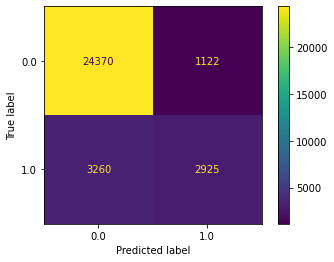

In [46]:
cat = CatBoostClassifier()
plot_result(cat, "cat")

In [47]:

def AUC(cv_AUC, X_test=X_test):
    dtc_auc= roc_auc_score(y_test,dtc.predict(X_test)) #Decision Tree Classifier
    lr_auc= roc_auc_score(y_test, lr.decision_function(X_test))#logistic regression
#     svc_auc= roc_auc_score(y_test, svc.decision_function(X_test))#Support Vector Classifier
    nc_auc= roc_auc_score(y_test, nc.predict(X_test))#Nearest Centroid Classifier
    rfc_auc= roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])#Randomforest Classifier
#     gbc_auc= roc_auc_score(y_test, gbc.predict_proba(X_test)[:,1])#GradientBoosting Classifier
    nb_auc= roc_auc_score(y_test, nb.predict_proba(X_test)[:,1])#Naive Bayes Classifier
#     knn_auc= roc_auc_score(y_test, knn.predict(X_test))#KNeighbors Classifier
    xgb_auc= roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])#XGBoost Classifier
    lgb_auc= roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1])#LightGBM Classifier
    cat_auc= roc_auc_score(y_test, cat.predict_proba(X_test)[:,1])#Catboost Classifier

    cv_AUC={'dtc': dtc_auc,
           'lr': lr_auc,
#            'svc':svc_auc,
           'nc':nc_auc,
           'rfc':rfc_auc,
#            'gbc':gbc_auc,
           'nb':nb_auc,
#            'knn':knn_auc,
           'xgb':xgb_auc,
           'lgb':lgb_auc,
           'cat':cat_auc}
    
    return cv_AUC

In [48]:
cv_AUC = AUC(cv_AUC)
df_eval = pd.DataFrame(data={'model': list(cv_acc_test.keys()), 
                             'bal_acc_train':list(cv_acc_train.values()),
                             'bal_acc_test': list(cv_acc_test.values()), 
                             'recall_1': list(cv_TPR.values()), 
                             'recall_macro': list(recall.values()), 
                             'f1_macro': list(f1.values()), 
                             'fallout':list(cv_FPR.values()),
                             'AUC': list(cv_AUC.values())}).round(2)
df_eval

,model,bal_acc_train,bal_acc_test,recall_1,recall_macro,f1_macro,fallout,AUC
0,lr,0.69,0.70,0.44,0.70,0.73,0.04,0.67
1,nb,0.74,0.74,0.68,0.74,0.70,0.20,0.86
2,dtc,0.67,0.67,0.47,0.67,0.67,0.14,0.73
3,nc,0.73,0.73,0.74,0.73,0.66,0.27,0.87
4,rfc,0.69,0.69,0.43,0.70,0.73,0.04,0.82
5,xgb,0.71,0.70,0.47,0.71,0.74,0.05,0.87
6,lgb,0.70,0.71,0.46,0.71,0.74,0.04,0.87
7,cat,0.71,0.70,0.47,0.71,0.74,0.04,0.88


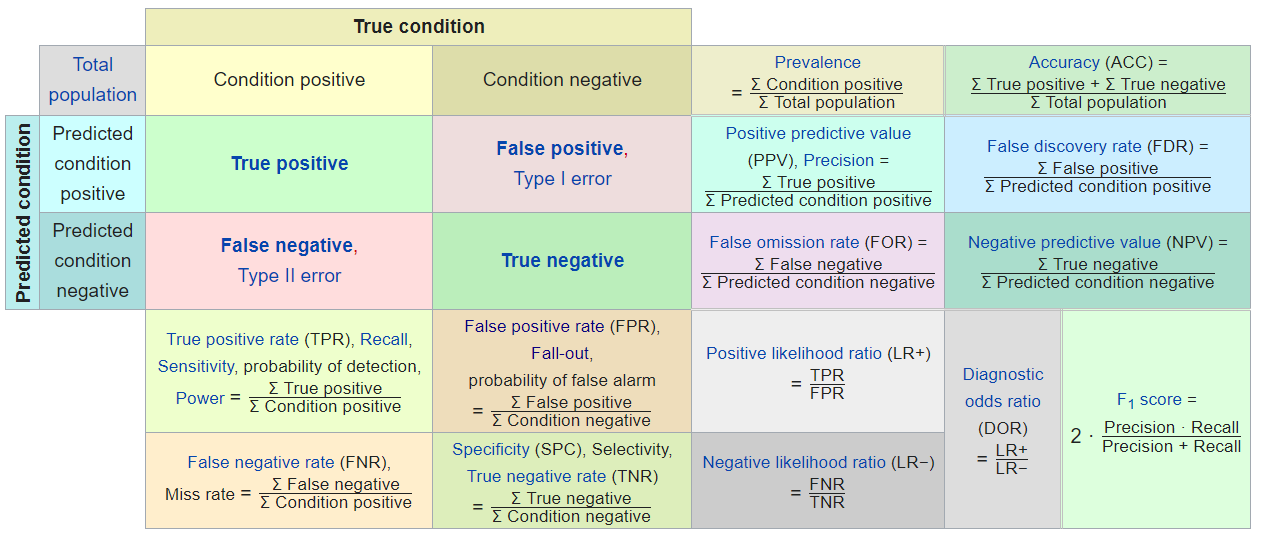

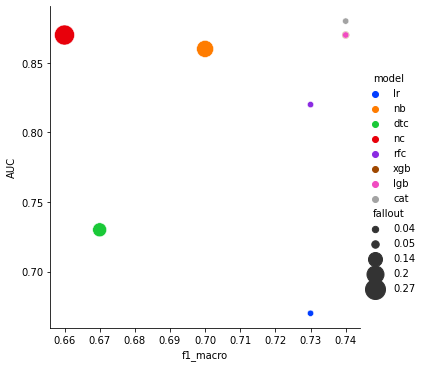

In [60]:
sns.relplot(x="f1_macro", y="AUC", hue="model", size="fallout", 
            sizes=(40, 400), alpha=1, palette="bright", height=5, legend='full', data=df_eval);

>>**Best Model is CatBoost**

### Tunning with XGBOOST

In [62]:
cv_acc_train = {}
cv_acc_test = {}
cv_TPR = {}
cv_FPR = {}
cv_AUC = {}
f1 = {}
recall = {}

In [63]:
from xgboost import XGBClassifier

params = {"n_estimators": [200, 300],
          "subsample":[0.5,1],
          "max_depth":[15,25],
          "learning_rate":[0.01,0.1,0.3]}


In [64]:
# xgb = GridSearchCV(xgb, params, cv = 5, 
#                    n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [65]:
# xgb.best_params_

In [66]:
xgb= XGBClassifier(learning_rate= 0.3, 
                    max_depth= 15, 
                    n_estimators= 200, 
                    subsample= 1).fit(X_train, y_train)

# confusion_matrix(y_test, xgb.predict(X_test))

In [67]:
plot_result(xgb, "xgb")

KeyboardInterrupt: 

### Tunning with LightGBM

In [ ]:
from lightgbm import LGBMClassifier

params = {"n_estimators": [200, 300],
          "subsample":[0.5,1],
          "max_depth":[15,25],
          "learning_rate":[0.01,0.1,0.3]}

In [ ]:
# lgb = GridSearchCV(LGBMClassifier(), params, cv = 5, 
#                             n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [ ]:
# lgb.best_params_

In [ ]:
lgb= LGBMClassifier(learning_rate= 0.1, 
                    max_depth= 18, 
                    n_estimators= 275, 
                    subsample= 0.5).fit(X_train, y_train)

# confusion_matrix(y_test, lgb.predict(X_test))

In [ ]:
plot_result(lgb, "lgb")

### Tunning with CatBoost

In [ ]:
# from catboost import CatBoostClassifier, Pool

# params = {"n_estimators": [200, 300],
#           "subsample":[0.5,1],
#           "max_depth":[1,16],
#           "learning_rate":[0.01,0.1,0.3]}

In [ ]:
# lgb = GridSearchCV(CatBoostClassifier(), params, cv = 5, 
#                             n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [ ]:
# lgb.best_params_

In [ ]:
# lgb= CatBoostClassifier(learning_rate= 0.1, 
#                     max_depth= 2, 
#                     n_estimators= 275, 
#                     subsample= 0.5).fit(X_train, y_train)

# confusion_matrix(y_test, lgb.predict(X_test))

In [ ]:
# plot_result(cat, "cat")

In [ ]:
def AUC(cv_AUC, X_test=X_test):
    xgb_auc= roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])#XGBoost Classifier
    lgb_auc= roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1])#LightGBM Classifier  
#     cat_auc= roc_auc_score(y_test, cat.predict_proba(X_test)[:,1])#Catboost Classifier
    
    cv_AUC={'xgb':xgb_auc,
            'lgb':lgb_auc,
#             'cat':cat_auc,
           }
    
    return cv_AUC

cv_AUC = AUC(cv_AUC)
df_eval = pd.DataFrame(data={'model': list(cv_acc_test.keys()), 
                             'bal_acc_train':list(cv_acc_train.values()),
                             'bal_acc_test': list(cv_acc_test.values()), 
                             'recall_1': list(cv_TPR.values()), 
                             'recall_macro': list(recall.values()), 
                             'f1_macro': list(f1.values()), 
                             'fallout':list(cv_FPR.values()),
                             'AUC': list(cv_AUC.values())}).round(2)
df_eval

>>**Best Model is XGBOOST**

### Saving Model

In [ ]:
xgb= XGBClassifier(learning_rate= 0.3, 
                    max_depth= 15, 
                    n_estimators= 200, 
                    subsample= 1).fit(X, y)

In [ ]:
y_pred = xgb.predict(X)
print(classification_report(y, y_pred))

In [ ]:
import pickle
pickle.dump(xgb,open("model.pkl","wb"))
xgb_model = pickle.load(open("model.pkl","rb"))

In [ ]:
my_dict = {'MinTemp': 21.9,
             'MaxTemp': 38.4,
             'Rainfall': 0.0,
             'Evaporation': 11.4,
             'Sunshine': 12.2,
             'WindGustSpeed': 31.0,
             'WindSpeed9am': 6.0,
             'WindSpeed3pm': 6.0,
             'Humidity9am': 37.0,
             'Humidity3pm': 22.0,
             'Pressure9am': 1012.7,
             'Pressure3pm': 1009.1,
             'Cloud9am': 1.0,
             'Cloud3pm': 5.0,
             'Temp9am': 29.1,
             'Temp3pm': 35.6,
             'RainToday': 0,
             'Month': 1,
             'DiffTemp': 16.5,
             'Location':'Cobar',
             'WindGustDir':'WNW',
             'WindDir9am':'WNW',
             'WindDir3pm':'WSW',
#              'RainTomorrow':0,
             }

In [ ]:
X = pd.DataFrame([my_dict])
X

In [ ]:
all_columns=df.drop('RainTomorrow',axis=1).columns
all_columns

In [ ]:
X = pd.get_dummies(X).reindex(columns=all_columns, fill_value=0)
X

### Make a Prediction

In [ ]:
prediction_XGB = xgb_model.predict(X)
print("RainTomorrow : ",'Yes' if prediction_XGB[0] else 'No')

In [ ]:
prediction_XGB = xgb_model.predict_proba(X)
print(f'The Probability of the Rain is %{round(prediction_XGB[0][1]*100,1)}')

In [ ]:
my_dict = {'MinTemp': 10.5,
             'MaxTemp': 20.0,
             'Rainfall': 2.8,
             'Evaporation': 4.6,
             'Sunshine': 7.3,
             'WindGustSpeed': 67.0,
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 28.0,
             'Humidity9am': 83.0,
             'Humidity3pm': 10.0,
             'Pressure9am': 1011.7,
             'Pressure3pm': 1007.0,
             'Cloud9am': 5.0,
             'Cloud3pm': 6.0,
             'Temp9am': 15.4,
             'Temp3pm': 19.1,
             'RainToday': 1,
             'Month': 8,
             'DiffTemp': 9.5,
             'Location':'Perth',
             'WindGustDir':'NNW',
             'WindDir9am':'N',
             'WindDir3pm':'NW',
#              'RainTomorrow':1,
             }

X = pd.DataFrame([my_dict])
X = pd.get_dummies(X).reindex(columns=all_columns, fill_value=0)
prediction_XGB = xgb_model.predict(X)
print("RainTomorrow : ",'Yes' if prediction_XGB[0] else 'No')

In [ ]:
prediction_XGB = xgb_model.predict_proba(X)
print(f'The Probability of the Rain is %{round(prediction_XGB[0][1]*100,1)}')